Artificial Intelligence II (YS19) - Homework 2

<u>Student credentials</u><br>
**FullName:** Spanos Nikolaos<br>
**Student AM:** 7115112100023<br>
**Student email:** cs2210023@di.uoa.gr <br><br>


**Supervisor:** Professor Manolis Koumparakis <br>
*All rights reserved from National and Kapodistrian University of Athens, Department of Computer Science (DI)*

Athens, Greece, December 2022

In [1]:
!pip install --quiet optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import label_binarize
from itertools import cycle

import optuna
import joblib

from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import time
import collections
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchtext

torch.manual_seed(123)

%matplotlib inline

pd.set_option('display.max_colwidth', None)

     |████████████████████████████████| 348 kB 15.4 MB/s 
     |████████████████████████████████| 81 kB 10.6 MB/s 
     |████████████████████████████████| 210 kB 82.8 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
     |████████████████████████████████| 147 kB 84.7 MB/s 
     |████████████████████████████████| 112 kB 65.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import & Initialize all the functions used in the experiments

In [3]:
def average_sentence_length(text):
  """
  Definition
  ---------
  Create a list of lengths per sentence in the training, validation tables. The list takes as argument a sentences, splits the sentence in spaces and calculates the number of words per sentence.

  Arguments
  ---------
  text: A single sentence with words separated by spaces. It's mandatory the sentences to be splitted by space (' ').

  Output
  ---------
  List of sentence lengths (word level). The total length of the list is equal to the number of sentences in the training, validation tables.
  """
  return len(text)

def padded_sequences(vector_array, padding_value):
  """
  Definition
  ---------
  Padding is applied on a vector to fix the number of integers in the vector. Vectors with length greater than the padding value are trimmed.
  While, vectors with size less than the padding_value keep their length and extra zeros are added to complete the rest of the vector's length and to match the padding threshold.

  Arguments
  ---------
  vector_array: A numpy array of vector lists. List of list.
  padding_value: The value to fix the length of all vectors in the corpus.

  Output
  ---------
  Fixed sized vectors
  """
  padded_vectors = np.zeros((len(vector_array), padding_value), dtype=int)

  for i, review in enumerate(vector_array):
    review_len = len(review)

    if (review_len<=padding_value):
      zeros=list(np.zeros(padding_value-review_len, dtype=int))
      new=review+zeros
    else:
      new=review[:padding_value]
    padded_vectors[i,:] = new

  return padded_vectors

def train(model, dataloader_object, optimizer, criterion, training_losses):
  """
  Definition
  ---------
  Train the Neural Network on the training sample DataLoader object. Then collect the training losses of the model training.
  The training loss is an array of losses calculated during epoch training per batch.

  Aguments
  ---------
  model : Feed forward NN object.
  dataloader_object : DataLoader object with training batches of shape ([vectorized_padded_sentence, sentiment]).
  optimizer : Optimizer object.
  criterion : The loss function object from torch.nn library.
  training_losses : An empty array to store the training loss per epoch.

  Output
  ---------
  Training loss per epoch, list of training losses from all epochs.
  """
  epoch_loss = 0
  
  model.train()
  
  for review, sentiment in dataloader_object:
      
    optimizer.zero_grad()

    predictions = model(review)
    
    loss = criterion(predictions, sentiment.float())

    loss.backward()
    
    optimizer.step()
    
    epoch_loss += loss.item()

  training_losses.append(epoch_loss / len(dataloader_object))

  return epoch_loss / len(dataloader_object)
  
def evaluate(model, dataloader_object, criterion, validation_losses):
  """
  Definition
  ---------
  Evaluate the NN on the validation sample. Collect the validation loss on an array to plot it against the training loss. 

  Aguments
  ---------
  model : Feed forward NN object.
  dataloader_object : DataLoader object with training batches of shape ([vectorized_padded_sentence, sentiment]).
  criterion : The loss function object from torch.nn library.
  validation_losses : An empty array to store the validation loss per epoch.

  Output
  ---------
  Validation loss per epoch, list of validation losses from all epochs.
  """
  
  epoch_loss = 0

  model.eval()
  
  with torch.no_grad():
  
    for review, sentiment in dataloader_object:

        predictions = model(review)

        loss = criterion(predictions, sentiment.float())

        epoch_loss += loss.item()

  validation_losses.append(epoch_loss / len(dataloader_object))

  return epoch_loss / len(dataloader_object)

def count_parameters(model):
    """
    Definition
    ---------
    Count model's trainable parameters per Optuna trial. Each trial in Optuna generates a different model based on the hyper parameters tuned.

    Arguments
    ---------
    model: NN feed forward network object.

    Output
    ---------
    Sum of the trainable parameters.
    """
    
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    """
    Definition
    ---------
    Calculate the time execution per epoch.

    Arguments
    ---------
    start_time: Start time
    end_time: Time the epoch ended

    Output
    ---------
    The difference between end_time, start_time in minutes and seconds.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

class EarlyStopper:
  """
  Definition
  ---------
  Apply Early Stopping mechanism when the validation loss calculated per epoch is not improving.

  Arguments
  ---------
  patience: For how many epochs the model tolerates no improvements in validation loss.
  min_delta: The difference between validation loss and epoch loss. A difference greater than 0.015 (i.e. 0.90, 0.915 raises a flag).
  validation_loss: epoch loss on validation samples.

  Output
  ---------
  Break model training if patience threshold reached.
  """
  def __init__(self, patience=10, min_delta=0.00002): #0.00002, 0010
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    boolean_state:bool = None

    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    
    # elif validation_loss >= (self.min_validation_loss + self.min_delta):
    elif validation_loss >= (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        boolean_state = True
        return boolean_state, self.min_validation_loss
    
    boolean_state = False
    return boolean_state, self.min_validation_loss

def plot_learning_curves(train_loss_array, validation_loss_array, graph_name):
  """
  Definition
  ---------
  Plot learning curves after the training of the neural network.

  Arguments
  ---------
  train_loss_array: Array of the training losses per epoch.
  validation_loss_array: Array of the validation losses per epoch.
  graph_name: The title of the plots.

  Output
  ---------
  Training and Validation learning curves.
  """
  plt.figure(figsize=(8,8))
  plt.plot(train_loss_array,'-o')
  plt.plot(validation_loss_array,'-o')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Train','Validation'])
  plt.title('Training - Validation learning curves | {0}'.format(graph_name))

  plt.show()

def intuitive_confusion_matrix(validation_target, matrix:np.ndarray, label_categories:list, model_name:str):
  """
  Definition
  ---------
  Create a more intuitive confusion matrix for the model predictions. The plot will depict class names, predictions per class and the percentage of the prediction over the total quotes of a specific class.

  Aguments
  ---------
  validation_target : The target labels of the validation sample.
  matrix            : Output object of sklearn.metrics.confusion_matrix.
  label_categories  : Class names of the categories.
  model_name        : Model name based on the classifier used (i.e. Baseline model, Random Forest, Multinomial Naive Bayes, etc.).

  Output
  ---------
  Heatmap
  """
  x1=list(validation_target) #unique label values
  #x2=[0,2] #this is not dynamic. Please be careful when run it with more than two labels. For example, for three labels the array would be [0,3,6]
  x2=[]
  for i in range(len(x1)):
    x2.append(x1[i]*len(x1))

  percentages = np.zeros(len(matrix.flatten()), dtype=float) #empty list of 0 to fill in the percentages
  for i in x1:
    percentages[x2] = matrix.flatten()[x2]/matrix.flatten()[x2].sum()
    x2 = [index+1 for index in x2]

  counts = ["{0:0.0f}\n".format(value) for value in matrix.flatten()]
  percentages = ["{0:.2%}".format(my) for my in percentages]

  box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(counts,percentages)]
  box_labels = np.asarray(box_labels).reshape(matrix.shape[0],matrix.shape[1])

  plt.figure(figsize=(8,8))
  plt.title(f"Confusion matrix - {model_name}")
  sns.heatmap(matrix, annot=box_labels, square=True, fmt='', cbar=False, cmap='Blues', xticklabels=label_categories, yticklabels=label_categories)
  plt.xlabel('true labels')
  plt.ylabel('predicted labels')

def get_bias(predicted_values: np.array, true_values: np.array) -> float:
  """
  Definition
  ---------
  Calculates model bias.
  
  Aguments
  ---------
  predicted_values : Predicted label from classifier.predict() method
  true_values      : True values of target feature (y_validation, y_test)
  
  Output
  ---------
  bias: float representing the bias of the model
  """

  #return np.round(np.mean((predicted_values - true_values) ** 2), 4)
  SSE = np.round(np.mean((np.mean(predicted_values) - true_values) ** 2), 4)
  Variance = np.round(np.var(predicted_values), 4)
  Bias = abs(SSE - Variance)
  return np.round(Bias, 4)

def get_variance(predicted_values:np.array) -> float:
  """
  Definition
  ---------
  Calculates model variance based on the predicted values.
  
  Aguments
  ---------
  predicted_values : Predicted label from classifier.predict() method
  
  Output
  ---------
  variance: float representing the variance of the predicted values
  """

  # return np.round(np.var(predicted_values), 4)
  return round((np.sum((predicted_values - np.mean(predicted_values)**2)))/len(predicted_values),4)

def get_evaluation_metrics(true_labels:np.array, predicted_labels:np.array, predicted_labels_probabilities:np.array, model_name:str):
  """
  Definition
  ---------
  Compute the evaluation metrics for a specific model classifier. Briefly, the metrics returned are: precision, recall, roc_score, f1_metric calculated for a Multi-Class experiment.
  The function also returns the model bias and variance based on the classification predictions.
  
  Arguments
  ---------
  true_labels                    : Numpy array of the true labels of validation dataset
  predicted_labels               : Numpy array of the predicted labels of validation dataset (model.predict() method)
  predicted_labels_probabilities : Numpy array of the predicted label probabilities of validation dataset (model.predict_proba() method)
  model_name                     : String of the model name to distinguish the results per different model classifier
  
  Output
  ---------
  Print the results to stdout of the Notebook console.
  """

  precision_base = precision_score(y_true=true_labels, y_pred=predicted_labels, average='binary')
  recall_base    = recall_score(y_true=true_labels, y_pred=predicted_labels, average='binary')
  roc_base       = roc_auc_score(true_labels, predicted_labels, labels=np.unique(true_labels))
  f1_metric      = f1_score(true_labels, predicted_labels, average='binary')

  print(f"Evaluation metrics: {model_name} \n\nprecision score: {precision_base:.4f} \nrecall_score: {recall_base:.4f} \nroc score: {roc_base:.4f} \nf1_score: {f1_metric:.4f}")
  print(f"\nmodel bias: {get_bias(predicted_labels, true_labels)}")
  print(f"model variance: {get_variance(predicted_labels)}")

def nn_evaluation(model_classifier, validation_iterator, label_names, unique_sentiment_values, report_title):
  """
  Definition
  ---------
  Create the evaluation report of the feed forward model classifier selected by Optuna Hyper parameter tuning.

  Arguments
  ---------
  model_classifier : Best feed forward neural network after Optuna optimization.
  validation_iterator : Validation iterator sample to evaluate different neural networks.
  label_names : The sentiment names.
  report_title: The title of the report.

  Output
  ---------
  Heatmap - confusion matrix - evaluation metrics.
  """

  y_pred = []
  y_true = []
  y_pred_probabilities = []

  for inputs, labels in validation_iterator:

    output = model_classifier(inputs)

    output_value = (output>0.5).int().data.cpu().numpy()
    output_probabilities = output.data.cpu().numpy()
    
    y_pred.extend(output_value)
    y_pred_probabilities.extend(output_probabilities)
    
    labels = labels.data.cpu().numpy()
    y_true.extend(labels)

  y_pred = np.asarray(y_pred)
  y_true = np.asarray(y_true)
  y_pred_probabilities = np.asarray(y_pred_probabilities)

  validation_confusion_matrix = confusion_matrix(y_true, y_pred, labels=unique_sentiment_values) #validation_data["label"].sort_values().unique())

  intuitive_confusion_matrix(unique_sentiment_values, validation_confusion_matrix, label_names, report_title)
  get_evaluation_metrics(y_true, y_pred, y_pred_probabilities, report_title)
  print('\n') 
  print(classification_report(y_true, y_pred, target_names=label_names))
  print('\n')

  return y_true, y_pred, y_pred_probabilities

def roc_curve_plot(y_true, y_pred, graph_name):
  """
  Definition
  ---------
  Plot the ROC-AUC curve for the trained model classifier and those of a model.
  Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

  Arguments
  ---------
  model_classifier : Best feed forward neural network after Optuna optimization.
  validation_iterator : Validation iterator sample to evaluate different neural networks.
  label_names : The sentiment names.
  report_title: The title of the report.

  Output
  ---------
  Heatmap - confusion matrix - evaluation metrics.
  """
  random_model_probs = [0 for _ in range(len(y_true))]
  random_model_auc = roc_auc_score(y_true, random_model_probs)

  model_auc = roc_auc_score(y_true, y_pred)

  random_model_fpr, random_model_tpr, _ = roc_curve(y_true, random_model_probs)
  fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)

  plt.figure(figsize=(10,10))

  plt.plot(random_model_fpr, random_model_tpr, linestyle='--', label='Random Model classifier')
  plt.plot(fpr, tpr, marker='.', label='Trained NN')
  
  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f"Receiver operating characteristic | {graph_name}")
  plt.legend(loc="lower right")
  plt.show()

### Import checkpoints to save important object variables through the experimentation

In [20]:
checkpoint_1 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/data_sample.pkl"
checkpoint_2 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/custom_vocabulary.joblib"
checkpoint_3 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/build_vectors.joblib"

#--new vocab
checkpoint_4 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/custom_vocabulary_v2.joblib"
checkpoint_5 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/build_vectors_v2.joblib"

#GloVe embeddings-(50,6B)
checkpoint_6 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vocab.joblib"
checkpoint_7 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_sample.joblib"

#GloVe embeddings-(100,6B)
checkpoint_8 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_100_6B.joblib"
checkpoint_9 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_100_6B_sample.joblib"

#GloVe embeddings-(200,6B)
checkpoint_10 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_200_6B.joblib"
checkpoint_11 = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_200_6B_sample.joblib"

### Import the already cleaned dataset after text normilization techniques have been applied from the previous HW1

In [4]:
# Load data samples | Already cleaned from HW1
data_sample = pd.read_pickle(checkpoint_1)
data_sample["normalized_review_tokens"] = data_sample["normalized_review"].apply(lambda review: review.split(' '))

# Isolate the trainable text and target column
trainable_sample = data_sample[["normalized_review", "normalized_review_tokens", "target"]]

# Zip the two columns into a single iterator object list
iterator_sample = list(zip(trainable_sample['target'],trainable_sample['normalized_review']))

### Create Vocabulary objects and Vectorize the text samples based on:
- Custom vocabulary iterator
- GloVe vocabulary (6B words with 50 dimensions)
- GloVe vocabulary (6B words with 300 dimensions)

In [ ]:
# tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
# tokenized_samples = [tokenizer(sentence) for sentiment, sentence in iteratos_sample ]

counter = collections.Counter()
for (sentiment, review) in iterator_sample:
    counter.update(torchtext.data.utils.ngrams_iterator(review.split(' '), ngrams = 2))

counter = {k: v for k, v in counter.items() if len(k) > 1}

# Sort the frequency counter tokens in descending order based on the frequency (higher->lower)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = collections.OrderedDict(sorted_by_freq_tuples) #104,158 words in total

unk_token = '<unk>'
default_index = -1

# Build vocabulary from text
vocab = torchtext.vocab.vocab(ordered_dict, min_freq=100, specials=[unk_token])
vocab.set_default_index(default_index)
vocab.set_default_index(vocab[unk_token])

# Save the vocabulary
dump(vocab, checkpoint_4)

# Vectorize data from the vocabulary
vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split(' '):
    if word in vocab:
      vector_review_array.append(vocab[word])
    else:
      vector_review_array.append(vocab[unk_token])
  vectors_array.append(vector_review_array)

# Save the created vectors
dump(vectors_array, checkpoint_5)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/build_vectors_v2.joblib']

### GloVe embeddings (Vocabulary and Vectors)

#### 50 embeddings dimension & 6B words

In [ ]:
#Download GloVe embeddings
glove_vocab = torchtext.vocab.GloVe(name='6B', dim=50)

#save the vocabulary object of GloVe embeddings
dump(glove_vocab, checkpoint_6)

In [ ]:
# Vectorize data using the GloVe pre-trained embeddings
glove_vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab:
      vector_review_array.append(glove_vocab[word])
    else:
      vector_review_array.append(vocab[unk_token])
  glove_vectors_array.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array, checkpoint_7)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_sample.joblib']

#### 100 embeddings dimension & 6B words

In [ ]:
#Download GloVe embeddings
glove_vectors_100 = torchtext.vocab.GloVe(name='6B', dim=100)

#save the vocabulary object of GloVe embeddings
dump(glove_vectors_100, checkpoint_8)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                           
100%|█████████▉| 399999/400000 [00:16<00:00, 24823.39it/s]


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_100_6B.joblib']

In [ ]:
unk_token = '<unk>'
unk_index = 0

glove_vocab = torchtext.vocab.vocab(glove_vectors_100.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab:
      vector_review_array.append(glove_vocab[word])
    else:
      vector_review_array.append(glove_vocab[unk_token])
  glove_vectors_array.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array, checkpoint_9)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_100_6B_sample.joblib']

#### 200 embeddings dimension & 6B words

In [ ]:
#Download GloVe embeddings
glove_vectors_200 = torchtext.vocab.GloVe(name='6B', dim=200)

#save the vocabulary object of GloVe embeddings
dump(glove_vectors_200, checkpoint_10)

100%|█████████▉| 399999/400000 [00:28<00:00, 14024.07it/s]


['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_200_6B.joblib']

In [ ]:
unk_token = '<unk>'
unk_index = 0

glove_vocab = torchtext.vocab.vocab(glove_vectors_200.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors_array = []

for sentiment, review in tqdm(iterator_sample):
  vector_review_array = []
  for word in review.split():
    if word in glove_vocab:
      vector_review_array.append(glove_vocab[word])
    else:
      vector_review_array.append(glove_vocab[unk_token])
  glove_vectors_array.append(vector_review_array)

# Save the created vectors
dump(glove_vectors_array, checkpoint_11)

  0%|          | 0/40000 [00:00<?, ?it/s]

['drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectorized_200_6B_sample.joblib']

### Import Vocabulary and Vectors from disk

In [39]:
#Load vocabulary build on iterator
vocab =  load(checkpoint_4)

vectors_array = load(checkpoint_5)
target_sentiment = data_sample[["target"]].values

unk_token = '<unk>'
unk_index = 0

#Load GloVe embeddings - 50 embeddings dimension & 6B words
glove_vectors =  load(checkpoint_6)
glove_vocab = torchtext.vocab.vocab(glove_vectors.stoi)
glove_vocab.insert_token(unk_token,unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors_array = load(checkpoint_7)

#Load GloVe embeddings - 100 embeddings dimension & 6B words
glove_vectors_100 =  load(checkpoint_8)
glove_vocab_100 = torchtext.vocab.vocab(glove_vectors_100.stoi)
glove_vocab_100.insert_token(unk_token,unk_index)
glove_vocab_100.set_default_index(unk_index)

glove_vectors_array_100 = load(checkpoint_9)

#Load GloVe embeddings - 200 embeddings dimension & 6B words
glove_vectors_200 =  load(checkpoint_10)
glove_vocab_200 = torchtext.vocab.vocab(glove_vectors_200.stoi)
glove_vocab_200.insert_token(unk_token,unk_index)
glove_vocab_200.set_default_index(unk_index)

glove_vectors_array_200 = load(checkpoint_11)

### Padding the length of each vector to fixed size value. It's imperative the samples per training/validation/test batch to have equal lengths.

In [40]:
samples_length=[]
for sentence in tqdm(vectors_array):
  samples_length.append(average_sentence_length(sentence))

percentile = 80
padding_value = int(np.percentile(samples_length, q=percentile))
# padding_value = 150
print("Padding length of samples: ", padding_value)

padded_vectors = padded_sequences(glove_vectors_array, padding_value) #vectors_array: trainable embeddings, glove_vectors_array: for pretrained GloVe embeddings

# from collections import Counter
# elements_count = collections.Counter(samples_length)

# sorted_freq = {k: v for k, v in sorted(elements_count.items(), key=lambda item: item[1], reverse=True)}
# sorted_freq

  0%|          | 0/40000 [00:00<?, ?it/s]

Padding length of samples:  165


### Split samples into:
- Training samples
- Validation samples
- Test samples

In [51]:
# Apply stratified shuffle split to retrieve train, validation. test samples
# training samples: 85%, validation samples: 5%, test samples: 10%

train_x, test_x, train_y, test_y = train_test_split(
    padded_vectors,
    target_sentiment,
    shuffle=True,
    test_size=0.1,
    random_state=np.random.RandomState(0),
    stratify = target_sentiment
)
train_x, valid_x, train_y, valid_y = train_test_split(
    train_x,
    train_y,
    shuffle=True,
    test_size=0.15,
    random_state=np.random.RandomState(0),
    stratify = train_y
)

print("train_x shape: ", train_x.shape)
print("valid_x shape", valid_x.shape)
print("test_x shape: ", test_x.shape)

print("\nsentiment frequency (training sample): ", np.unique(train_y, return_counts=True))
print("\nsentiment frequency (validation sample): ", np.unique(valid_y, return_counts=True))
print("\nsentiment frequency (test sample): ", np.unique(test_y, return_counts=True))

train_x shape:  (30600, 165)
valid_x shape (5400, 165)
test_x shape:  (4000, 165)

sentiment frequency (training sample):  (array([0, 1]), array([15300, 15300]))

sentiment frequency (validation sample):  (array([0, 1]), array([2700, 2700]))

sentiment frequency (test sample):  (array([0, 1]), array([2000, 2000]))


### Create ```DataLoader()``` objects for iteration over (reviews, sentiment) in the training, validation and test phase.

In [52]:
# create Tensor Dataset
train_data = torch.utils.data.TensorDataset(torch.LongTensor(train_x), torch.LongTensor(train_y))
valid_data = torch.utils.data.TensorDataset(torch.LongTensor(valid_x), torch.LongTensor(valid_y))
test_data = torch.utils.data.TensorDataset(torch.LongTensor(test_x), torch.LongTensor(test_y))

# create Tensor Dataset
batch_size_train=256
batch_size_validation=128
batch_size=64

train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_data, batch_size=batch_size_validation, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

---

### Trivial Complexity - Trainable embeddings

Creating a less sophisticated/complex baseline model. Based on the training results of the previous neural networks, the model had a great overfit. This means that the model is quite complex for the given dataset. A good start would be to create a less complex model, without normalizationa, higher dropout rate and less linear layers.

Trivial complexity Neural Network with Optuna

* No dropout layers
* No normalization & regularization techniques.
* Most parameters in their default values

In [ ]:
class SentimentClassifier_trivial_model_complexity(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_trivial_model_complexity, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = non_contributive_token

    linear_hidden_units = trial.suggest_int("input_hidden_units", 8, 128)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    else:
      embedding_dimension = trial.suggest_int("embedding_dimension", 10, 100)
      self.embedding = nn.Embedding(vocab_size, embedding_dimension, padding_idx=padding_idx)
      self.embedding.weight.requires_grad = True
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension*vector_length, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    #Specify number of additional layers
    self.n_layers = 0

    #output layer
    self.output_layer = nn.Linear(linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      module.weight.data.normal_(mean=0.0, std=1.0)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()

  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded = embedded_average
      # embedded_max = torch.max(embedded, dim=1)[0]
      # embedded_min = torch.min(embedded, dim=1)[0]

      # #use of average embeddings transformation
      # input_layer_average = self.input_layer(embedded_average)
      # input_layer_average = self.activation(input_layer_average)
      
      # #use of max embeddings transformation
      # input_layer_max = self.input_layer(embedded_max)
      # input_layer_max = self.activation(input_layer_max)

      # #use of min embeddings transformation
      # input_layer_min = self.input_layer(embedded_min)
      # input_layer_min = self.activation(input_layer_min)

    else:
      embedded = self.flatten_layer(embedded)

    # input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=0)
    input_layer = self.input_layer(embedded)
    input_layer = self.activation(input_layer)

    # print("3",input_layer.shape) #[192,1] vs [64,1] -> output layer

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
def objective(trial):
  torch.manual_seed(123)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_trivial_model_complexity(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=False
    #embedding_matrix=glove_vectors.vectors,
    #embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-3, 1e-2)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 150
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "trainable"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_baseline_trivial_complexity_nn_optuna_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "Trainable Embeddings Trivial Complexity Neural Net"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2022-12-20 12:51:45,823] A new study created in memory with name: hyper-parameter tuning of baseline classifier with trainable embeddings



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 78, padding_idx=0)
  (input_layer): Linear(in_features=11700, out_features=84, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=84, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 1,532,323 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 48.171
	 Val. Loss: 49.338

Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 48.659
	 Val. Loss: 49.374

Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 47.335
	 Val. Loss: 48.188

Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 45.759
	 Val. Loss: 44.058

Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 40.316
	 Val. Loss: 36.335

Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 34.353
	 Val. Loss: 32.955

Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 32.638
	 Val. Loss: 31

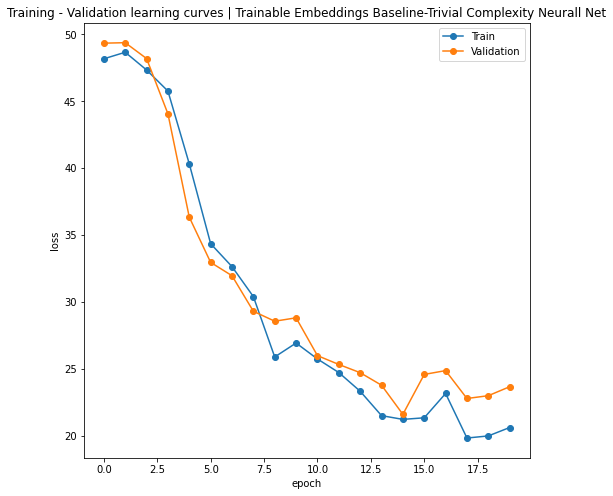

[I 2022-12-20 12:56:55,256] Trial 0 finished with value: 21.60119918297077 and parameters: {'activation': 'ReLU', 'input_hidden_units': 84, 'embedding_dimension': 78, 'optimizer': 'Adam', 'lr': 0.00784477640979063}. Best is trial 0 with value: 21.60119918297077.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 96, padding_idx=0)
  (input_layer): Linear(in_features=14400, out_features=90, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=90, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 1,972,309 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 49.092
	 Val. Loss: 49.435

Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 49.711
	 Val. Loss: 49.982

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 49.832
	 Val. Loss: 49.087

Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 49.853
	 Val. Loss: 49.824

Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 49.846
	 Val. Loss: 50.467

Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 49.832
	 Val. Loss: 50.195

Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 49.798
	 Val. Loss: 49

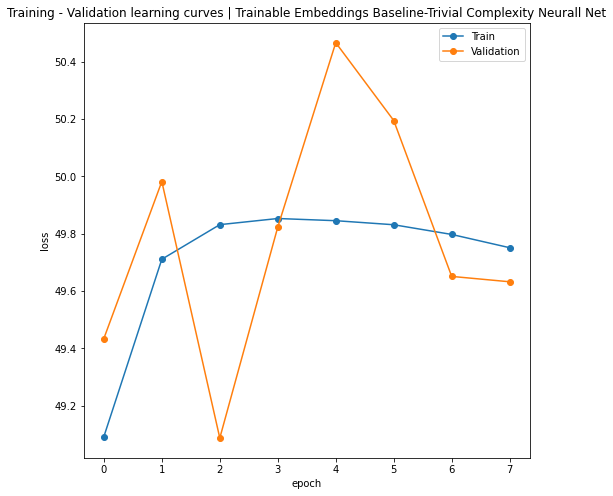

[I 2022-12-20 12:58:31,758] Trial 1 finished with value: 49.0873531473094 and parameters: {'activation': 'ReLU', 'input_hidden_units': 90, 'embedding_dimension': 96, 'optimizer': 'SGD', 'lr': 0.006512734601464494}. Best is trial 0 with value: 21.60119918297077.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 75, padding_idx=0)
  (input_layer): Linear(in_features=11250, out_features=119, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=119, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 1,867,214 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 48.080
	 Val. Loss: 50.480

Epoch: 02 | Epoch Time: 0m 22s
	Train Loss: 48.920
	 Val. Loss: 49.471

Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 49.081
	 Val. Loss: 49.589

Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 48.881
	 Val. Loss: 49.742

Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 47.821
	 Val. Loss: 48.983

Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 46.704
	 Val. Loss: 45.155

Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 41.612
	 Val. Loss: 

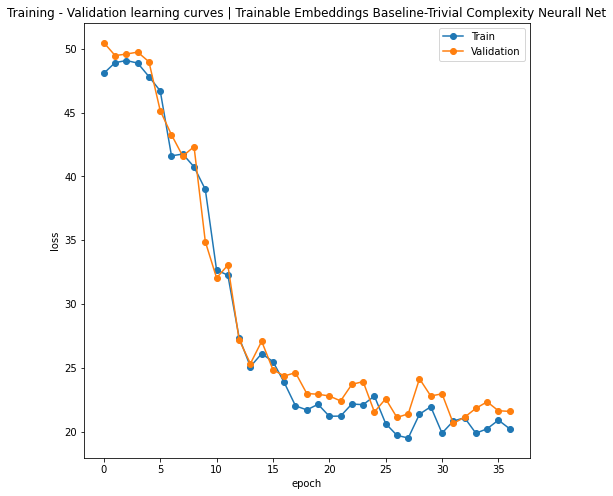

[I 2022-12-20 13:13:07,350] Trial 2 finished with value: 20.64308186235099 and parameters: {'activation': 'ReLU', 'input_hidden_units': 119, 'embedding_dimension': 75, 'optimizer': 'Adam', 'lr': 0.007067202535597108}. Best is trial 2 with value: 20.64308186235099.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 56, padding_idx=0)
  (input_layer): Linear(in_features=8400, out_features=82, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=82, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 1,083,373 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 47.426
	 Val. Loss: 48.164

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 49.198
	 Val. Loss: 48.807

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 49.608
	 Val. Loss: 49.067

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 49.813
	 Val. Loss: 49.893

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 49.737
	 Val. Loss: 49.483


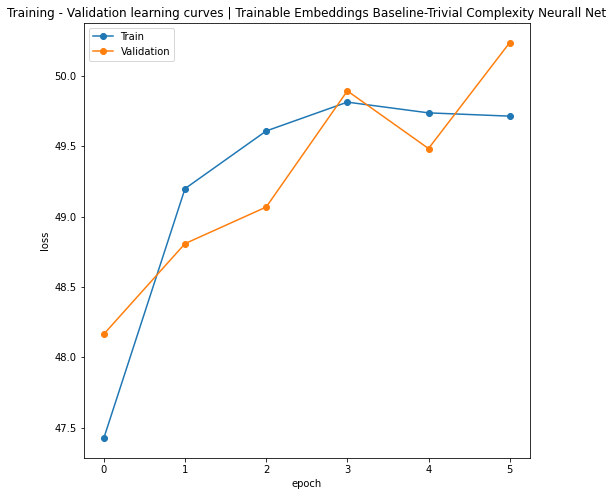

[I 2022-12-20 13:13:48,007] Trial 3 finished with value: 48.16420377534011 and parameters: {'activation': 'ReLU', 'input_hidden_units': 82, 'embedding_dimension': 56, 'optimizer': 'SGD', 'lr': 0.005694824371542707}. Best is trial 2 with value: 20.64308186235099.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 37, padding_idx=0)
  (input_layer): Linear(in_features=5550, out_features=18, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=18, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 360,528 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 44.847
	 Val. Loss: 47.106

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 42.988
	 Val. Loss: 39.038

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 32.556
	 Val. Loss: 29.926

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 21.554
	 Val. Loss: 19.005

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 12.004
	 Val. Loss: 4.463

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.665
	 Val. Loss: 0.743

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.305
	 Val. Loss: 0.552

Epoch: 08

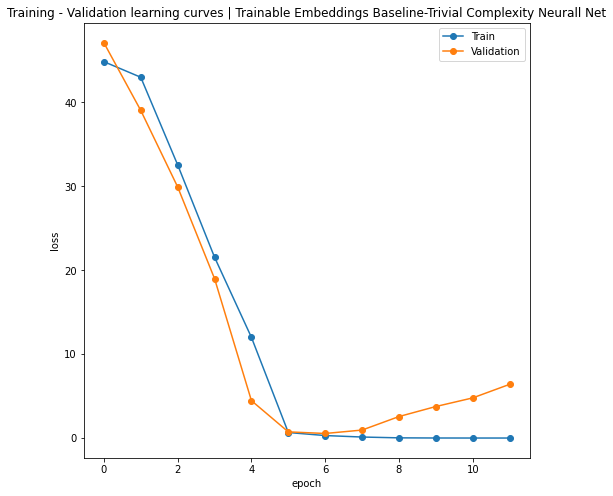

[I 2022-12-20 13:14:34,838] Trial 4 finished with value: 0.5516867277951076 and parameters: {'activation': 'ReLU', 'input_hidden_units': 18, 'embedding_dimension': 37, 'optimizer': 'RMSprop', 'lr': 0.006636584334802534}. Best is trial 4 with value: 0.5516867277951076.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 87, padding_idx=0)
  (input_layer): Linear(in_features=13050, out_features=32, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 1,030,406 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.803
	 Val. Loss: 0.691

Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.673
	 Val. Loss: 0.647

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.565
	 Val. Loss: 0.540

Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.441
	 Val. Loss: 0.472

Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.366
	 Val. Loss: 0.446

Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.321
	 Val. Loss: 0.406

Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.286
	 Val. Loss: 0.405

Epoch: 08 | Epo

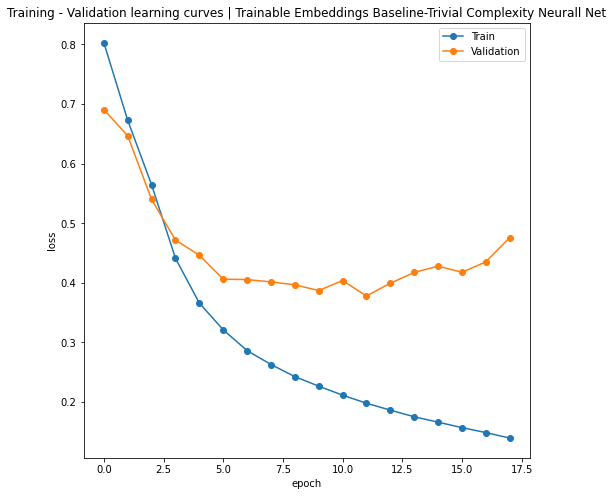

[I 2022-12-20 13:16:56,790] Trial 5 finished with value: 0.37795125166403837 and parameters: {'activation': 'Tanh', 'input_hidden_units': 32, 'embedding_dimension': 87, 'optimizer': 'RMSprop', 'lr': 0.008955428316050677}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 18, padding_idx=0)
  (input_layer): Linear(in_features=2700, out_features=55, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=55, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 275,385 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 46.218
	 Val. Loss: 47.141

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 46.146
	 Val. Loss: 43.767

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 34.162
	 Val. Loss: 26.494

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 22.787
	 Val. Loss: 20.718

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 19.748
	 Val. Loss: 21.141

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 18.607
	 Val. Loss: 18.823

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 17.052
	 Val. Loss: 18.507

Epoc

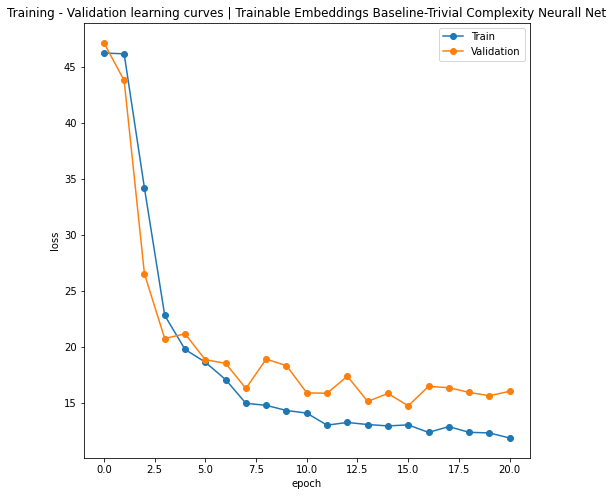

[I 2022-12-20 13:18:13,311] Trial 6 finished with value: 14.70892389683888 and parameters: {'activation': 'ReLU', 'input_hidden_units': 55, 'embedding_dimension': 18, 'optimizer': 'Adam', 'lr': 0.009498346410149211}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 32, padding_idx=0)
  (input_layer): Linear(in_features=4800, out_features=107, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=107, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 739,191 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 48.609
	 Val. Loss: 49.104

Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 49.250
	 Val. Loss: 49.529

Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 49.381
	 Val. Loss: 49.474

Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 49.120
	 Val. Loss: 48.970

Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 48.716
	 Val. Loss: 50.208

Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 48.709
	 Val. Loss: 49.191

Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 48.484
	 Val. Loss: 48.663

Ep

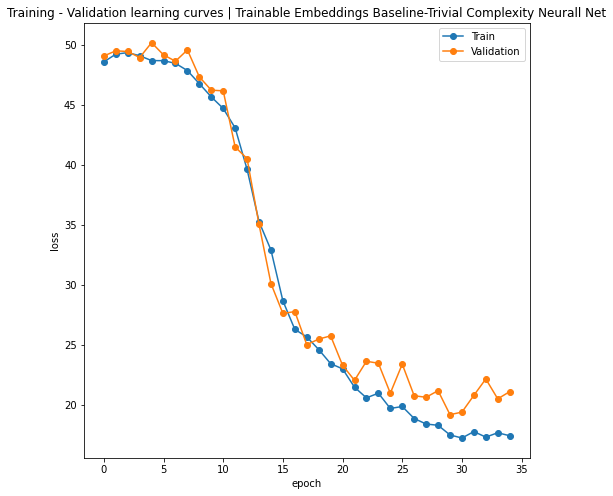

[I 2022-12-20 13:22:01,356] Trial 7 finished with value: 19.20385531721444 and parameters: {'activation': 'ReLU', 'input_hidden_units': 107, 'embedding_dimension': 32, 'optimizer': 'RMSprop', 'lr': 0.0063118122668688065}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 37, padding_idx=0)
  (input_layer): Linear(in_features=5550, out_features=17, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=17, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 354,976 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.909
	 Val. Loss: 0.695

Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.686
	 Val. Loss: 0.689

Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.662
	 Val. Loss: 0.687

Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.598
	 Val. Loss: 0.638

Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.508
	 Val. Loss: 0.572

Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.429
	 Val. Loss: 0.525

Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.374
	 Val. Loss: 0.495

Epoch: 08 | Epoch 

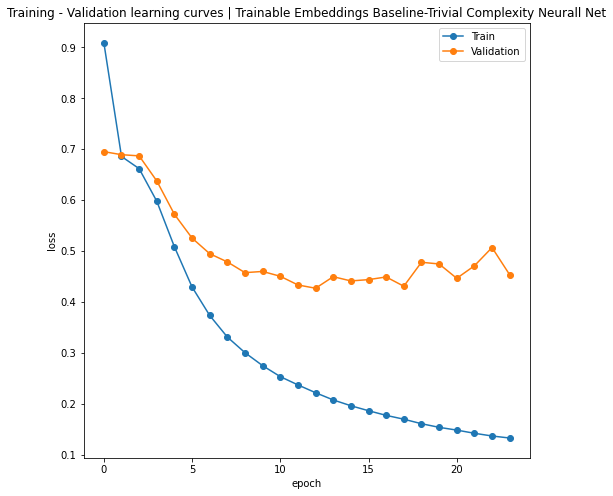

[I 2022-12-20 13:23:21,729] Trial 8 finished with value: 0.4269736761163021 and parameters: {'activation': 'Tanh', 'input_hidden_units': 17, 'embedding_dimension': 37, 'optimizer': 'RMSprop', 'lr': 0.004865429605884746}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 13, padding_idx=0)
  (input_layer): Linear(in_features=1950, out_features=49, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=49, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 187,208 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 1.335
	 Val. Loss: 0.706

Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.677
	 Val. Loss: 0.708

Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.653
	 Val. Loss: 0.713

Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.618
	 Val. Loss: 0.716

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.563
	 Val. Loss: 0.678

Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.486
	 Val. Loss: 0.648

Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.400
	 Val. Loss: 0.614

Epoch: 08 | Epoch 

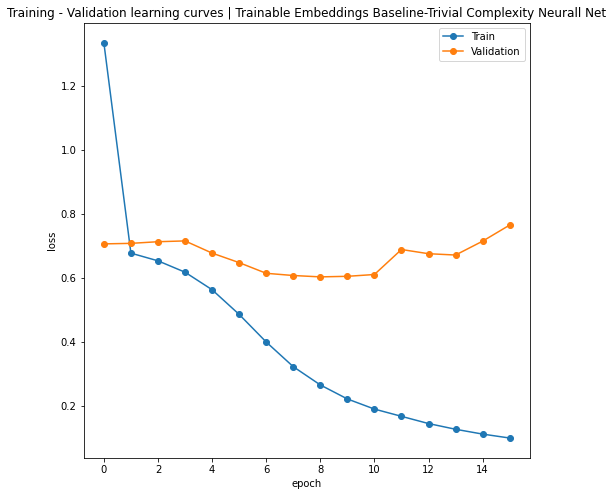

[I 2022-12-20 13:24:03,593] Trial 9 finished with value: 0.6032253627119393 and parameters: {'activation': 'Tanh', 'input_hidden_units': 49, 'embedding_dimension': 13, 'optimizer': 'Adam', 'lr': 0.004757582294553403}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 99, padding_idx=0)
  (input_layer): Linear(in_features=14850, out_features=38, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=38, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 1,261,634 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 1.639
	 Val. Loss: 1.046

Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.770
	 Val. Loss: 0.701

Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 0.669
	 Val. Loss: 0.699

Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.649
	 Val. Loss: 0.706

Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 0.619
	 Val. Loss: 0.706

Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 0.587
	 Val. Loss: 0.700

Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.553
	 Val. Loss: 0.710

Epoch: 08 | Ep

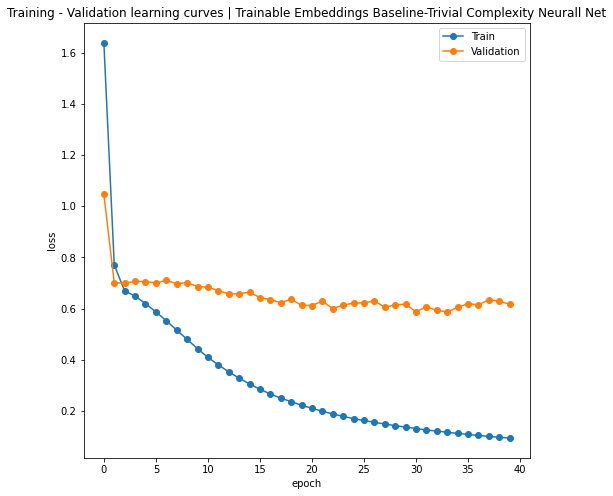

[I 2022-12-20 13:30:25,182] Trial 10 finished with value: 0.5871271544360909 and parameters: {'activation': 'Tanh', 'input_hidden_units': 38, 'embedding_dimension': 99, 'optimizer': 'RMSprop', 'lr': 0.0021641631922804335}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 55, padding_idx=0)
  (input_layer): Linear(in_features=8250, out_features=10, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 469,886 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.786
	 Val. Loss: 0.694

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.690
	 Val. Loss: 0.694

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.682
	 Val. Loss: 0.689

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.666
	 Val. Loss: 0.692

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.640
	 Val. Loss: 0.685

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.607
	 Val. Loss: 0.689

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.567
	 Val. Loss: 0.665

Epoch: 08 | Epoch 

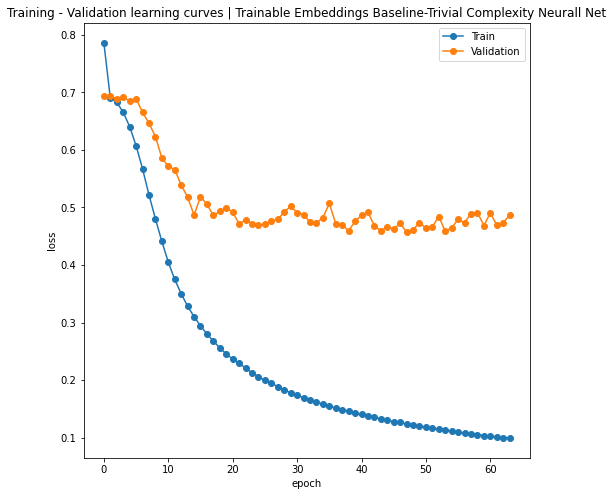

[I 2022-12-20 13:35:03,945] Trial 11 finished with value: 0.4568038397821887 and parameters: {'activation': 'Tanh', 'input_hidden_units': 10, 'embedding_dimension': 55, 'optimizer': 'RMSprop', 'lr': 0.003708745519473017}. Best is trial 5 with value: 0.37795125166403837.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 51, padding_idx=0)
  (input_layer): Linear(in_features=7650, out_features=30, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=30, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 588,754 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 0.826
	 Val. Loss: 0.696

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.673
	 Val. Loss: 0.657

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.553
	 Val. Loss: 0.535

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.423
	 Val. Loss: 0.445

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.348
	 Val. Loss: 0.424

Epoch: 06 | Epoch Time: 0m 4s
	Train Loss: 0.304
	 Val. Loss: 0.405

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.275
	 Val. Loss: 0.387

Epoch: 08 | Epoch 

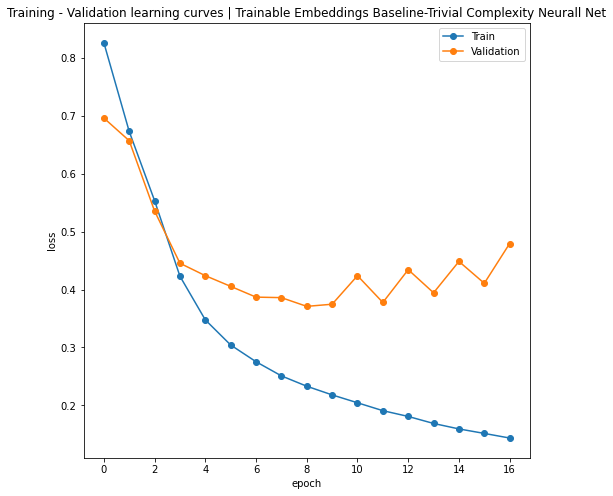

[I 2022-12-20 13:36:24,434] Trial 12 finished with value: 0.37092787335658894 and parameters: {'activation': 'Tanh', 'input_hidden_units': 30, 'embedding_dimension': 51, 'optimizer': 'RMSprop', 'lr': 0.009989406004988806}. Best is trial 12 with value: 0.37092787335658894.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 60, padding_idx=0)
  (input_layer): Linear(in_features=9000, out_features=32, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 710,645 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.763
	 Val. Loss: 0.698

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.657
	 Val. Loss: 0.643

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.512
	 Val. Loss: 0.506

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.401
	 Val. Loss: 0.461

Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.339
	 Val. Loss: 0.421

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.296
	 Val. Loss: 0.407

Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.269
	 Val. Loss: 0.416

Epoch: 08 | Epoch 

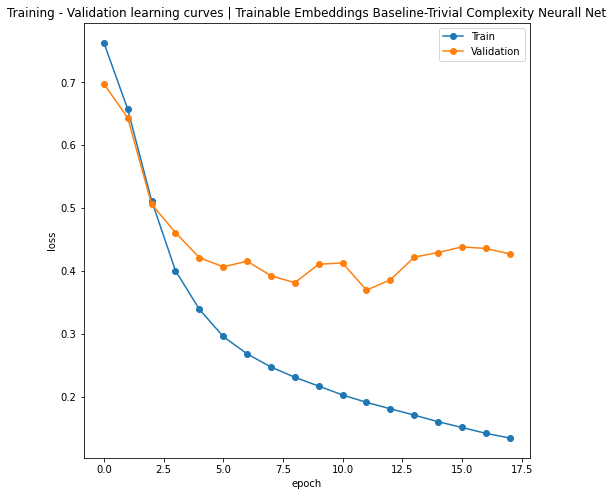

[I 2022-12-20 13:38:11,296] Trial 13 finished with value: 0.3698332407351198 and parameters: {'activation': 'Tanh', 'input_hidden_units': 32, 'embedding_dimension': 60, 'optimizer': 'RMSprop', 'lr': 0.009534858442699523}. Best is trial 13 with value: 0.3698332407351198.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 58, padding_idx=0)
  (input_layer): Linear(in_features=8700, out_features=66, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=66, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 982,827 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.052
	 Val. Loss: 0.693

Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.648
	 Val. Loss: 0.596

Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.474
	 Val. Loss: 0.468

Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.364
	 Val. Loss: 0.418

Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.306
	 Val. Loss: 0.388

Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.267
	 Val. Loss: 0.369

Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.240
	 Val. Loss: 0.377

Epoch: 08 | Epoch 

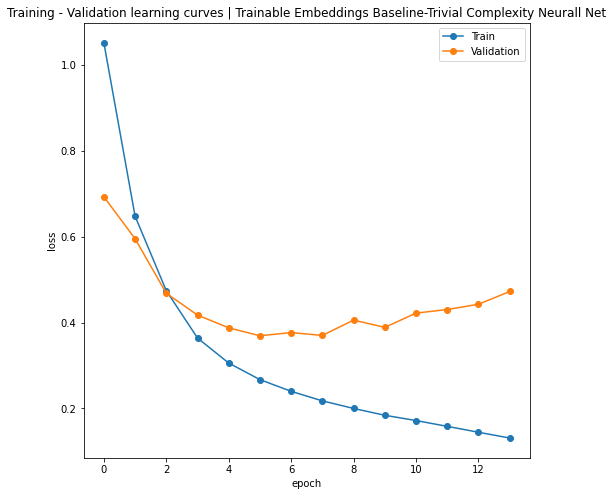

[I 2022-12-20 13:40:01,829] Trial 14 finished with value: 0.36935551310407705 and parameters: {'activation': 'Tanh', 'input_hidden_units': 66, 'embedding_dimension': 58, 'optimizer': 'RMSprop', 'lr': 0.009893477986778367}. Best is trial 14 with value: 0.36935551310407705.



 SentimentClassifier_trivial_model_complexity(
  (embedding): Embedding(7043, 68, padding_idx=0)
  (input_layer): Linear(in_features=10200, out_features=63, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (dropout_input_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(in_features=63, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 1,121,651 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 1.007
	 Val. Loss: 0.701

Epoch: 02 | Epoch Time: 0m 17s
	Train Loss: 0.669
	 Val. Loss: 0.658

Epoch: 03 | Epoch Time: 0m 18s
	Train Loss: 0.530
	 Val. Loss: 0.537

Epoch: 04 | Epoch Time: 0m 16s
	Train Loss: 0.397
	 Val. Loss: 0.455

Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.325
	 Val. Loss: 0.418

Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.279
	 Val. Loss: 0.424

Epoch: 07 | Epoch Time: 0m 16s
	Train Loss: 0.247
	 Val. Loss: 0.415

Epoch: 0

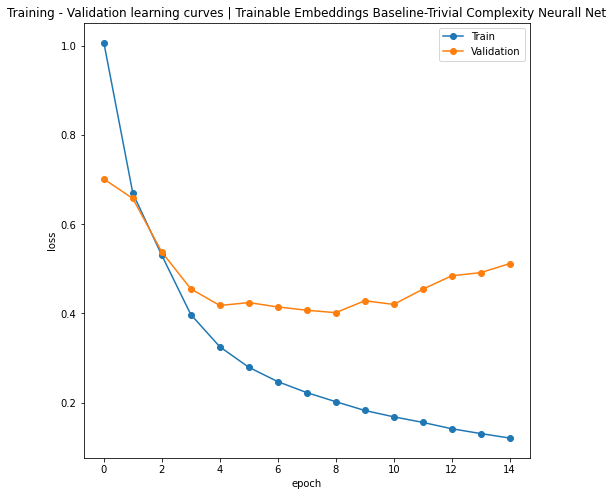

[I 2022-12-20 13:44:15,413] Trial 15 finished with value: 0.40165502590865926 and parameters: {'activation': 'Tanh', 'input_hidden_units': 63, 'embedding_dimension': 68, 'optimizer': 'RMSprop', 'lr': 0.008375467554572961}. Best is trial 14 with value: 0.36935551310407705.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "trainable"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings", sampler=optuna.samplers.TPESampler(seed=10), pruner=None)

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_baseline_trivial_complexity_nn_optuna.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_best_baseline_trivial_complexity_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_best_baseline_trivial_complexity_nn_optuna.pt")


Study statistics: 
  Number of finished trials:  16
  Number of pruned trials:    0
  Number of complete trials:  16

Best trial: 

Best model validation loss value: 0.36935551310407705

Best trial number: 14

Best model parameters: 

activation: Tanh

input_hidden_units: 66

embedding_dimension: 58

optimizer: RMSprop

lr: 0.009893477986778367


Evaluation metrics: Trainable Embeddings Baseline-Trivial Complexity Neural Net with Optuna 
Best parameters: | activation: Tanh | input_hidden_units: 66 | embedding_dimension: 58 | optimizer: RMSprop | lr: 0.009893477986778367 

precision score: 0.8498 
recall_score: 0.8300 
roc score: 0.8417 
f1_score: 0.8398

model bias: 0.0002
model variance: 0.2499


              precision    recall  f1-score   support

    negative       0.83      0.85      0.84       900
    positive       0.85      0.83      0.84       900

    accuracy                           0.84      1800
   macro avg       0.84      0.84      0.84      1800
weighted avg       0.84      0.84      0.84      1800





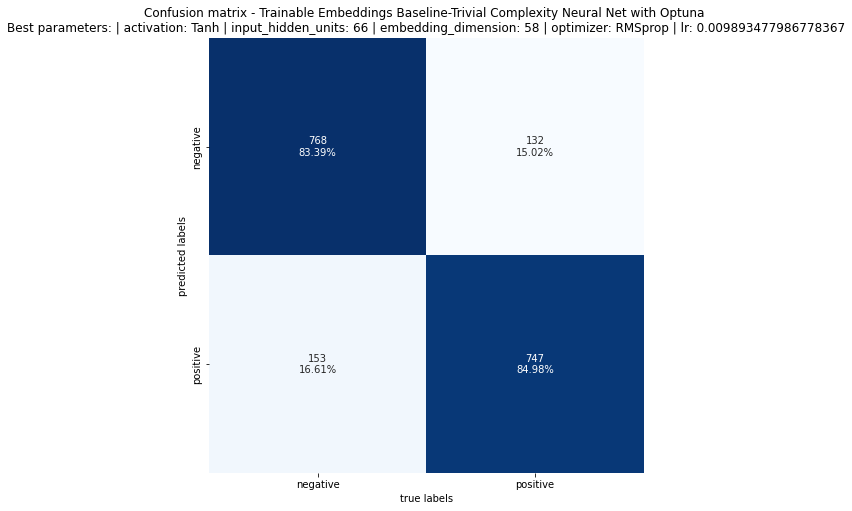

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "Trainable Embeddings Baseline-Trivial Complexity Neural Net with Optuna \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

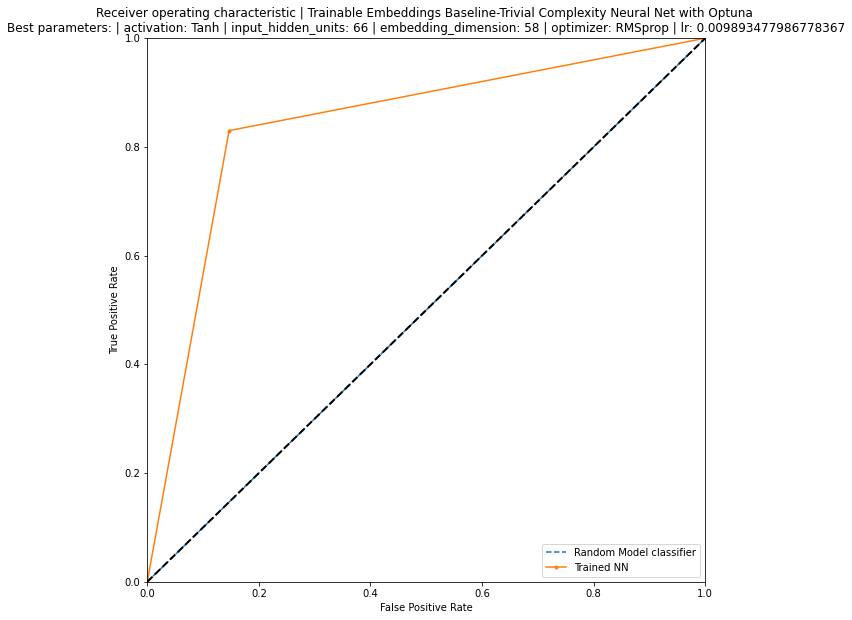

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Trivial complexity - GloVe embeddings

In [ ]:
class SentimentClassifier_trivial_model_complexity_glove(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor  
    super(SentimentClassifier_trivial_model_complexity_glove, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = non_contributive_token

    linear_hidden_units = trial.suggest_int("input_hidden_units", 8, 128)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    else:
      embedding_dimension = trial.suggest_int("embedding_dimension", 10, 100)
      self.embedding = nn.Embedding(vocab_size, embedding_dimension, padding_idx=padding_idx)
      self.embedding.weight.requires_grad = True
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension*vector_length, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    #Specify number of additional layers
    self.n_layers = 0

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim) #3*linear_hidden_units if three embeddings transformations are used.

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of output layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)

    self.apply(self._init_weights)

  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      module.weight.data.normal_(mean=0.0, std=1.0)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()

  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)

    else:
      embedded = self.flatten_layer(embedded)

    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    #input_layer = self.input_layer(embedded_average)
    input_layer = self.activation(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
def objective(trial):
  torch.manual_seed(123)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_trivial_model_complexity_glove(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vocab_size=len(glove_vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-3, 1e-2)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 150
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "trivial"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_three_embedding_transf_nn_optuna_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "Glove Embeddings Baseline-Trivial Complexity (3 Embedd Transf) Neural Net"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "trivial"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of classifier with embeddings: {embeddings_type} and complexity: {complexity_type}", sampler=optuna.samplers.TPESampler(seed=10), pruner=None)

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_three_embedding_transf_nn_optuna.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_three_embedding_transf_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_three_embedding_transf_nn_optuna.pt")

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Trivial Complexity Neural Net with Optuna (3-embedding transformations) \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced complexity - Trainable Embeddings

In [ ]:
class SentimentClassifier_advanced_complexity_optuna_v2(nn.Module):
  
  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):
  
    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_v2, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 64, 128)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    else:
      embedding_dimension = trial.suggest_int("embedding_dimension", 10, 100)
      self.embedding = nn.Embedding(vocab_size, embedding_dimension, padding_idx=padding_idx)
      self.embedding.weight.requires_grad = True
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(linear_hidden_units)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 64)
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
          self.layers.append(nn.BatchNorm1d(out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    self.activation_embeddings = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)
    embedded = torch.mean(embedded, dim=1)
    embedded = self.activation_embeddings(embedded)
    # embedded = self.flatten_layer(embedded)

    input_layer = self.input_layer(embedded)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
def objective(trial):
  torch.manual_seed(123)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_v2(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=False
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-3, 1e-2)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 150
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "trainable"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_V2_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "Trainable Embeddings Baseline-Trivial Complexity Neurall Net"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2022-12-21 12:52:45,277] A new study created in memory with name: hyper-parameter tuning of baseline classifier with trainable embeddings V2


  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-48-dc5aeb31538b>:35: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.25, 0.75)



 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 78, padding_idx=0)
  (input_layer): Linear(in_features=78, out_features=105, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(105, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4992535061512952, inplace=False)
  (output_layer): Linear(in_features=105, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
)

The model has 557,965 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.729
	 Val. Loss: 0.389

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.369
	 Val. Loss: 0.326

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 0.295
	 Val. Loss: 0.307

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.260
	 Val. Loss: 0.303

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.239
	 Val. Loss: 0.

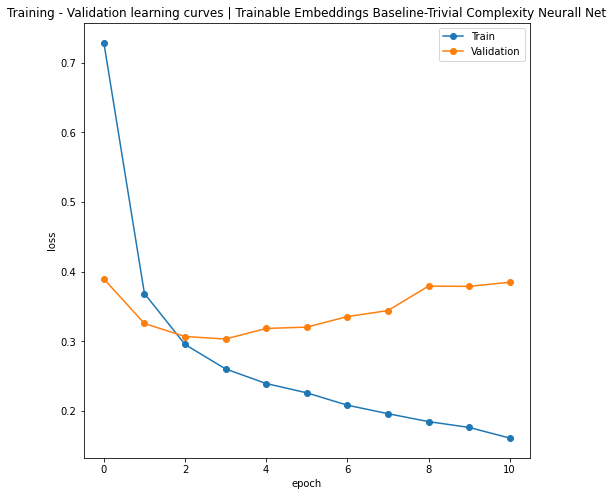

[I 2022-12-21 12:53:38,201] Trial 0 finished with value: 0.3032537303094206 and parameters: {'activation': 'ReLU', 'input_hidden_units': 105, 'embedding_dimension': 78, 'dropout_rate': 0.4992535061512952, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.0017950583275660925}. Best is trial 0 with value: 0.3032537303094206.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 56, padding_idx=0)
  (input_layer): Linear(in_features=56, out_features=64, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6563104808260567, inplace=False)
  (output_layer): Linear(in_features=24, out_features=1, bias=True)
  (activation): Tanh()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=64, out_features=49, bias=True)
  (fully_connected_layer_1): BatchNorm1d

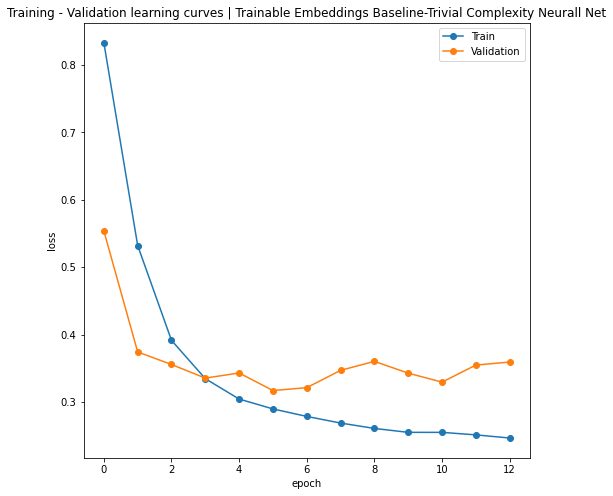

[I 2022-12-21 12:54:42,546] Trial 1 finished with value: 0.3169055740381109 and parameters: {'activation': 'Tanh', 'input_hidden_units': 64, 'embedding_dimension': 56, 'dropout_rate': 0.6563104808260567, 'n_layers': 2, 'n_units_hidden_layer_0': 49, 'n_units_hidden_layer_1': 24, 'optimizer': 'Adam', 'lr': 0.002279530428413743}. Best is trial 0 with value: 0.3032537303094206.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 49, padding_idx=0)
  (input_layer): Linear(in_features=49, out_features=92, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5588834892346586, inplace=False)
  (output_layer): Linear(in_features=42, out_features=1, bias=True)
  (activation): Tanh()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=92, out_features=

[I 2022-12-21 13:01:48,905] Trial 2 finished with value: 0.6421051128157254 and parameters: {'activation': 'Tanh', 'input_hidden_units': 92, 'embedding_dimension': 49, 'dropout_rate': 0.5588834892346586, 'n_layers': 2, 'n_units_hidden_layer_0': 45, 'n_units_hidden_layer_1': 42, 'optimizer': 'SGD', 'lr': 0.0038731248008969077}. Best is trial 0 with value: 0.3032537303094206.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 85, padding_idx=0)
  (input_layer): Linear(in_features=85, out_features=71, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(71, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.2734481596946249, inplace=False)
  (output_layer): Linear(in_features=54, out_features=1, bias=True)
  (activation): Tanh()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=71, out_features=

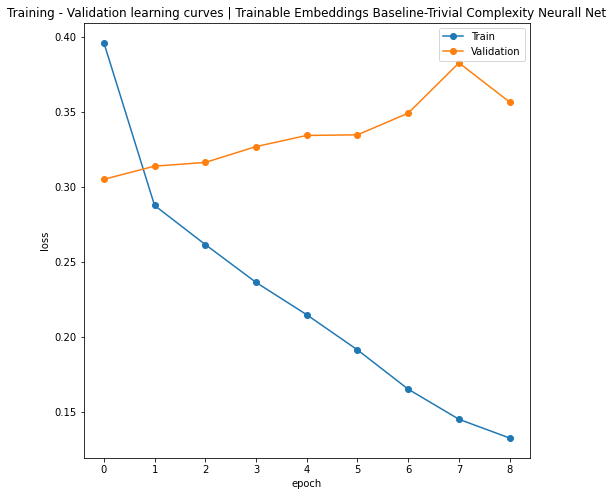

[I 2022-12-21 13:02:43,310] Trial 3 finished with value: 0.3049669240055413 and parameters: {'activation': 'Tanh', 'input_hidden_units': 71, 'embedding_dimension': 85, 'dropout_rate': 0.2734481596946249, 'n_layers': 2, 'n_units_hidden_layer_0': 39, 'n_units_hidden_layer_1': 54, 'optimizer': 'RMSprop', 'lr': 0.0077918292237687155}. Best is trial 0 with value: 0.3032537303094206.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 25, padding_idx=0)
  (input_layer): Linear(in_features=25, out_features=85, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(85, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.44626462197329364, inplace=False)
  (output_layer): Linear(in_features=85, out_features=1, bias=True)
  (activation): Tanh()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
)

The model has 178,541 trainable parameters

Calculating t

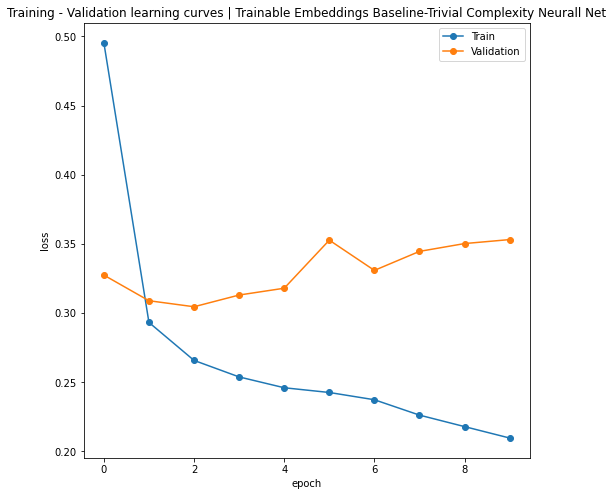

[I 2022-12-21 13:03:13,616] Trial 4 finished with value: 0.30456416013425797 and parameters: {'activation': 'Tanh', 'input_hidden_units': 85, 'embedding_dimension': 25, 'dropout_rate': 0.44626462197329364, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.009498346410149211}. Best is trial 0 with value: 0.3032537303094206.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 32, padding_idx=0)
  (input_layer): Linear(in_features=32, out_features=117, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(117, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5486858241154422, inplace=False)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=117, out_features=38, bias=True)
  (fully_connected_layer_1): BatchNorm1d

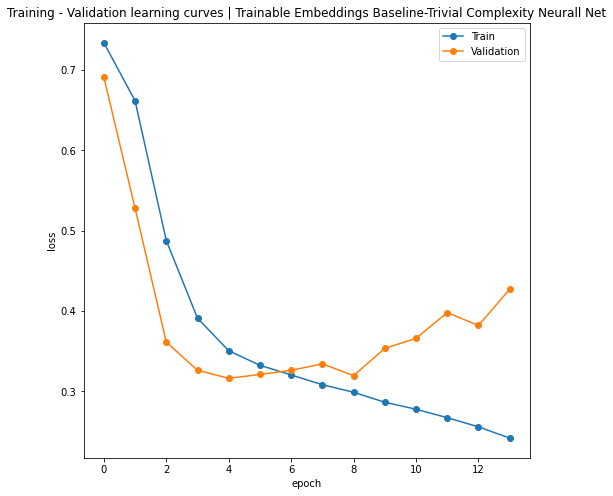

[I 2022-12-21 13:04:11,832] Trial 5 finished with value: 0.31636641919612885 and parameters: {'activation': 'ReLU', 'input_hidden_units': 117, 'embedding_dimension': 32, 'dropout_rate': 0.5486858241154422, 'n_layers': 3, 'n_units_hidden_layer_0': 38, 'n_units_hidden_layer_1': 41, 'n_units_hidden_layer_2': 10, 'optimizer': 'Adam', 'lr': 0.003976473807839188}. Best is trial 0 with value: 0.3032537303094206.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 38, padding_idx=0)
  (input_layer): Linear(in_features=38, out_features=91, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(91, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5682455715337723, inplace=False)
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Line

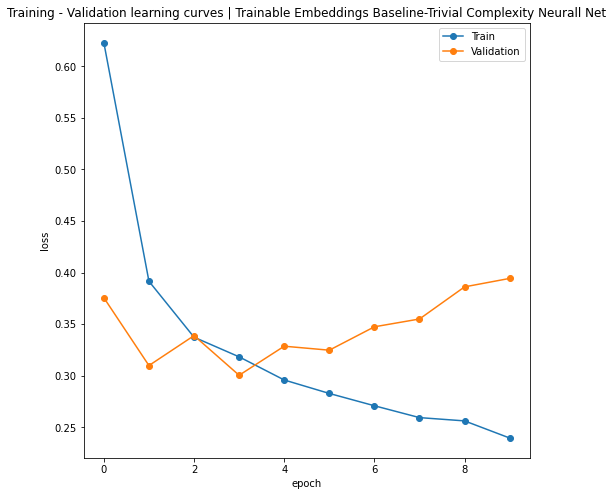

[I 2022-12-21 13:05:00,422] Trial 6 finished with value: 0.3003987914015507 and parameters: {'activation': 'ReLU', 'input_hidden_units': 91, 'embedding_dimension': 38, 'dropout_rate': 0.5682455715337723, 'n_layers': 1, 'n_units_hidden_layer_0': 10, 'optimizer': 'Adam', 'lr': 0.004757582294553403}. Best is trial 6 with value: 0.3003987914015507.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 33, padding_idx=0)
  (input_layer): Linear(in_features=33, out_features=102, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(102, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4004356544703536, inplace=False)
  (output_layer): Linear(in_features=102, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
)

The model has 236,194 trainable parameters

Calculating train/validation loss using: BCEL

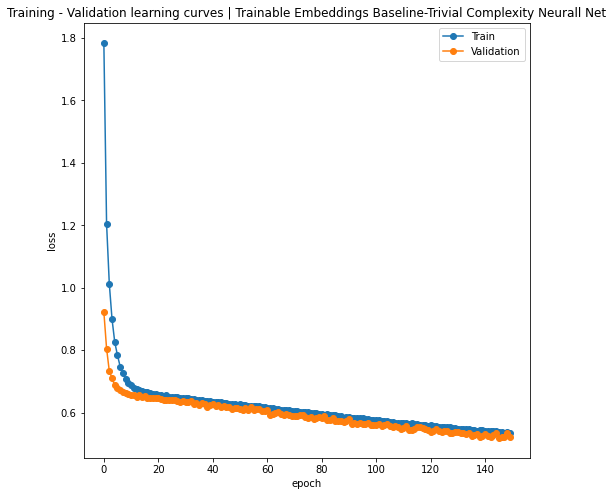

[I 2022-12-21 13:10:40,681] Trial 7 finished with value: 0.5182128630835434 and parameters: {'activation': 'ReLU', 'input_hidden_units': 102, 'embedding_dimension': 33, 'dropout_rate': 0.4004356544703536, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.0060895631789935085}. Best is trial 6 with value: 0.3003987914015507.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 99, padding_idx=0)
  (input_layer): Linear(in_features=99, out_features=68, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.41985392181893183, inplace=False)
  (output_layer): Linear(in_features=63, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=68, out_features=63, bias=True)
  (fully_connected_layer_1): BatchNorm1d(63

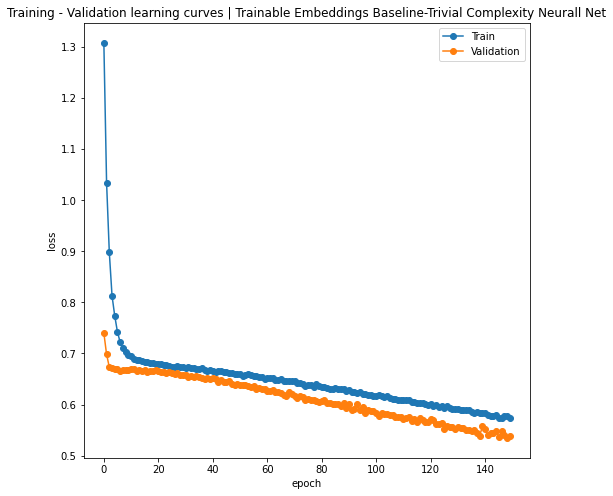

[I 2022-12-21 13:23:06,871] Trial 8 finished with value: 0.5344320011549982 and parameters: {'activation': 'ReLU', 'input_hidden_units': 68, 'embedding_dimension': 99, 'dropout_rate': 0.41985392181893183, 'n_layers': 1, 'n_units_hidden_layer_0': 63, 'optimizer': 'SGD', 'lr': 0.0062032278689422085}. Best is trial 6 with value: 0.3003987914015507.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 81, padding_idx=0)
  (input_layer): Linear(in_features=81, out_features=94, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(94, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6093014051911252, inplace=False)
  (output_layer): Linear(in_features=27, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=94, out_features=10, bias=True)
  (fully_conne

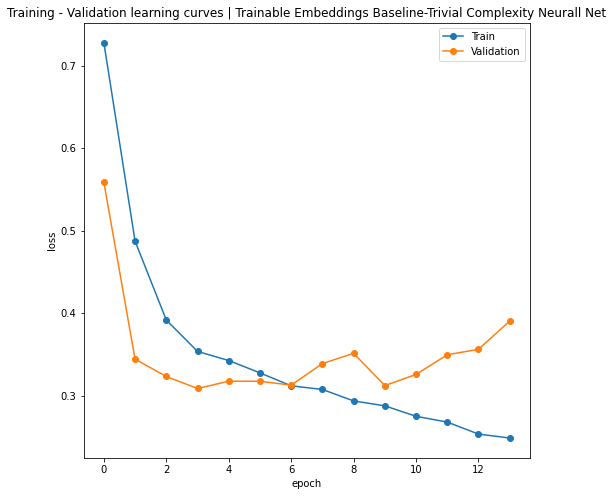

[I 2022-12-21 13:24:50,693] Trial 9 finished with value: 0.30852601779945965 and parameters: {'activation': 'ReLU', 'input_hidden_units': 94, 'embedding_dimension': 81, 'dropout_rate': 0.6093014051911252, 'n_layers': 2, 'n_units_hidden_layer_0': 10, 'n_units_hidden_layer_1': 27, 'optimizer': 'Adam', 'lr': 0.007061202327562486}. Best is trial 6 with value: 0.3003987914015507.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 11, padding_idx=0)
  (input_layer): Linear(in_features=11, out_features=127, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(127, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6734758924923008, inplace=False)
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=127, out_featur

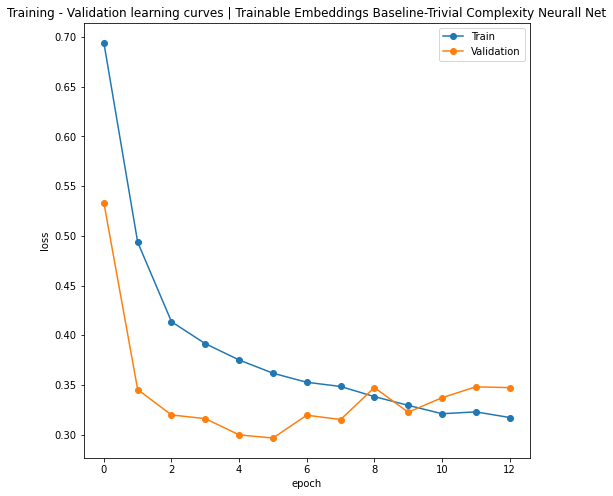

[I 2022-12-21 13:25:23,240] Trial 10 finished with value: 0.29654708170685273 and parameters: {'activation': 'ReLU', 'input_hidden_units': 127, 'embedding_dimension': 11, 'dropout_rate': 0.6734758924923008, 'n_layers': 1, 'n_units_hidden_layer_0': 8, 'optimizer': 'Adam', 'lr': 0.004264807181304434}. Best is trial 10 with value: 0.29654708170685273.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 10, padding_idx=0)
  (input_layer): Linear(in_features=10, out_features=126, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(126, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7346070544861476, inplace=False)
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=126, out_features=8, bias=True)
  (fully_c

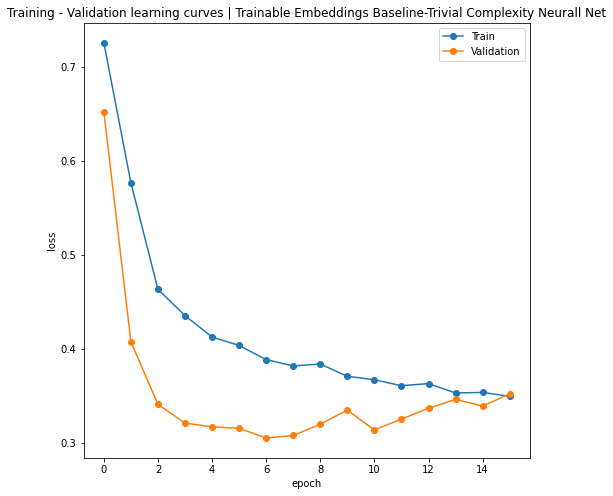

[I 2022-12-21 13:26:02,599] Trial 11 finished with value: 0.30517122714683925 and parameters: {'activation': 'ReLU', 'input_hidden_units': 126, 'embedding_dimension': 10, 'dropout_rate': 0.7346070544861476, 'n_layers': 1, 'n_units_hidden_layer_0': 8, 'optimizer': 'Adam', 'lr': 0.004194210202045611}. Best is trial 10 with value: 0.29654708170685273.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 16, padding_idx=0)
  (input_layer): Linear(in_features=16, out_features=81, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(81, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7215856295510668, inplace=False)
  (output_layer): Linear(in_features=22, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=81, out_features=22, bias=True)
  (fully_co

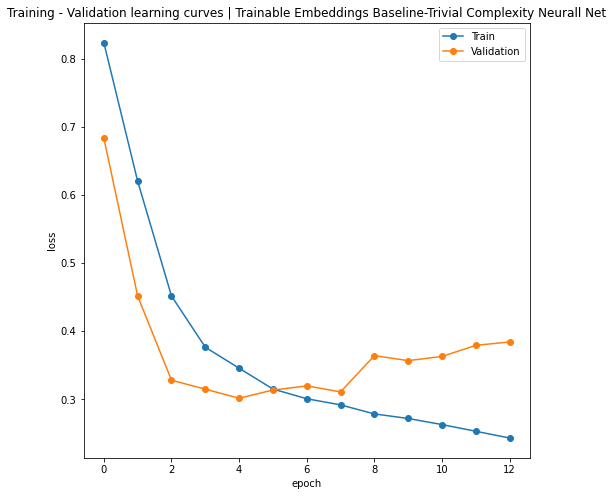

[I 2022-12-21 13:26:39,504] Trial 12 finished with value: 0.3015317305408675 and parameters: {'activation': 'ReLU', 'input_hidden_units': 81, 'embedding_dimension': 16, 'dropout_rate': 0.7215856295510668, 'n_layers': 1, 'n_units_hidden_layer_0': 22, 'optimizer': 'Adam', 'lr': 0.004515643831889767}. Best is trial 10 with value: 0.29654708170685273.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 48, padding_idx=0)
  (input_layer): Linear(in_features=48, out_features=112, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6496842446007907, inplace=False)
  (output_layer): Linear(in_features=17, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=112, out_features=17, bias=True)
  (fully_

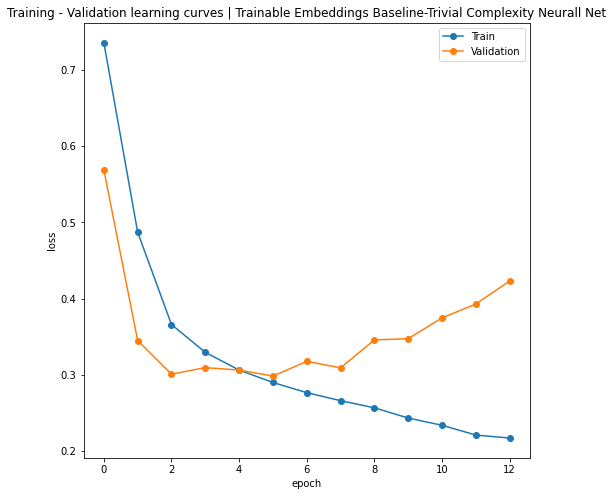

[I 2022-12-21 13:27:48,003] Trial 13 finished with value: 0.29844830930233 and parameters: {'activation': 'ReLU', 'input_hidden_units': 112, 'embedding_dimension': 48, 'dropout_rate': 0.6496842446007907, 'n_layers': 1, 'n_units_hidden_layer_0': 17, 'optimizer': 'Adam', 'lr': 0.0030186091861999793}. Best is trial 10 with value: 0.29654708170685273.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 62, padding_idx=0)
  (input_layer): Linear(in_features=62, out_features=128, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6615916304280914, inplace=False)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=128, out_features=24, bias=True)
  (fully_

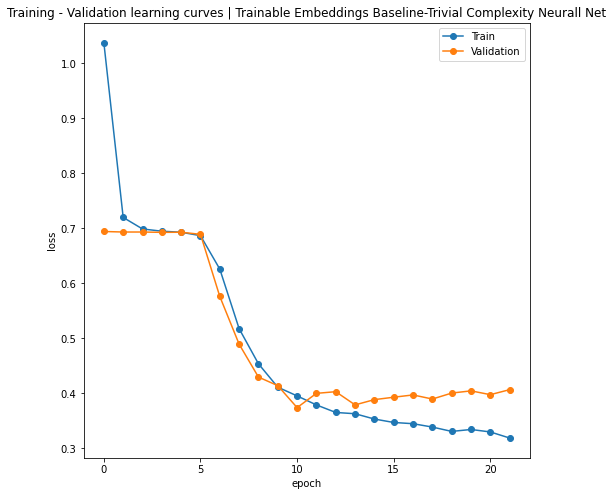

[I 2022-12-21 13:30:18,444] Trial 14 finished with value: 0.3742428673752423 and parameters: {'activation': 'ReLU', 'input_hidden_units': 128, 'embedding_dimension': 62, 'dropout_rate': 0.6615916304280914, 'n_layers': 3, 'n_units_hidden_layer_0': 24, 'n_units_hidden_layer_1': 9, 'n_units_hidden_layer_2': 64, 'optimizer': 'Adam', 'lr': 0.002704561728453894}. Best is trial 10 with value: 0.29654708170685273.

 SentimentClassifier_advanced_complexity_optuna_v2(
  (embedding): Embedding(7043, 45, padding_idx=0)
  (input_layer): Linear(in_features=45, out_features=114, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(114, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.661571636130258, inplace=False)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
  (activation): ReLU()
  (activation_embeddings): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Li

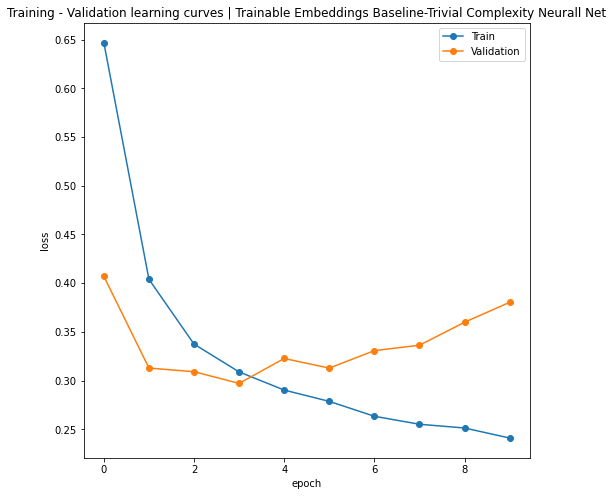

[I 2022-12-21 13:31:04,867] Trial 15 finished with value: 0.29717555064065704 and parameters: {'activation': 'ReLU', 'input_hidden_units': 114, 'embedding_dimension': 45, 'dropout_rate': 0.661571636130258, 'n_layers': 1, 'n_units_hidden_layer_0': 20, 'optimizer': 'RMSprop', 'lr': 0.0031020589503459595}. Best is trial 10 with value: 0.29654708170685273.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of {complexity_type} complexity classifier with {embeddings_type} embeddings V2", sampler=optuna.samplers.TPESampler(seed=10), pruner=None)

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_advanced_complexity_nn_optuna_v2.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_best_advanced_complexity_study_optuna_v2.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_best_advanced_complexity_nn_optuna_v2.pt")


Study statistics: 
  Number of finished trials:  16
  Number of pruned trials:    0
  Number of complete trials:  16

Best trial: 

Best model validation loss value: 0.29654708170685273

Best trial number: 10

Best model parameters: 

activation: ReLU

input_hidden_units: 127

embedding_dimension: 11

dropout_rate: 0.6734758924923008

n_layers: 1

n_units_hidden_layer_0: 8

optimizer: Adam

lr: 0.004264807181304434


Evaluation metrics: Trainable Embeddings Advanced Complexity Neural Net with Optuna V2 
Best parameters: | activation: ReLU | input_hidden_units: 127 | embedding_dimension: 11 | dropout_rate: 0.6734758924923008 | n_layers: 1 | n_units_hidden_layer_0: 8 | optimizer: Adam | lr: 0.004264807181304434 

precision score: 0.8573 
recall_score: 0.8678 
roc score: 0.8617 
f1_score: 0.8625

model bias: 0.0
model variance: 0.25


              precision    recall  f1-score   support

    negative       0.87      0.86      0.86       900
    positive       0.86      0.87      0.86       900

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86      0.86      1800





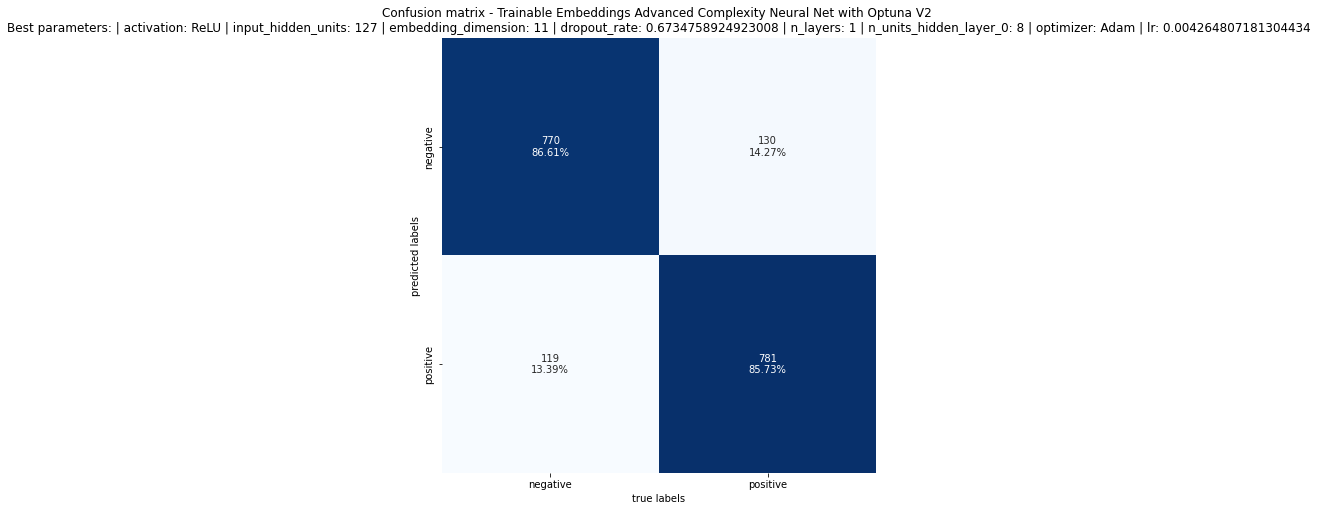

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "Trainable Embeddings Advanced Complexity Neural Net with Optuna V2 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

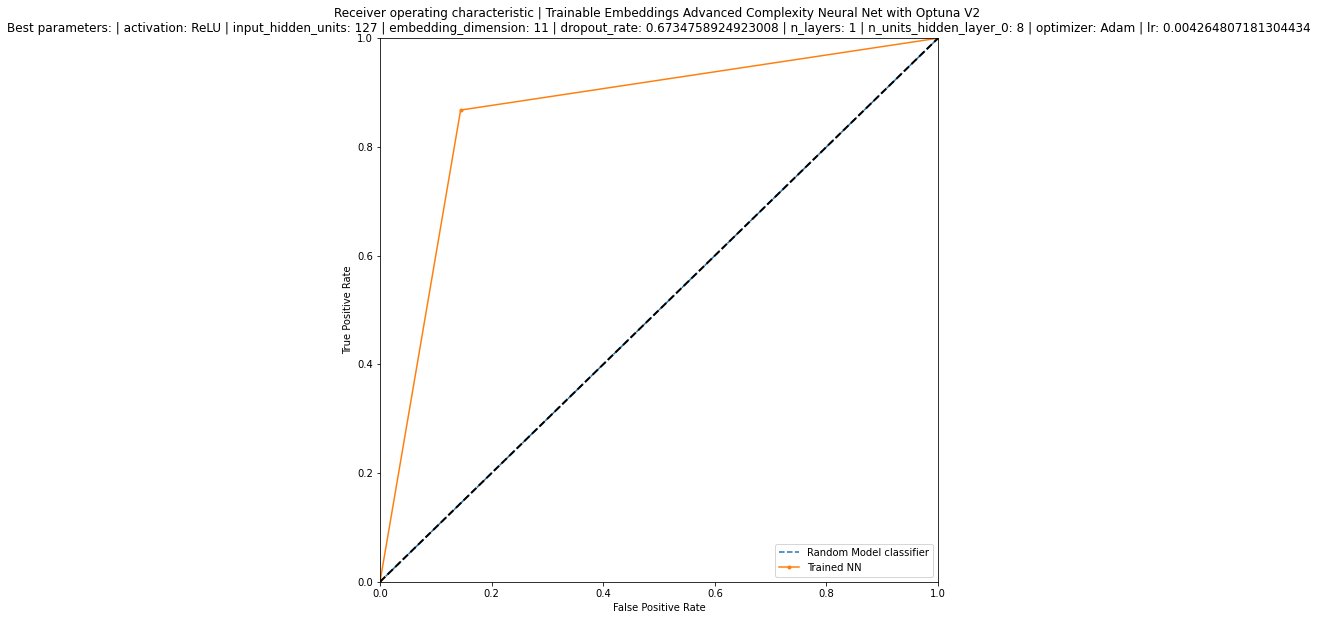

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced complexity - Glove Embeddings

In [ ]:
class SentimentClassifier_advanced_complexity_optuna_glove(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings

    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
          self.layers.append(nn.BatchNorm1d(out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

    #   initrange = 1.0

  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()

  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()

  def forward(self, text):

    #embedded = self.embedding[text].reshape(text.size()[0], -1) - if option 1, for constructing the embedding layer, is used
    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)

    #use of average embeddings transformation
    input_layer = self.input_layer(embedded_average)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
def objective(trial):
  torch.manual_seed(1122)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vocab_size=len(glove_vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-3, 1e-2)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 150
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(
    direction="minimize", 
    study_name=f"hyper-parameter tuning of {complexity_type} complexity classifier with {embeddings_type} embeddings",
    sampler=optuna.samplers.TPESampler(seed=1122),
    pruner=optuna.pruners.MedianPruner()
  )

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna.txt", "w")
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_advanced_complexity_study_optuna.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_advanced_complexity_nn_optuna.pt")

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced Complexity model with GloVe Embeddings v2

- Slight increase in hidden layer units per linear layer. From [64,128] to [128, 256] and from [8,64] to [8,128]
- Increased total words per sentence from 150 to 235 (represents 90% of the length of all sentences in the sample).
- Added weight decay (l2 penalty)

In [ ]:
class SentimentClassifier_advanced_complexity_optuna_glove_v2(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v2, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    if isinstance(module, nn.Linear):
      module.weight.data.normal_(mean=0.0, std=1.0)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      module.weight.data.normal_(mean=0.0, std=1.0)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    #embedded = self.embedding[text].reshape(text.size()[0], -1) - if option 1, for constructing the embedding layer, is used
    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
def objective(trial):
  torch.manual_seed(123)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v2(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vocab_size=len(glove_vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-3, 1e-2)
  weight_decay = trial.suggest_float('wd', 0, 0.1)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 100
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v2_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v2", sampler=optuna.samplers.TPESampler(seed=10), pruner=optuna.pruners.MedianPruner())

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v2.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v2.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v2.pt")

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna V2 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced Complexity model with GloVe embeddings v3

- After each mathematical transformation of the embedding layers, I passed each embedding layer through the activation function ```Tanh()```.

In [ ]:
class SentimentClassifier_advanced_complexity_optuna_glove_v3(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v3, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    self.activation_embeddings = nn.Tanh()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_average = self.activation_embeddings(embedded_average)

      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_max = self.activation_embeddings(embedded_max)

      embedded_min = torch.min(embedded, dim=1)[0]
      embedded_min = self.activation_embeddings(embedded_min)

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
def objective(trial):
  torch.manual_seed(1234)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v3(
    trial,
    non_contributive_token=glove_vocab[unk_token],
    vocab_size=len(glove_vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 5e-4, 1e-2)
  weight_decay = trial.suggest_float('wd', 0, 0.1)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 100
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v3_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net v3"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v3", sampler=optuna.samplers.TPESampler(seed=123), pruner=optuna.pruners.MedianPruner())

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v3.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v3.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v3.pt")

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna v3 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced Complexity model with GloVe embeddings v4

- GloVe Embeddings with 100 dimension size and pre-trained on 6B words.
- 150 words per sentence
- 128 training batch size

In [60]:
class SentimentClassifier_advanced_complexity_optuna_glove_v4(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v4, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
          self.layers.append(nn.BatchNorm1d(out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    self.activation_embeddings = nn.Tanh()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      # embedded_average = self.activation_embeddings(embedded_average)

    #use of average embeddings transformation
    input_layer = self.input_layer(embedded_average)

    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
random_seed = 12345

def objective(trial, vocab, vectors = None):
  """
  Definition
  ---------
  The objective function used by Optuna framework for every trial of different model hyper-parameters.

  Arguments
  ---------
  trial: The Optuna trial with a different sent of hyper-parameters on each run. A trial has a training progress equal to a number of epochs set by the user.
  vocab: The vocabulary object containing words from the corpus or glove pre-trained words.
  vectors: The vectors matrix. In the case of GloVe embeddings this is the the matrix with the pre-trained weights per word/token.
           In the case of trainable weigths this is None because the matrix is trained and updated after each batch with new weights.

  Output
  ---------
  The validation loss with the lowest value during the epoch training.
  For example, if on epoch 10 we had the lowest validation loss and on epoch 15 the training stopped (from the early stop mechanism),
    due to higher validation losses then the validation loss of epoch 15 is returned.
  """
  torch.manual_seed(random_seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v4(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=vectors.vectors,
    embedding_dimension=vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 5e-4, 1e-2)
  weight_decay = trial.suggest_float('wd', 0, 0.1)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 50
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v4_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\t Val. Loss: {valid_loss:.5f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net v4"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2022-12-29 09:18:56,053] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove embeddings v4
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/16 [00:00<?, ?it/s]


 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=151, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(151, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.35228013927651985, inplace=False)
  (output_layer): Linear(in_features=124, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=151, out_features=80, bias=True)
  (fully_connected_layer_1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected_layer_2): ReLU()
  (fully_connected_layer_3): Dropout(p=0.35228013927651985, inplace=False)
  (fully_connected_layer_4): Linear(in_features=80, out_features=124, bias=True)
  (fully_connected_layer_5): BatchNorm1d(124, 

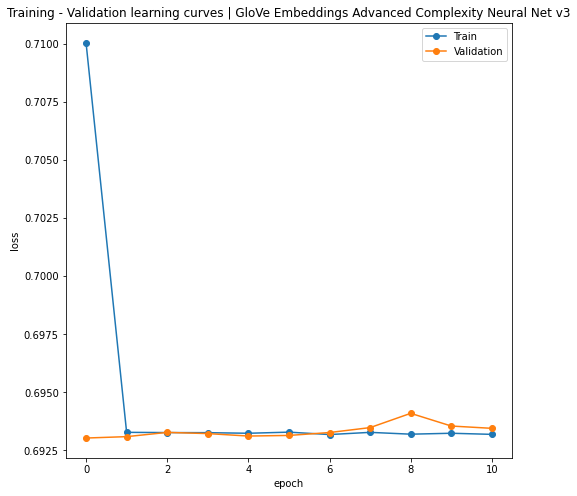

[I 2022-12-29 09:20:29,364] Trial 0 finished with value: 0.6930334259723795 and parameters: {'activation': 'ReLU', 'input_hidden_units': 151, 'dropout_rate': 0.35228013927651985, 'n_layers': 2, 'n_units_hidden_layer_0': 80, 'n_units_hidden_layer_1': 124, 'optimizer': 'RMSprop', 'lr': 0.007603290688077101, 'wd': 0.09613067360728214}. Best is trial 0 with value: 0.6930334259723795.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=166, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(166, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.578205591541135, inplace=False)
  (output_layer): Linear(in_features=95, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=

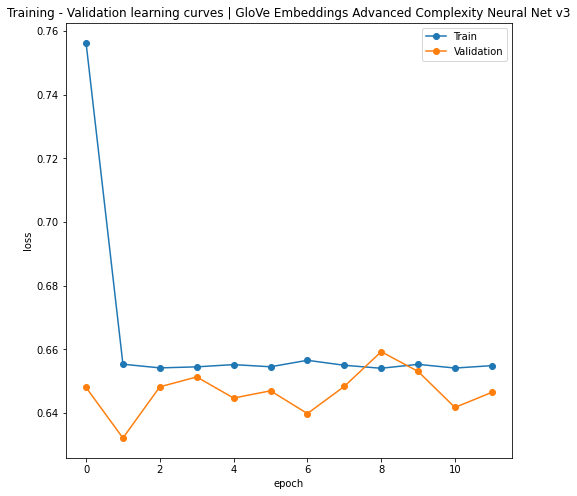

[I 2022-12-29 09:21:20,629] Trial 1 finished with value: 0.6321765102189163 and parameters: {'activation': 'Tanh', 'input_hidden_units': 166, 'dropout_rate': 0.578205591541135, 'n_layers': 3, 'n_units_hidden_layer_0': 113, 'n_units_hidden_layer_1': 124, 'n_units_hidden_layer_2': 95, 'optimizer': 'RMSprop', 'lr': 0.003593054436624089, 'wd': 0.04396446058848095}. Best is trial 1 with value: 0.6321765102189163.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=215, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(215, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6454112589238943, inplace=False)
  (output_layer): Linear(in_features=215, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
)

The model has 

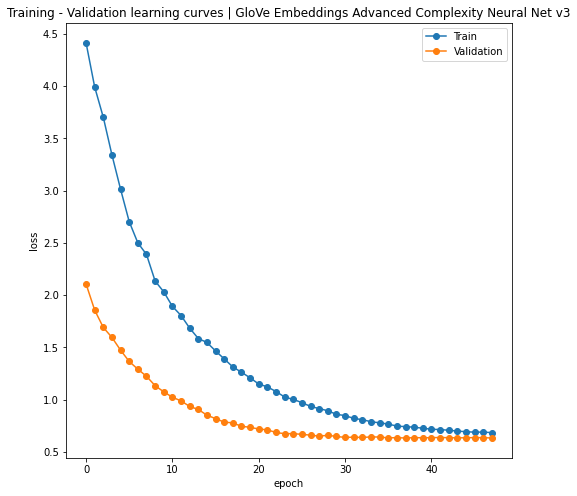

[I 2022-12-29 09:23:01,920] Trial 2 finished with value: 0.6334799877528486 and parameters: {'activation': 'Tanh', 'input_hidden_units': 215, 'dropout_rate': 0.6454112589238943, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.0007344239990780201, 'wd': 0.04917473184458859}. Best is trial 1 with value: 0.6321765102189163.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=134, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(134, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6975447640269605, inplace=False)
  (output_layer): Linear(in_features=68, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=134, out_features=107, bias=True)
  (fully_connected_layer_1): B

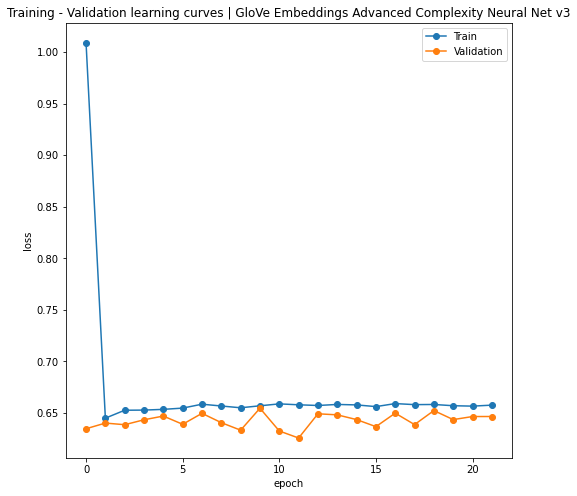

[I 2022-12-29 09:24:50,602] Trial 3 finished with value: 0.6256930930861111 and parameters: {'activation': 'Tanh', 'input_hidden_units': 134, 'dropout_rate': 0.6975447640269605, 'n_layers': 2, 'n_units_hidden_layer_0': 107, 'n_units_hidden_layer_1': 68, 'optimizer': 'Adam', 'lr': 0.002957831085229569, 'wd': 0.04681057539529352}. Best is trial 3 with value: 0.6256930930861111.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=150, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.515724942179817, inplace=False)
  (output_layer): Linear(in_features=150, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
)

The model has 15,601 trainable parameters

Calcu

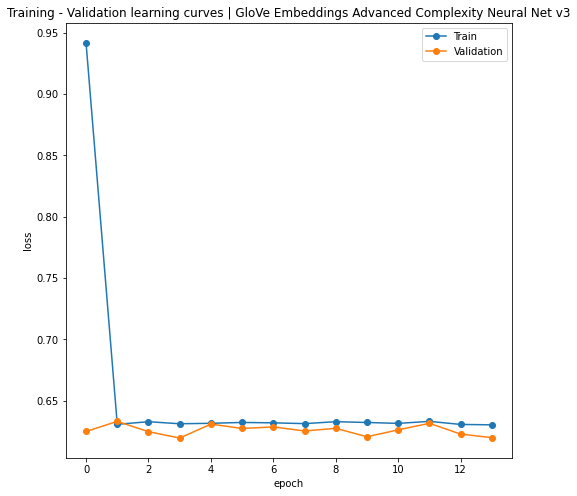

[I 2022-12-29 09:25:46,534] Trial 4 finished with value: 0.6195992354688973 and parameters: {'activation': 'Tanh', 'input_hidden_units': 150, 'dropout_rate': 0.515724942179817, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.0019267431993543762, 'wd': 0.048962670369399545}. Best is trial 4 with value: 0.6195992354688973.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=245, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(245, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.44192436057864426, inplace=False)
  (output_layer): Linear(in_features=76, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=245, out_features=76, bias=True)
  (fully_connected_layer_1

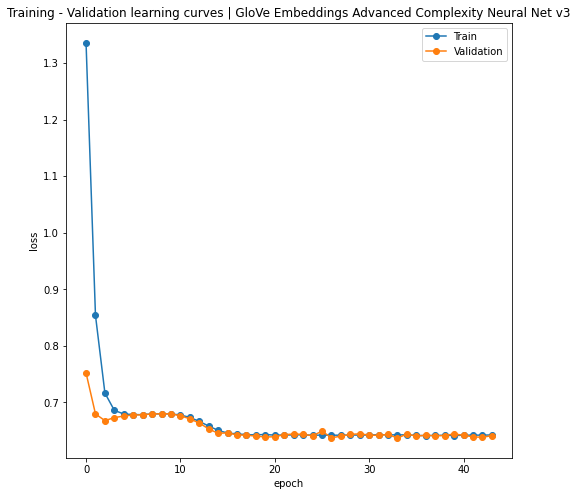

[I 2022-12-29 09:27:32,902] Trial 5 finished with value: 0.6371179120293979 and parameters: {'activation': 'Tanh', 'input_hidden_units': 245, 'dropout_rate': 0.44192436057864426, 'n_layers': 1, 'n_units_hidden_layer_0': 76, 'optimizer': 'SGD', 'lr': 0.008096263820500318, 'wd': 0.05735365651986432}. Best is trial 4 with value: 0.6195992354688973.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=242, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(242, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.49770737937873216, inplace=False)
  (output_layer): Linear(in_features=94, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=242, out_features=94, bias=True)


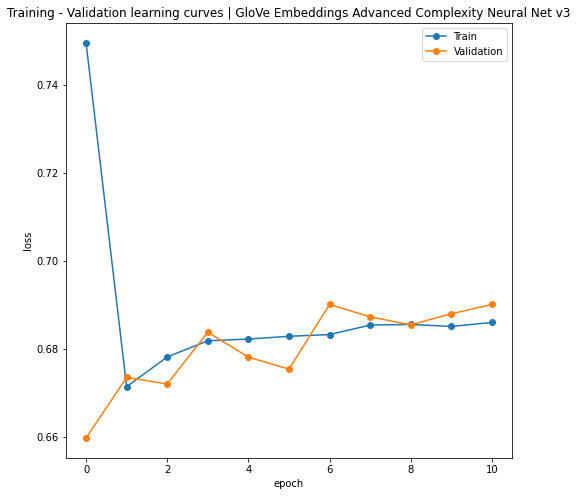

[I 2022-12-29 09:28:54,171] Trial 6 finished with value: 0.6597242643093241 and parameters: {'activation': 'ReLU', 'input_hidden_units': 242, 'dropout_rate': 0.49770737937873216, 'n_layers': 1, 'n_units_hidden_layer_0': 94, 'optimizer': 'Adam', 'lr': 0.008031606650471111, 'wd': 0.04951724145113691}. Best is trial 4 with value: 0.6195992354688973.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=196, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.37624629727871334, inplace=False)
  (output_layer): Linear(in_features=68, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=196, out_features=52, bias=True)

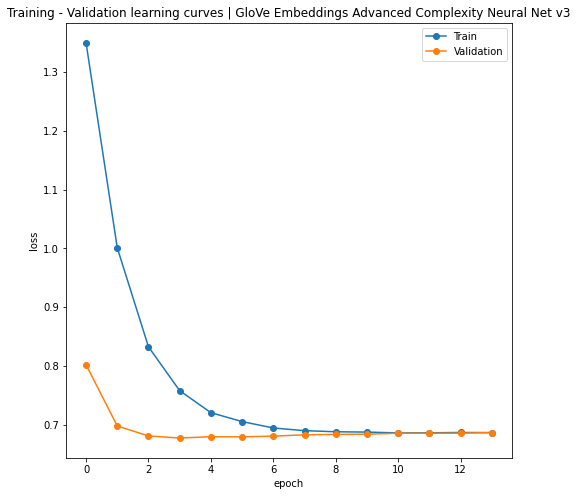

[I 2022-12-29 09:29:30,307] Trial 7 finished with value: 0.6774562638381432 and parameters: {'activation': 'Tanh', 'input_hidden_units': 196, 'dropout_rate': 0.37624629727871334, 'n_layers': 2, 'n_units_hidden_layer_0': 52, 'n_units_hidden_layer_1': 68, 'optimizer': 'SGD', 'lr': 0.003472862505398944, 'wd': 0.07687354471693397}. Best is trial 4 with value: 0.6195992354688973.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=250, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3036614561005221, inplace=False)
  (output_layer): Linear(in_features=116, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=250

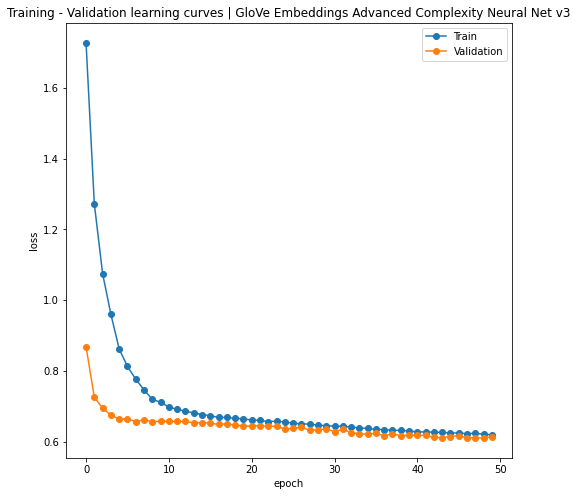

[I 2022-12-29 09:32:14,272] Trial 8 finished with value: 0.6102924686053703 and parameters: {'activation': 'Tanh', 'input_hidden_units': 250, 'dropout_rate': 0.3036614561005221, 'n_layers': 3, 'n_units_hidden_layer_0': 48, 'n_units_hidden_layer_1': 107, 'n_units_hidden_layer_2': 116, 'optimizer': 'SGD', 'lr': 0.0064564988654333254, 'wd': 0.008622310512275211}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=216, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(216, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6783129053949444, inplace=False)
  (output_layer): Linear(in_features=94, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_

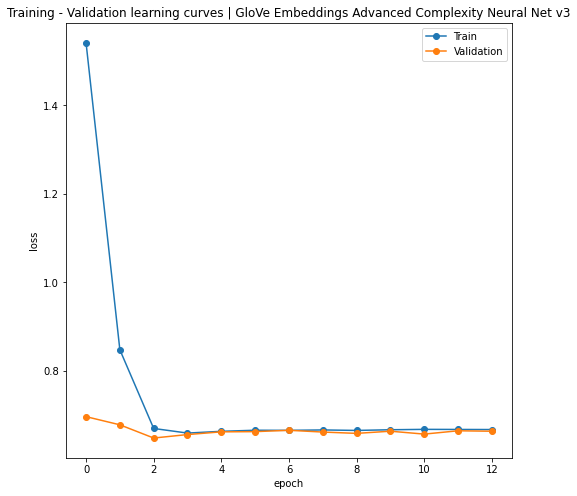

[I 2022-12-29 09:32:59,167] Trial 9 finished with value: 0.6490095504399004 and parameters: {'activation': 'Tanh', 'input_hidden_units': 216, 'dropout_rate': 0.6783129053949444, 'n_layers': 2, 'n_units_hidden_layer_0': 78, 'n_units_hidden_layer_1': 94, 'optimizer': 'RMSprop', 'lr': 0.0006949478342387641, 'wd': 0.09596610139968159}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=252, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(252, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.2581779879806315, inplace=False)
  (output_layer): Linear(in_features=127, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features

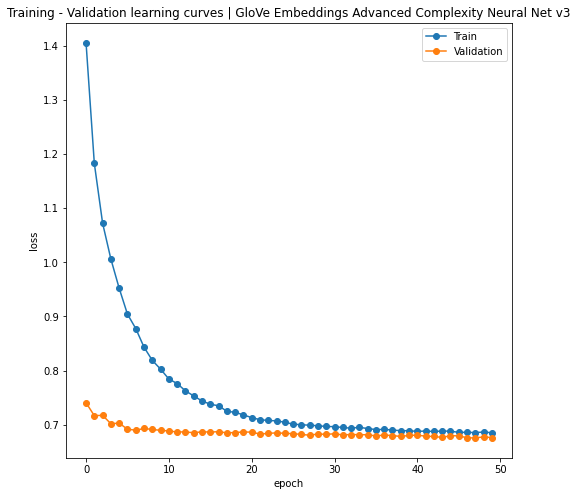

[I 2022-12-29 09:35:19,972] Trial 10 finished with value: 0.6752713075999556 and parameters: {'activation': 'ReLU', 'input_hidden_units': 252, 'dropout_rate': 0.2581779879806315, 'n_layers': 3, 'n_units_hidden_layer_0': 12, 'n_units_hidden_layer_1': 19, 'n_units_hidden_layer_2': 127, 'optimizer': 'SGD', 'lr': 0.00593428837792367, 'wd': 6.69573763313943e-05}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=176, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5592519559347024, inplace=False)
  (output_layer): Linear(in_features=176, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
)

The model has 18,

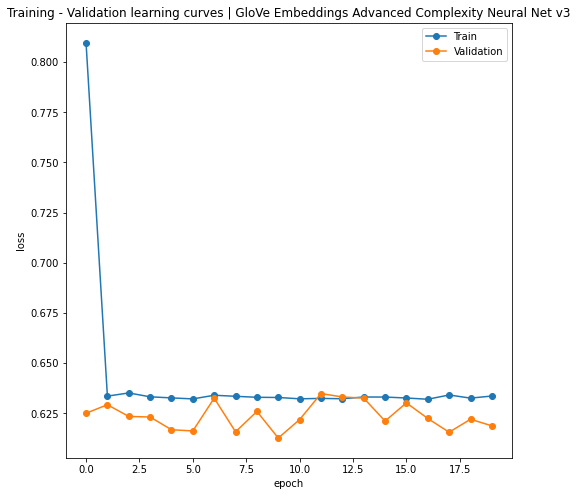

[I 2022-12-29 09:36:16,558] Trial 11 finished with value: 0.6126616812985519 and parameters: {'activation': 'Tanh', 'input_hidden_units': 176, 'dropout_rate': 0.5592519559347024, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.005978415474883645, 'wd': 0.007860599046733745}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=179, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(179, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.2933831948853626, inplace=False)
  (output_layer): Linear(in_features=179, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
)

The model has 18,617 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 0

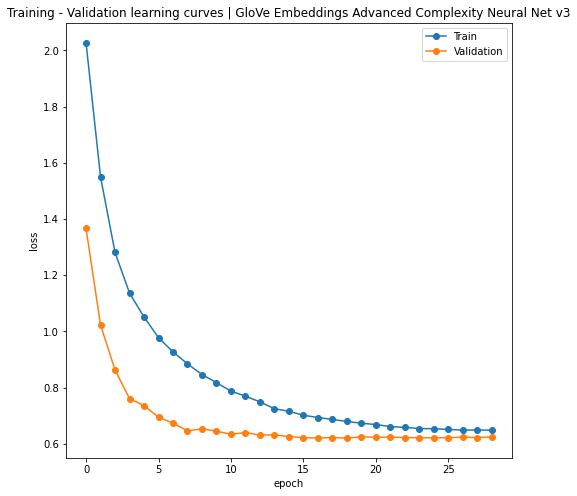

[I 2022-12-29 09:37:17,923] Trial 12 finished with value: 0.6208467010794014 and parameters: {'activation': 'Tanh', 'input_hidden_units': 179, 'dropout_rate': 0.2933831948853626, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.0054976055450373035, 'wd': 0.0019349996929126081}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=206, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(206, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5694956013987236, inplace=False)
  (output_layer): Linear(in_features=34, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=206, out_features=34, bias=True)
  (fully_connected_layer_1):

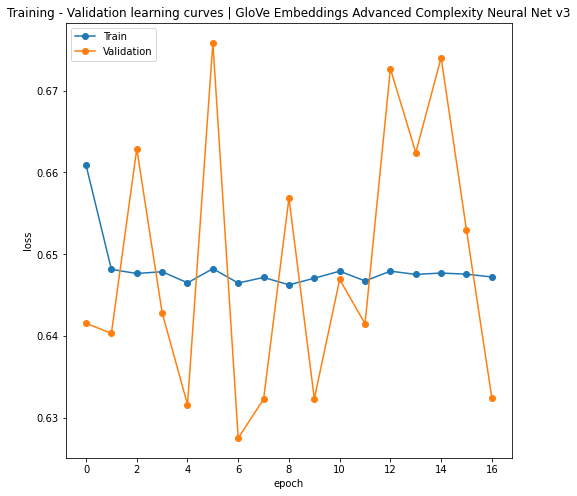

[I 2022-12-29 09:38:03,191] Trial 13 finished with value: 0.627524321449214 and parameters: {'activation': 'Tanh', 'input_hidden_units': 206, 'dropout_rate': 0.5694956013987236, 'n_layers': 1, 'n_units_hidden_layer_0': 34, 'optimizer': 'RMSprop', 'lr': 0.009523823406294644, 'wd': 0.021552736836869778}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=227, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(227, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.42186846874205836, inplace=False)
  (output_layer): Linear(in_features=45, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_layer_0): Linear(in_features=227, out_features=43, bias=Tr

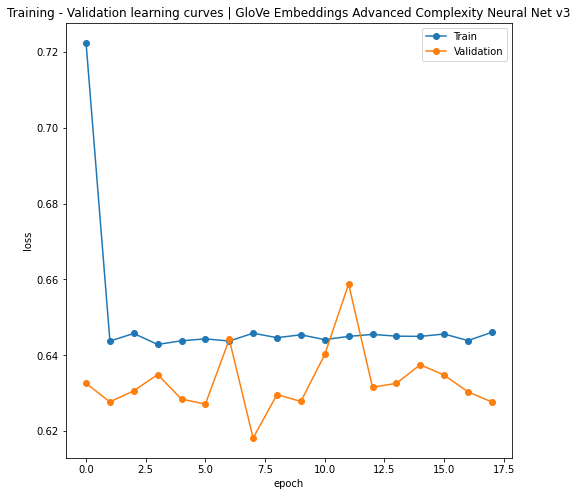

[I 2022-12-29 09:39:46,379] Trial 14 finished with value: 0.6181420396114218 and parameters: {'activation': 'Tanh', 'input_hidden_units': 227, 'dropout_rate': 0.42186846874205836, 'n_layers': 3, 'n_units_hidden_layer_0': 43, 'n_units_hidden_layer_1': 95, 'n_units_hidden_layer_2': 45, 'optimizer': 'Adam', 'lr': 0.006660992017622213, 'wd': 0.02009817874921286}. Best is trial 8 with value: 0.6102924686053703.

 SentimentClassifier_advanced_complexity_optuna_glove_v4(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=181, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(181, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6058434112526934, inplace=False)
  (output_layer): Linear(in_features=9, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (activation_embeddings): Tanh()
  (fully_connected_la

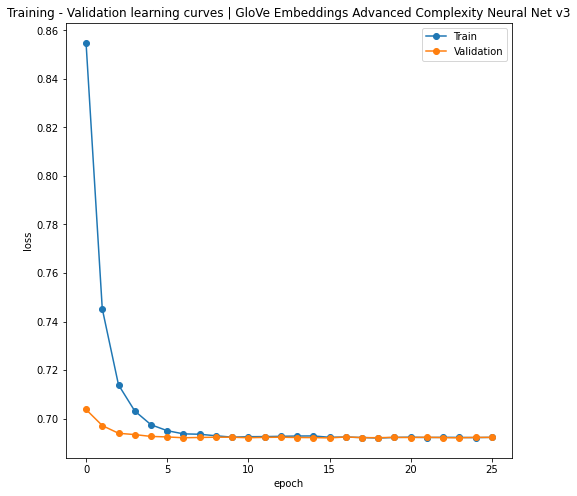

[I 2022-12-29 09:40:56,851] Trial 15 finished with value: 0.6920585796750826 and parameters: {'activation': 'ReLU', 'input_hidden_units': 181, 'dropout_rate': 0.6058434112526934, 'n_layers': 1, 'n_units_hidden_layer_0': 9, 'optimizer': 'SGD', 'lr': 0.004473751811692331, 'wd': 0.017476126137119595}. Best is trial 8 with value: 0.6102924686053703.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial, glove_vocab_100, glove_vectors_100)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v4", sampler=optuna.samplers.TPESampler(seed=random_seed), pruner=optuna.pruners.MedianPruner())

study.optimize(trial_validation_loss, n_trials=16, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v4.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v4.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v4.pt")


Study statistics: 
  Number of finished trials:  16
  Number of pruned trials:    0
  Number of complete trials:  16

Best trial: 

Best model validation loss value: 0.6102924686053703

Best trial number: 8

Best model parameters: 

activation: Tanh

input_hidden_units: 250

dropout_rate: 0.3036614561005221

n_layers: 3

n_units_hidden_layer_0: 48

n_units_hidden_layer_1: 107

n_units_hidden_layer_2: 116

optimizer: SGD

lr: 0.0064564988654333254

wd: 0.008622310512275211


Evaluation metrics: GloVe Embeddings Advanced Complexity Neural Net with Optuna v4 
Best parameters: | activation: Tanh | input_hidden_units: 250 | dropout_rate: 0.3036614561005221 | n_layers: 3 | n_units_hidden_layer_0: 48 | n_units_hidden_layer_1: 107 | n_units_hidden_layer_2: 116 | optimizer: SGD | lr: 0.0064564988654333254 | wd: 0.008622310512275211 

precision score: 0.6617 
recall_score: 0.6844 
roc score: 0.6672 
f1_score: 0.6729

model bias: 0.0006
model variance: 0.2497


              precision    recall  f1-score   support

    negative       0.67      0.65      0.66       900
    positive       0.66      0.68      0.67       900

    accuracy                           0.67      1800
   macro avg       0.67      0.67      0.67      1800
weighted avg       0.67      0.67      0.67      1800





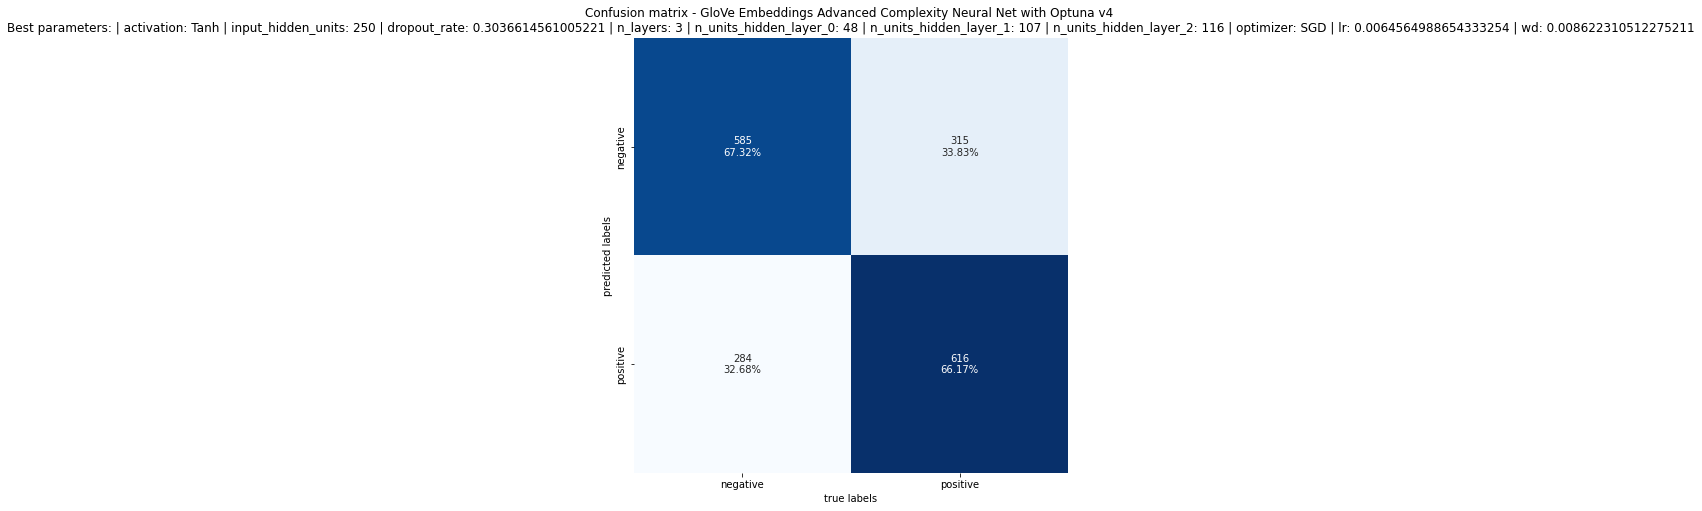

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna v4 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

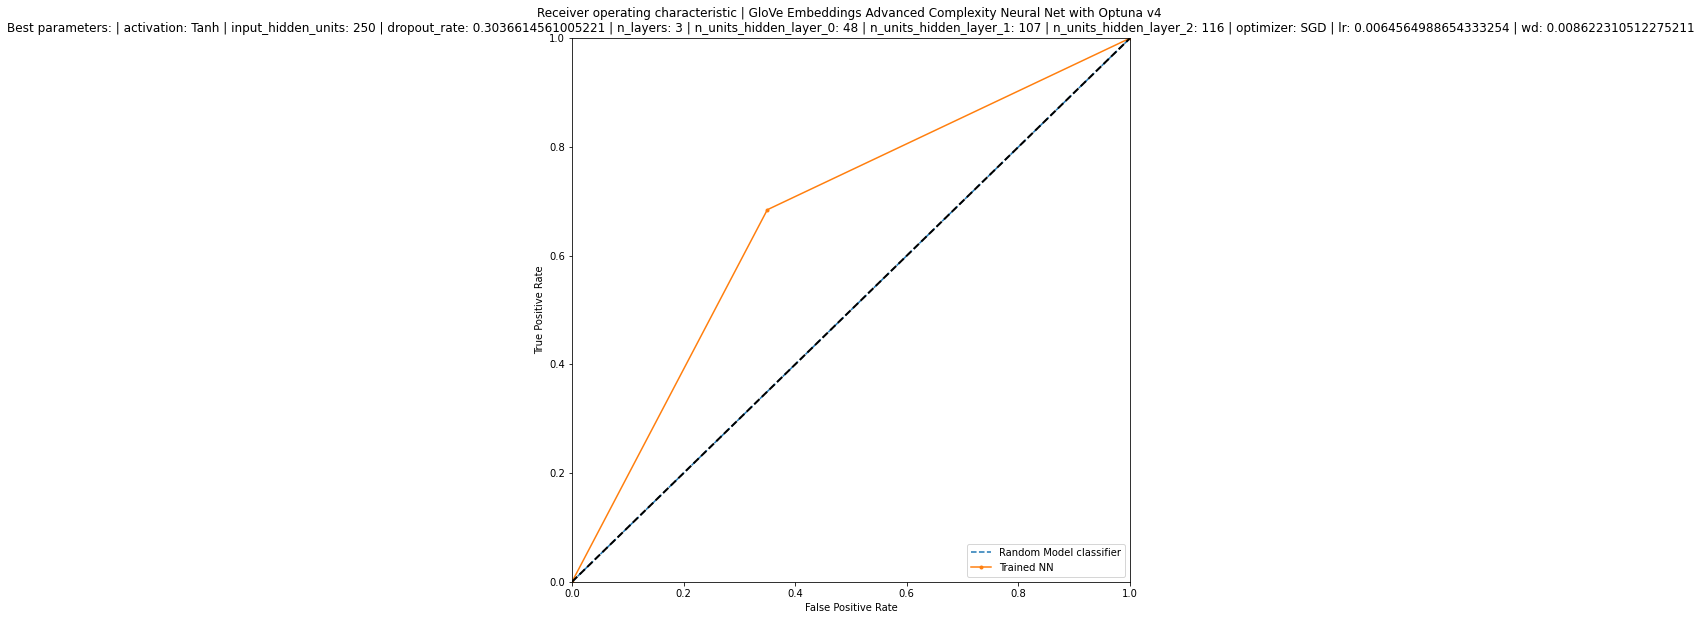

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced Complexity model with GloVe embeddings v5

- GloVe Embeddings with 100 dimension size and pre-trained on 6B words.
- 165 words per sentence (80% of sentences length)
- 256 training batch size
- Added the three mathematical transformations on word embeddings
- 20 trials from 16
- 100 epochs from 50

In [64]:
class SentimentClassifier_advanced_complexity_optuna_glove_v5(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v5, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
random_seed = 123456

def objective(trial, vocab, vectors = None):
  """
  Definition
  ---------
  The objective function used by Optuna framework for every trial of different model hyper-parameters.

  Arguments
  ---------
  trial: The Optuna trial with a different sent of hyper-parameters on each run. A trial has a training progress equal to a number of epochs set by the user.
  vocab: The vocabulary object containing words from the corpus or glove pre-trained words.
  vectors: The vectors matrix. In the case of GloVe embeddings this is the the matrix with the pre-trained weights per word/token.
           In the case of trainable weigths this is None because the matrix is trained and updated after each batch with new weights.

  Output
  ---------
  The validation loss with the lowest value during the epoch training.
  For example, if on epoch 10 we had the lowest validation loss and on epoch 15 the training stopped (from the early stop mechanism),
    due to higher validation losses then the validation loss of epoch 15 is returned.
  """
  torch.manual_seed(random_seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v5(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=vectors.vectors,
    embedding_dimension=vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 5e-4, 1e-2)
  weight_decay = trial.suggest_float('wd', 0, 0.1)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 100
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v5_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\t Val. Loss: {valid_loss:.5f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net v5"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return valid_loss

[I 2022-12-29 11:49:22,119] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove embeddings v5
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]


 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=161, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(483, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6986182621822867, inplace=False)
  (output_layer): Linear(in_features=144, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=483, out_features=144, bias=True)
  (fully_connected_layer_1): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected_layer_2): Tanh()
  (fully_connected_layer_3): Dropout(p=0.6986182621822867, inplace=False)
)

The model has 87,356 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.79091
	 Val. Loss:

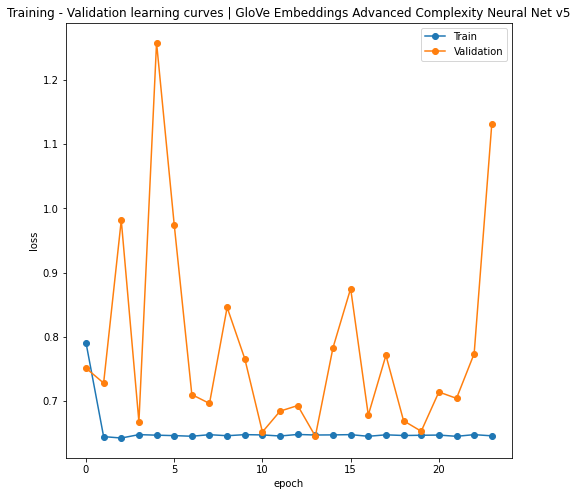

[I 2022-12-29 11:52:32,987] Trial 0 finished with value: 1.13131687147864 and parameters: {'activation': 'Tanh', 'input_hidden_units': 161, 'dropout_rate': 0.6986182621822867, 'n_layers': 1, 'n_units_hidden_layer_0': 48, 'optimizer': 'RMSprop', 'lr': 0.005658748919446866, 'wd': 0.03730122252214309}. Best is trial 0 with value: 1.13131687147864.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=238, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(714, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6601941815597786, inplace=False)
  (output_layer): Linear(in_features=105, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=714, out_features=105, bias=True)
  (fully_connected_layer_1): Batch

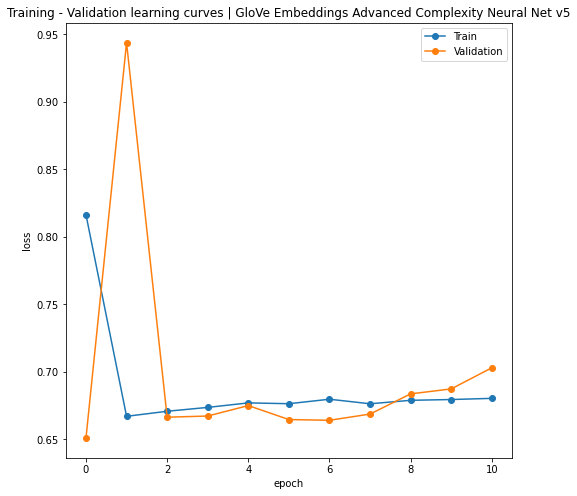

[I 2022-12-29 11:55:11,680] Trial 1 finished with value: 0.7029336094856262 and parameters: {'activation': 'ReLU', 'input_hidden_units': 238, 'dropout_rate': 0.6601941815597786, 'n_layers': 1, 'n_units_hidden_layer_0': 35, 'optimizer': 'Adam', 'lr': 0.008602547919014186, 'wd': 0.02355074784416813}. Best is trial 1 with value: 0.7029336094856262.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=202, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(606, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.280634981184984, inplace=False)
  (output_layer): Linear(in_features=147, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=606, out_features=111, bias=True)
  (fully_connected_layer_1): Batch

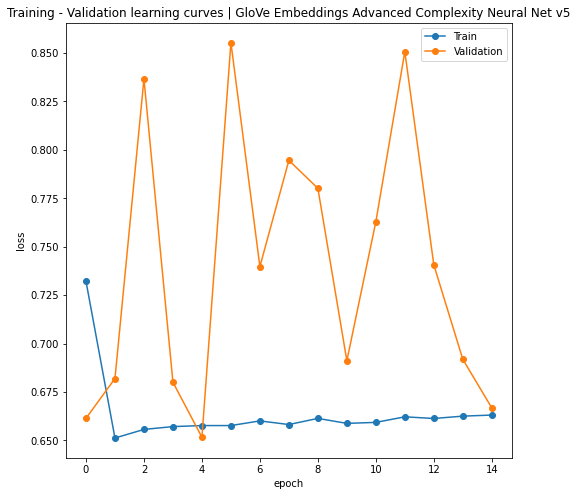

[I 2022-12-29 12:00:41,022] Trial 2 finished with value: 0.6667906929706705 and parameters: {'activation': 'Tanh', 'input_hidden_units': 202, 'dropout_rate': 0.280634981184984, 'n_layers': 2, 'n_units_hidden_layer_0': 37, 'n_units_hidden_layer_1': 49, 'optimizer': 'Adam', 'lr': 0.008684718252237903, 'wd': 0.0753568845335717}. Best is trial 2 with value: 0.6667906929706705.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=150, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4473295048812124, inplace=False)
  (output_layer): Linear(in_features=189, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=450, out_features=123, bias=True)
  (fu

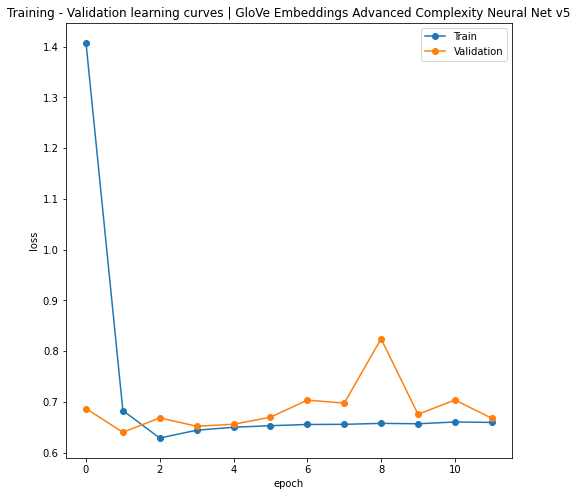

[I 2022-12-29 12:03:00,177] Trial 3 finished with value: 0.6679889436425834 and parameters: {'activation': 'ReLU', 'input_hidden_units': 150, 'dropout_rate': 0.4473295048812124, 'n_layers': 2, 'n_units_hidden_layer_0': 41, 'n_units_hidden_layer_1': 63, 'optimizer': 'Adam', 'lr': 0.0016206877316665665, 'wd': 0.07021843609805463}. Best is trial 2 with value: 0.6667906929706705.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=204, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(612, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.349932131563299, inplace=False)
  (output_layer): Linear(in_features=612, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 22,441 trainable parameters

Calculating train/validation loss using

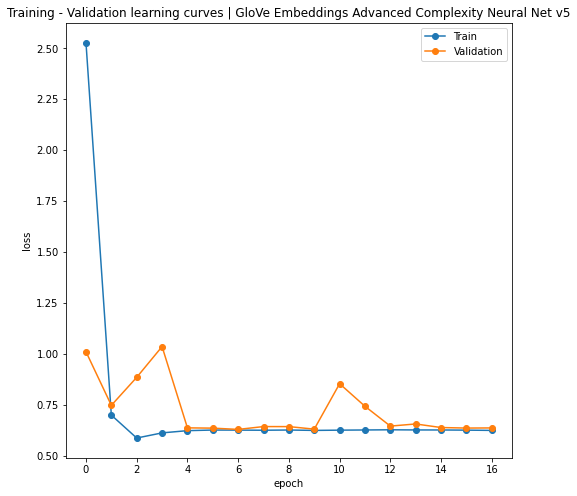

[I 2022-12-29 12:05:43,063] Trial 4 finished with value: 0.6367830901310362 and parameters: {'activation': 'ReLU', 'input_hidden_units': 204, 'dropout_rate': 0.349932131563299, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0014114193026968295, 'wd': 0.049730633260894}. Best is trial 4 with value: 0.6367830901310362.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=222, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(666, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6293621820067605, inplace=False)
  (output_layer): Linear(in_features=72, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=666, out_features=195, bias=True)
  (fully_connected_layer_1): BatchNorm1d(195, eps=1e-05, momentum=

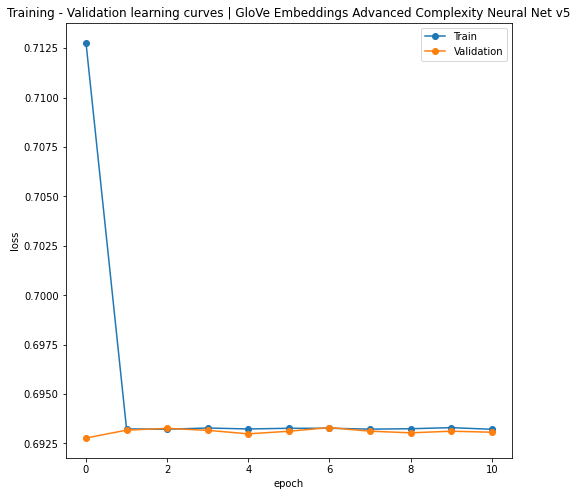

[I 2022-12-29 12:07:18,145] Trial 5 finished with value: 0.6930699759516222 and parameters: {'activation': 'Tanh', 'input_hidden_units': 222, 'dropout_rate': 0.6293621820067605, 'n_layers': 2, 'n_units_hidden_layer_0': 65, 'n_units_hidden_layer_1': 24, 'optimizer': 'RMSprop', 'lr': 0.006491645750576565, 'wd': 0.06395682175955746}. Best is trial 4 with value: 0.6367830901310362.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=239, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(717, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5915231503944574, inplace=False)
  (output_layer): Linear(in_features=717, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 26,291 trainable parameters

Calculating train/validation loss us

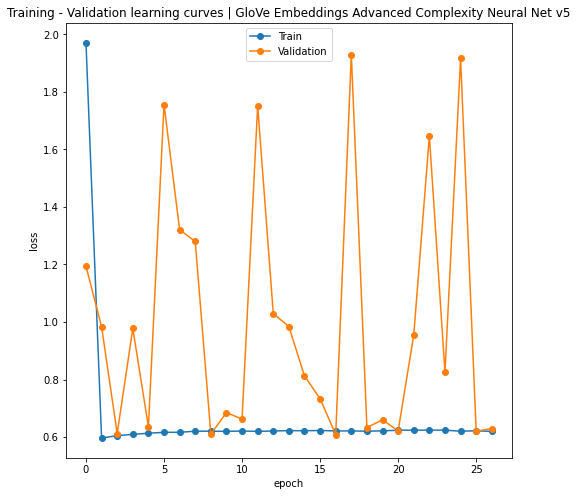

[I 2022-12-29 12:14:03,542] Trial 6 finished with value: 0.6296508209458713 and parameters: {'activation': 'ReLU', 'input_hidden_units': 239, 'dropout_rate': 0.5915231503944574, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.008564913520343699, 'wd': 0.014014442023912665}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=207, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(621, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.44752131861005984, inplace=False)
  (output_layer): Linear(in_features=162, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=621, out_features=318, bias=True)
  (fully_connected_layer_1): BatchNorm1d(318, eps=1e-05, mome

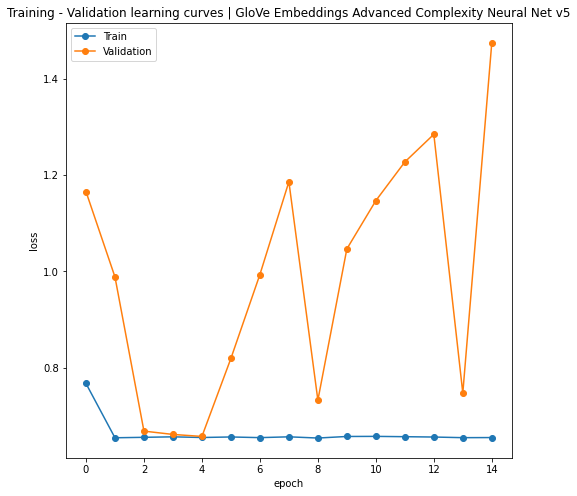

[I 2022-12-29 12:16:31,821] Trial 7 finished with value: 1.4746258299926231 and parameters: {'activation': 'Tanh', 'input_hidden_units': 207, 'dropout_rate': 0.44752131861005984, 'n_layers': 2, 'n_units_hidden_layer_0': 106, 'n_units_hidden_layer_1': 54, 'optimizer': 'RMSprop', 'lr': 0.004018627022790815, 'wd': 0.056294193180842306}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=233, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(699, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.2721742152653076, inplace=False)
  (output_layer): Linear(in_features=33, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=699, out_features=33, bias=True)

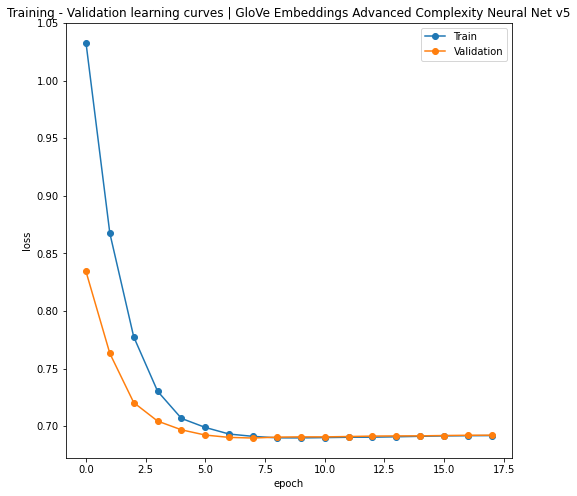

[I 2022-12-29 12:17:55,704] Trial 8 finished with value: 0.6921221696097275 and parameters: {'activation': 'Tanh', 'input_hidden_units': 233, 'dropout_rate': 0.2721742152653076, 'n_layers': 1, 'n_units_hidden_layer_0': 11, 'optimizer': 'SGD', 'lr': 0.0028685021405390216, 'wd': 0.09931239828278393}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=159, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.34395906042654006, inplace=False)
  (output_layer): Linear(in_features=477, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 17,491 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoc

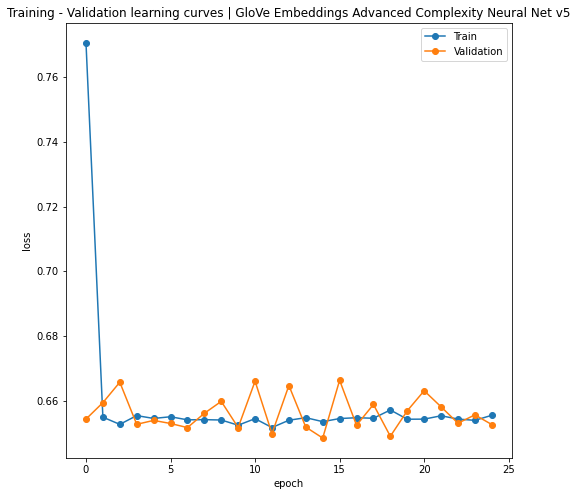

[I 2022-12-29 12:20:58,483] Trial 9 finished with value: 0.6525740397387537 and parameters: {'activation': 'Tanh', 'input_hidden_units': 159, 'dropout_rate': 0.34395906042654006, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.007062871905909171, 'wd': 0.06060418126568665}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=256, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5601268493526061, inplace=False)
  (output_layer): Linear(in_features=207, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=768, out_features=381, bias=True)
  (fully_connected_layer_1): BatchNorm1d(381, eps=1e-05, mo

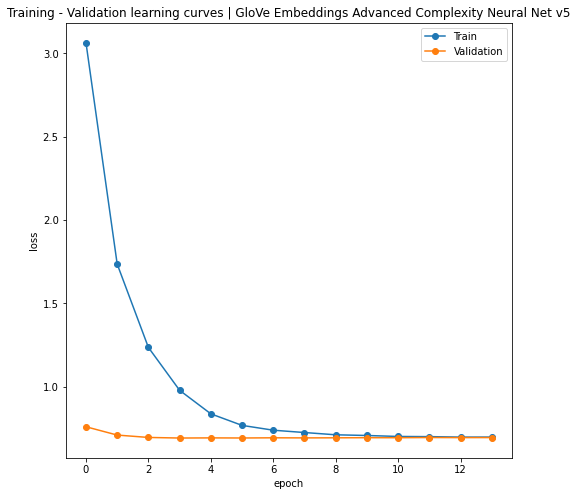

[I 2022-12-29 12:22:55,830] Trial 10 finished with value: 0.6943370021622757 and parameters: {'activation': 'ReLU', 'input_hidden_units': 256, 'dropout_rate': 0.5601268493526061, 'n_layers': 3, 'n_units_hidden_layer_0': 127, 'n_units_hidden_layer_1': 122, 'n_units_hidden_layer_2': 69, 'optimizer': 'SGD', 'lr': 0.009829810737925356, 'wd': 0.0034602754515180925}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=181, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(543, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5094263047525484, inplace=False)
  (output_layer): Linear(in_features=543, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 19,911 trainable parameters

Calcu

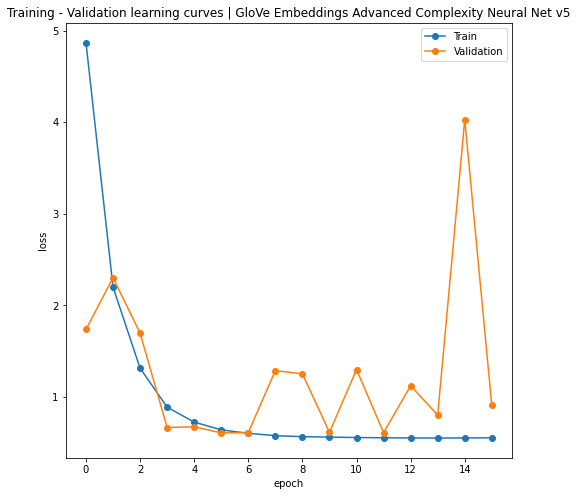

[I 2022-12-29 12:24:10,284] Trial 11 finished with value: 0.9057454734012998 and parameters: {'activation': 'ReLU', 'input_hidden_units': 181, 'dropout_rate': 0.5094263047525484, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0013530445136723506, 'wd': 0.0017658199513478773}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=186, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(558, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.40144991247985173, inplace=False)
  (output_layer): Linear(in_features=558, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 20,461 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss:

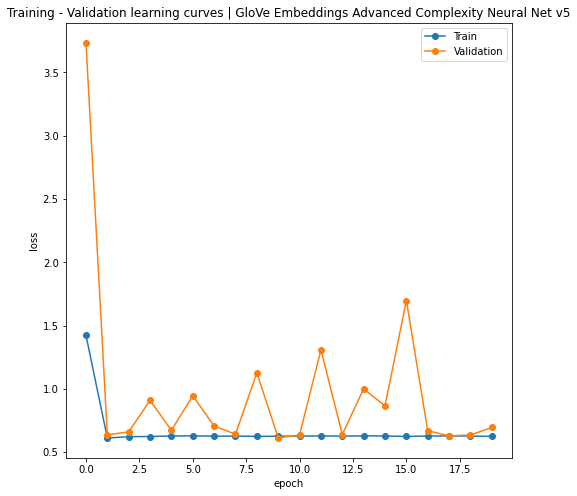

[I 2022-12-29 12:28:08,185] Trial 12 finished with value: 0.6948400694748451 and parameters: {'activation': 'ReLU', 'input_hidden_units': 186, 'dropout_rate': 0.40144991247985173, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.004125301216774691, 'wd': 0.03290463443735623}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=254, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(762, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5929080755252437, inplace=False)
  (output_layer): Linear(in_features=762, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 27,941 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 4.

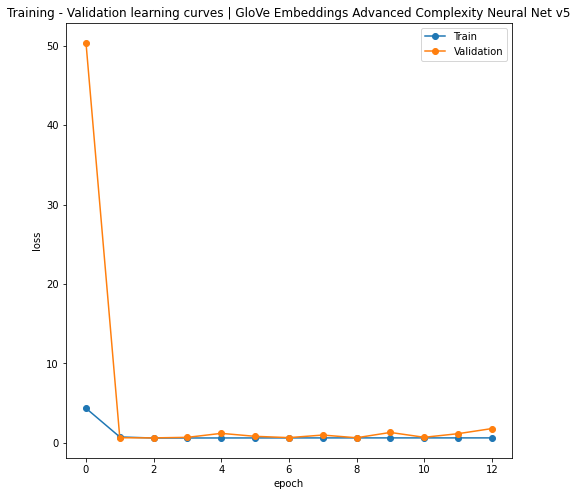

[I 2022-12-29 12:29:55,978] Trial 13 finished with value: 1.78454314840251 and parameters: {'activation': 'ReLU', 'input_hidden_units': 254, 'dropout_rate': 0.5929080755252437, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0029092983165684297, 'wd': 0.016606299969900203}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=219, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(657, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7484607336228092, inplace=False)
  (output_layer): Linear(in_features=657, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 24,091 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 2.2

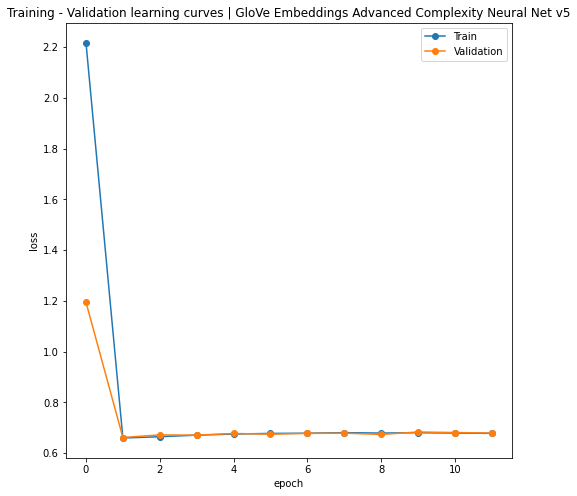

[I 2022-12-29 12:32:33,887] Trial 14 finished with value: 0.6793209951499413 and parameters: {'activation': 'ReLU', 'input_hidden_units': 219, 'dropout_rate': 0.7484607336228092, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.007835942800112008, 'wd': 0.04329674559602316}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=173, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(519, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5379411089185693, inplace=False)
  (output_layer): Linear(in_features=273, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=519, out_features=273, bias=True)
  (fully_connected_layer_1): BatchNorm1d(273, eps=1e-05, momen

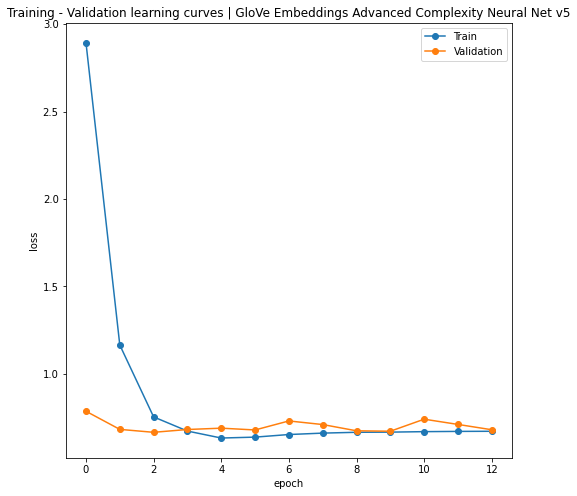

[I 2022-12-29 12:34:21,949] Trial 15 finished with value: 0.6802171982567886 and parameters: {'activation': 'ReLU', 'input_hidden_units': 173, 'dropout_rate': 0.5379411089185693, 'n_layers': 1, 'n_units_hidden_layer_0': 91, 'optimizer': 'Adam', 'lr': 0.0007309603044816479, 'wd': 0.08566025246987977}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=203, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(609, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.37136136278125503, inplace=False)
  (output_layer): Linear(in_features=30, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=609, out_features=33, bias=True)
  (fully_connected_layer_1): Bat

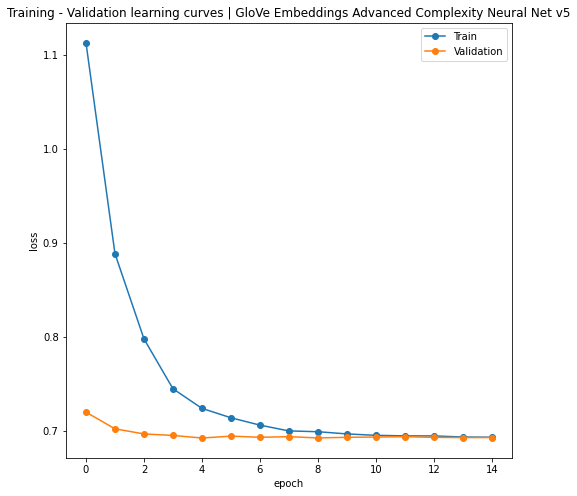

[I 2022-12-29 12:35:41,706] Trial 16 finished with value: 0.6928115487098694 and parameters: {'activation': 'ReLU', 'input_hidden_units': 203, 'dropout_rate': 0.37136136278125503, 'n_layers': 3, 'n_units_hidden_layer_0': 11, 'n_units_hidden_layer_1': 128, 'n_units_hidden_layer_2': 10, 'optimizer': 'SGD', 'lr': 0.005427246709983873, 'wd': 0.017862354839604373}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=137, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(411, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4670828117543087, inplace=False)
  (output_layer): Linear(in_features=411, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 15,071 trainable parameters

Calcul

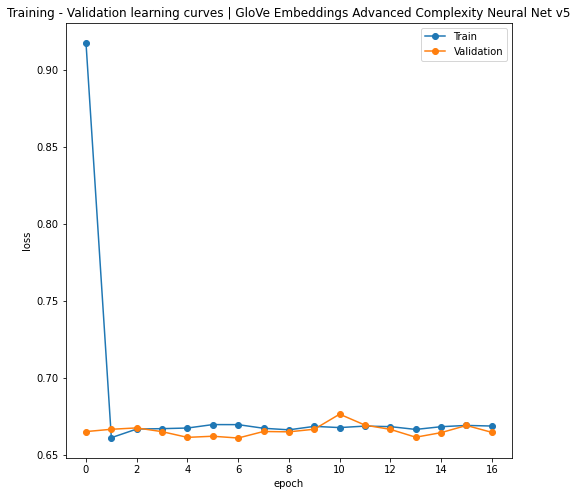

[I 2022-12-29 12:38:50,161] Trial 17 finished with value: 0.6645112058212017 and parameters: {'activation': 'ReLU', 'input_hidden_units': 137, 'dropout_rate': 0.4670828117543087, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.00970485652386215, 'wd': 0.04905800295025051}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=239, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(717, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3118478691429496, inplace=False)
  (output_layer): Linear(in_features=258, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=717, out_features=258, bias=True)
  (fully_connected_layer_1): BatchNorm1d(258, eps=1e-05, moment

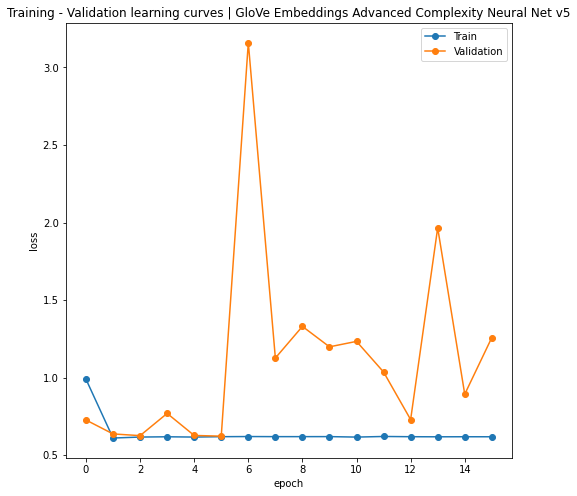

[I 2022-12-29 12:45:02,601] Trial 18 finished with value: 1.2578400394012188 and parameters: {'activation': 'ReLU', 'input_hidden_units': 239, 'dropout_rate': 0.3118478691429496, 'n_layers': 1, 'n_units_hidden_layer_0': 86, 'optimizer': 'Adam', 'lr': 0.004200441914006554, 'wd': 0.028887123203744963}. Best is trial 6 with value: 0.6296508209458713.

 SentimentClassifier_advanced_complexity_optuna_glove_v5(
  (embedding): Embedding(400000, 100, padding_idx=0)
  (input_layer): Linear(in_features=100, out_features=219, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(657, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3969508402162687, inplace=False)
  (output_layer): Linear(in_features=657, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 24,091 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epo

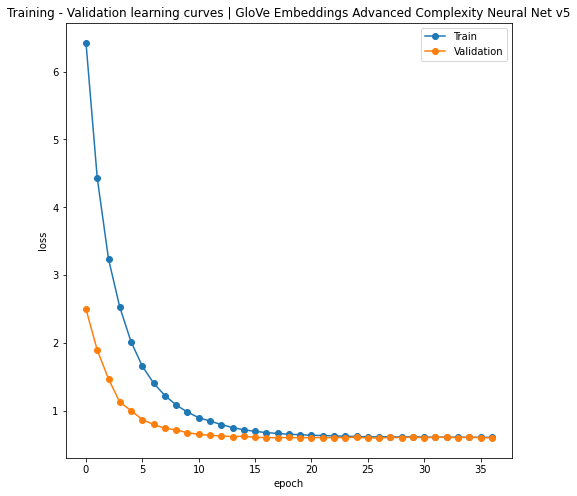

[I 2022-12-29 12:47:46,991] Trial 19 finished with value: 0.6046297344668158 and parameters: {'activation': 'ReLU', 'input_hidden_units': 219, 'dropout_rate': 0.3969508402162687, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.006551056124019041, 'wd': 0.008821968501202114}. Best is trial 19 with value: 0.6046297344668158.


In [ ]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial, glove_vocab_100, glove_vectors_100)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v5", sampler=optuna.samplers.TPESampler(seed=random_seed), pruner=optuna.pruners.MedianPruner())

study.optimize(trial_validation_loss, n_trials=20, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [ ]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v5.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v5.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v5.pt")


Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:    0
  Number of complete trials:  20

Best trial: 

Best model validation loss value: 0.6046297344668158

Best trial number: 19

Best model parameters: 

activation: ReLU

input_hidden_units: 219

dropout_rate: 0.3969508402162687

n_layers: 0

optimizer: SGD

lr: 0.006551056124019041

wd: 0.008821968501202114


Evaluation metrics: GloVe Embeddings Advanced Complexity Neural Net with Optuna v5 
Best parameters: | activation: ReLU | input_hidden_units: 219 | dropout_rate: 0.3969508402162687 | n_layers: 0 | optimizer: SGD | lr: 0.006551056124019041 | wd: 0.008821968501202114 

precision score: 0.6770 
recall_score: 0.7011 
roc score: 0.6833 
f1_score: 0.6889

model bias: 0.0006
model variance: 0.2497


              precision    recall  f1-score   support

    negative       0.69      0.67      0.68       900
    positive       0.68      0.70      0.69       900

    accuracy                           0.68      1800
   macro avg       0.68      0.68      0.68      1800
weighted avg       0.68      0.68      0.68      1800





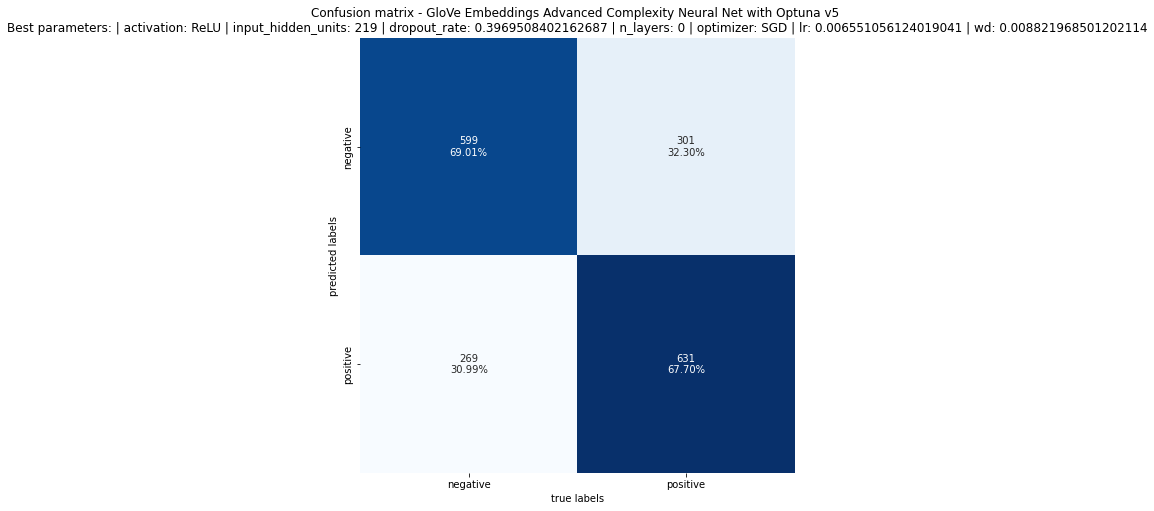

In [ ]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna v5 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

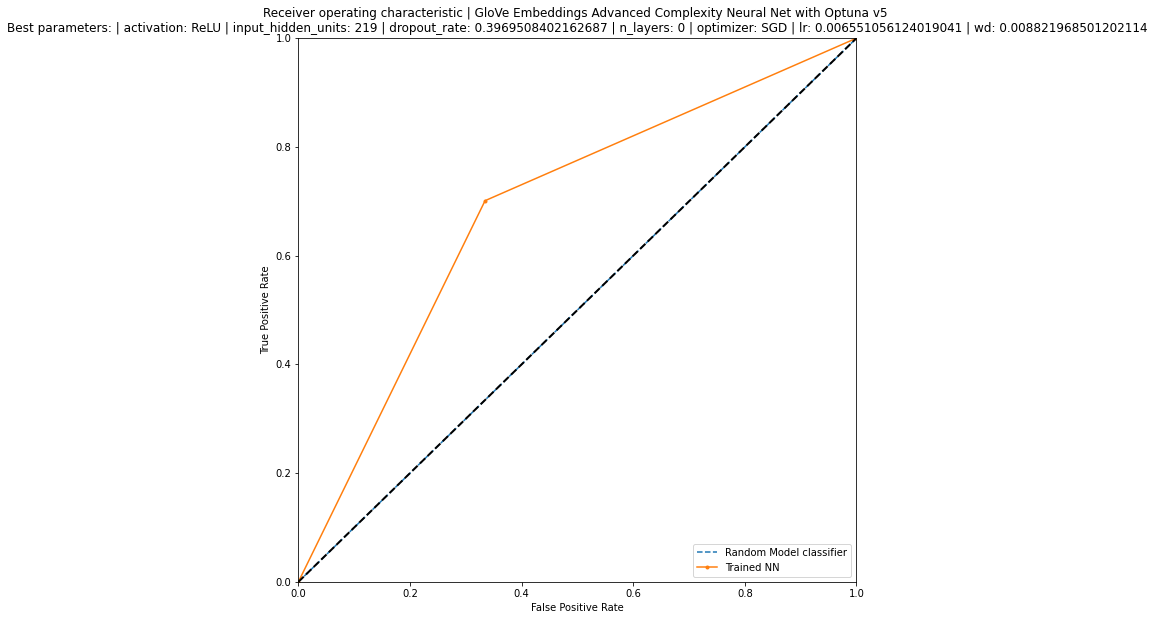

In [ ]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

---

### Advanced Complexity model with GloVe embeddings v6

- GloVe Embeddings with 200 dimension size and pre-trained on 6B words.
- 165 words per sentence (80% of sentences length)
- 256 training batch size
- Added the three mathematical transformations on word embeddings
- 20 trials from 16
- 100 epochs from 50

In [ ]:
class SentimentClassifier_advanced_complexity_optuna_glove_v6(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v6, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [ ]:
random_seed = 12345678

def objective(trial, vocab, vectors = None):
  """
  Definition
  ---------
  The objective function used by Optuna framework for every trial of different model hyper-parameters.

  Arguments
  ---------
  trial: The Optuna trial with a different sent of hyper-parameters on each run. A trial has a training progress equal to a number of epochs set by the user.
  vocab: The vocabulary object containing words from the corpus or glove pre-trained words.
  vectors: The vectors matrix. In the case of GloVe embeddings this is the the matrix with the pre-trained weights per word/token.
           In the case of trainable weigths this is None because the matrix is trained and updated after each batch with new weights.

  Output
  ---------
  The validation loss with the lowest value during the epoch training.
  For example, if on epoch 10 we had the lowest validation loss and on epoch 15 the training stopped (from the early stop mechanism),
    due to higher validation losses then the validation loss of epoch 15 is returned.
  """
  torch.manual_seed(random_seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v6(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=vectors.vectors,
    embedding_dimension=vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 5e-4, 1e-2)
  weight_decay = trial.suggest_float('wd', 0, 0.1)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 100
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v6_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\t Val. Loss: {valid_loss:.5f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net v6"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2022-12-29 16:08:34,994] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove embeddings v6


  0%|          | 0/25 [00:00<?, ?it/s]


 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=174, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(522, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.43945505253399575, inplace=False)
  (output_layer): Linear(in_features=522, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 36,541 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 5.77207
	 Val. Loss: 2.51805

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 3.85675
	 Val. Loss: 2.04469

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 2.79117
	 Val. Loss: 1.56568

Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 2.18212
	 Val. Loss: 1.28555

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 1.75621
	 Val. Loss: 1.06301


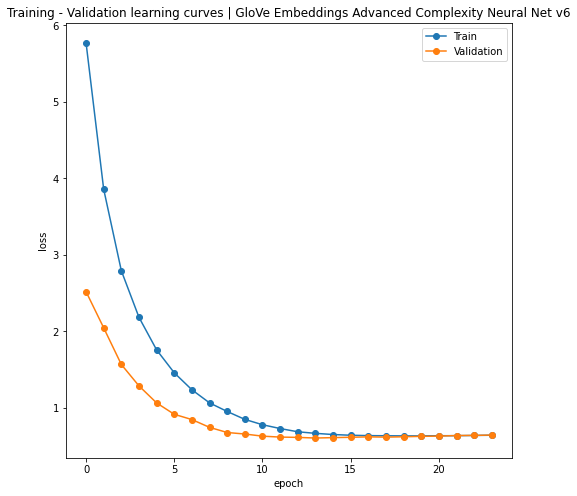

[I 2022-12-29 16:10:59,512] Trial 0 finished with value: 0.6040363856430712 and parameters: {'activation': 'Tanh', 'input_hidden_units': 174, 'dropout_rate': 0.43945505253399575, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.008473737892146397, 'wd': 0.07607368854925466}. Best is trial 0 with value: 0.6040363856430712.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=228, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(684, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6108706855745609, inplace=False)
  (output_layer): Linear(in_features=684, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 47,881 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 4s
	Train Loss: 2.83

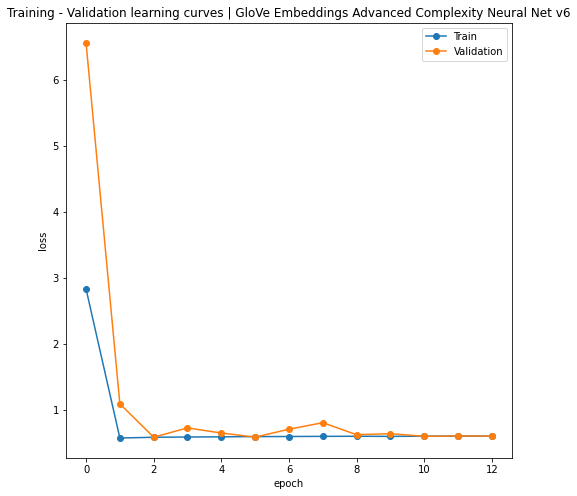

[I 2022-12-29 16:12:32,674] Trial 1 finished with value: 0.5880006839489115 and parameters: {'activation': 'ReLU', 'input_hidden_units': 228, 'dropout_rate': 0.6108706855745609, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.009826412840166011, 'wd': 0.03049085077056315}. Best is trial 1 with value: 0.5880006839489115.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=236, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(708, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3107950530420429, inplace=False)
  (output_layer): Linear(in_features=291, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=708, out_features=225, bias=True)
  (fully_connected_layer_1): BatchNorm1d(225, eps=1e-05, moment

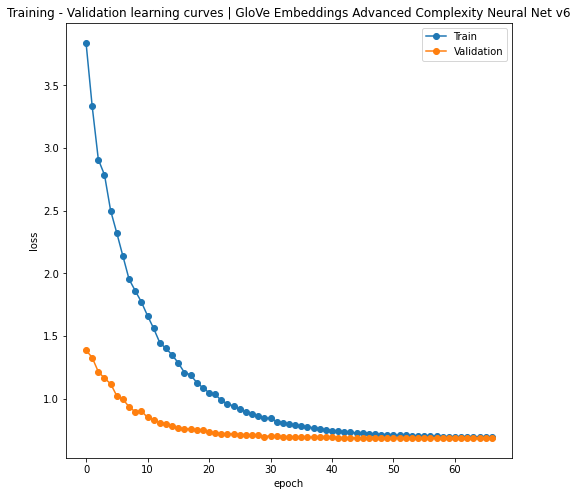

[I 2022-12-29 16:20:29,979] Trial 2 finished with value: 0.6873276398099702 and parameters: {'activation': 'ReLU', 'input_hidden_units': 236, 'dropout_rate': 0.3107950530420429, 'n_layers': 3, 'n_units_hidden_layer_0': 75, 'n_units_hidden_layer_1': 109, 'n_units_hidden_layer_2': 97, 'optimizer': 'SGD', 'lr': 0.0026146017348009573, 'wd': 0.0572684350734936}. Best is trial 1 with value: 0.5880006839489115.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=161, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(483, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6150078785232598, inplace=False)
  (output_layer): Linear(in_features=66, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=483, out

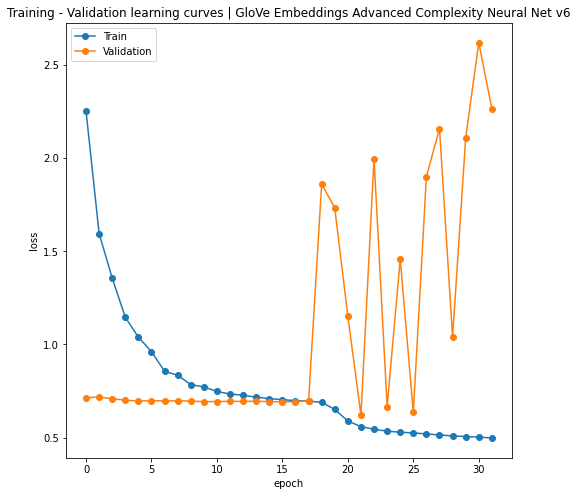

[I 2022-12-29 16:24:08,825] Trial 3 finished with value: 0.6210656268843289 and parameters: {'activation': 'ReLU', 'input_hidden_units': 161, 'dropout_rate': 0.6150078785232598, 'n_layers': 3, 'n_units_hidden_layer_0': 47, 'n_units_hidden_layer_1': 41, 'n_units_hidden_layer_2': 22, 'optimizer': 'RMSprop', 'lr': 0.0005965942713359193, 'wd': 0.0018847034193133273}. Best is trial 1 with value: 0.5880006839489115.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=218, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(654, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6002777339960113, inplace=False)
  (output_layer): Linear(in_features=222, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=6

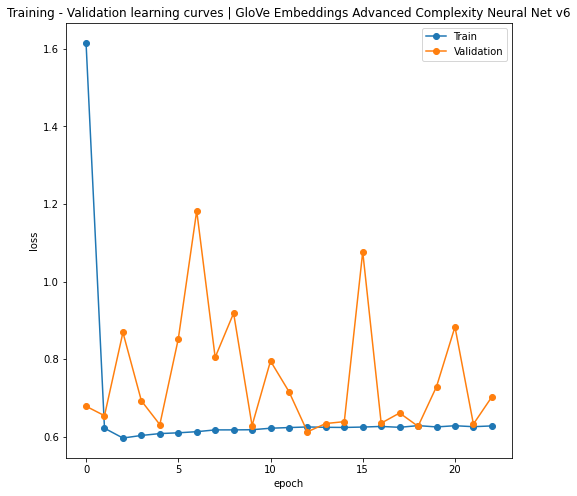

[I 2022-12-29 16:34:10,765] Trial 4 finished with value: 0.612320836248069 and parameters: {'activation': 'Tanh', 'input_hidden_units': 218, 'dropout_rate': 0.6002777339960113, 'n_layers': 2, 'n_units_hidden_layer_0': 99, 'n_units_hidden_layer_1': 74, 'optimizer': 'Adam', 'lr': 0.007293951399775192, 'wd': 0.06266238198002479}. Best is trial 1 with value: 0.5880006839489115.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=186, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(558, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.604865306361756, inplace=False)
  (output_layer): Linear(in_features=339, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=558, out_features=339, bias=True)
  (fu

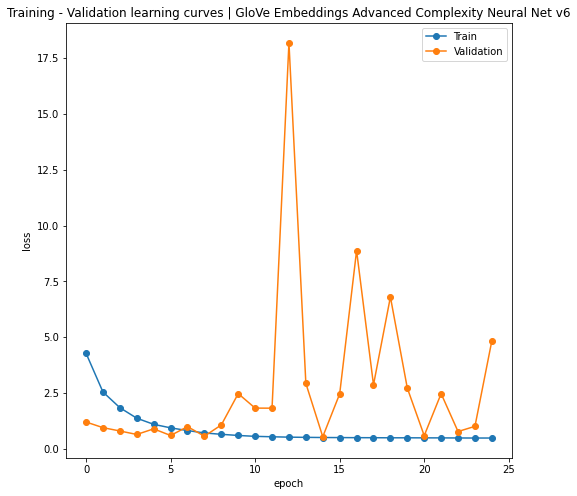

[I 2022-12-29 16:38:39,032] Trial 5 finished with value: 0.537224019395894 and parameters: {'activation': 'ReLU', 'input_hidden_units': 186, 'dropout_rate': 0.604865306361756, 'n_layers': 1, 'n_units_hidden_layer_0': 113, 'optimizer': 'RMSprop', 'lr': 0.0013707001138481179, 'wd': 0.002671531526545057}. Best is trial 5 with value: 0.537224019395894.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=234, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.728937293550739, inplace=False)
  (output_layer): Linear(in_features=702, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 49,141 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epo

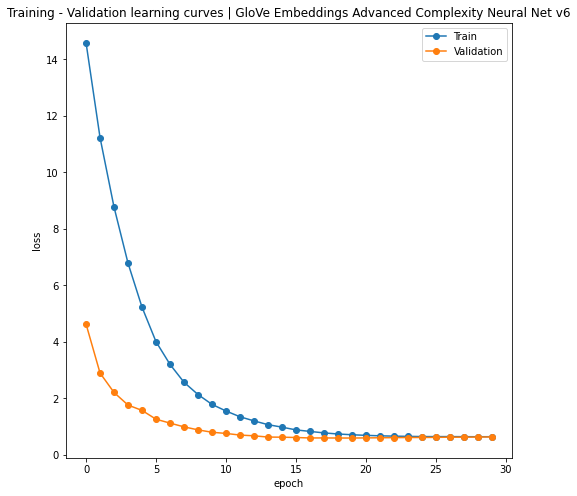

[I 2022-12-29 16:41:42,015] Trial 6 finished with value: 0.599956239091939 and parameters: {'activation': 'Tanh', 'input_hidden_units': 234, 'dropout_rate': 0.728937293550739, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.005522355518225835, 'wd': 0.08943242593154821}. Best is trial 5 with value: 0.537224019395894.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=176, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3599287427725226, inplace=False)
  (output_layer): Linear(in_features=99, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=528, out_features=81, bias=True)
  (fully_connected_layer_1): BatchNorm1d(81, eps=1e-05, momentum=0.1,

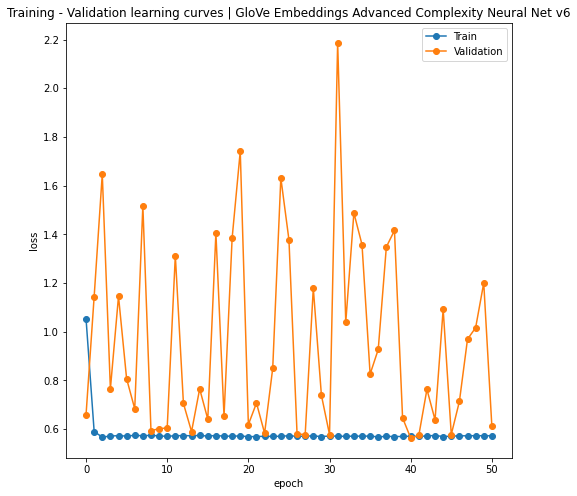

[I 2022-12-29 16:57:09,479] Trial 7 finished with value: 0.5631367749181287 and parameters: {'activation': 'Tanh', 'input_hidden_units': 176, 'dropout_rate': 0.3599287427725226, 'n_layers': 3, 'n_units_hidden_layer_0': 27, 'n_units_hidden_layer_1': 113, 'n_units_hidden_layer_2': 33, 'optimizer': 'Adam', 'lr': 0.006272141773821767, 'wd': 0.02726106030692396}. Best is trial 5 with value: 0.537224019395894.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=218, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(654, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6008643883058145, inplace=False)
  (output_layer): Linear(in_features=654, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 45,781 trainable parameters

Calculati

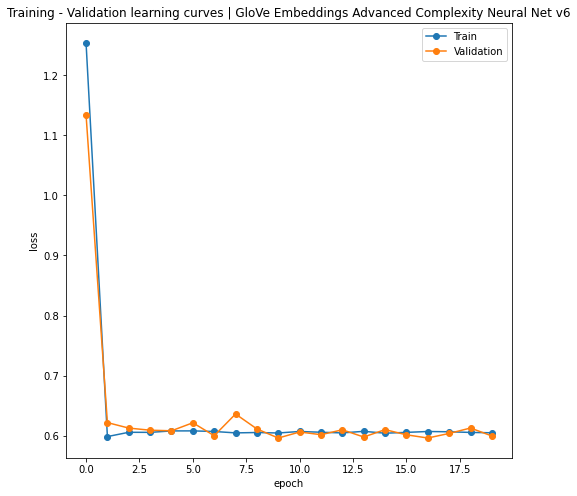

[I 2022-12-29 17:00:40,031] Trial 8 finished with value: 0.5960032384971092 and parameters: {'activation': 'Tanh', 'input_hidden_units': 218, 'dropout_rate': 0.6008643883058145, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.006285889109054404, 'wd': 0.06347794212659129}. Best is trial 5 with value: 0.537224019395894.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=204, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(612, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5886201032951373, inplace=False)
  (output_layer): Linear(in_features=267, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=612, out_features=63, bias=True)
  (fully_connected_layer_1): BatchNorm1d(63, eps=1e-05, moment

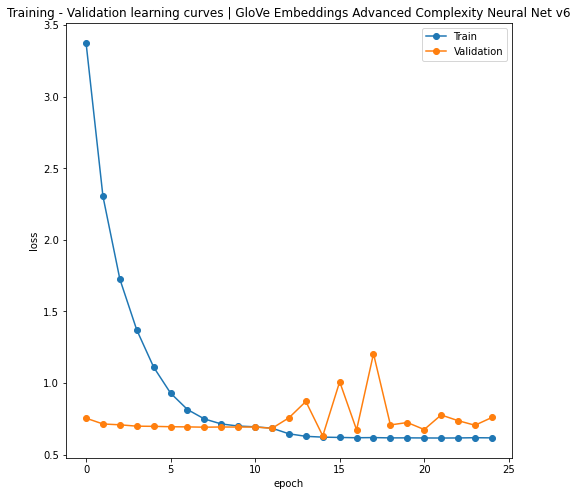

[I 2022-12-29 17:07:05,472] Trial 9 finished with value: 0.6306777802006952 and parameters: {'activation': 'ReLU', 'input_hidden_units': 204, 'dropout_rate': 0.5886201032951373, 'n_layers': 3, 'n_units_hidden_layer_0': 21, 'n_units_hidden_layer_1': 78, 'n_units_hidden_layer_2': 89, 'optimizer': 'RMSprop', 'lr': 0.0006541165623281608, 'wd': 0.08962899425461872}. Best is trial 5 with value: 0.537224019395894.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=139, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(417, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7443365493045689, inplace=False)
  (output_layer): Linear(in_features=369, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=417,

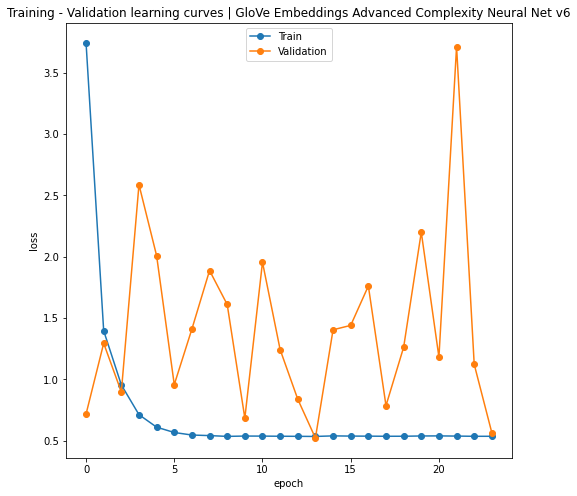

[I 2022-12-29 17:12:39,162] Trial 10 finished with value: 0.5212261759001633 and parameters: {'activation': 'ReLU', 'input_hidden_units': 139, 'dropout_rate': 0.7443365493045689, 'n_layers': 1, 'n_units_hidden_layer_0': 123, 'optimizer': 'RMSprop', 'lr': 0.003442894100521217, 'wd': 0.0020635292458083543}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=129, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(387, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7339534858054892, inplace=False)
  (output_layer): Linear(in_features=372, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=387, out_features=372, bias=True)
  (fully_connected_layer_

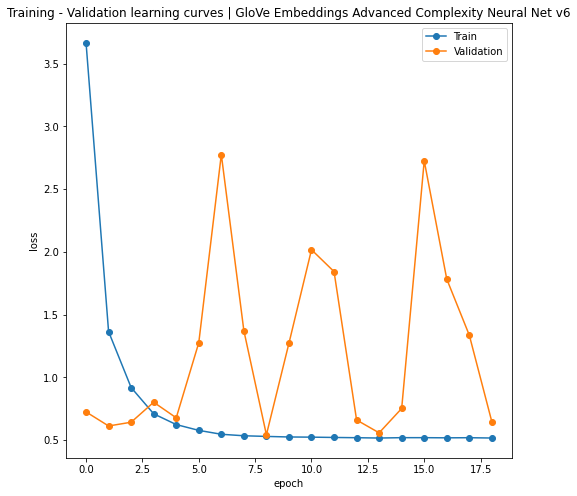

[I 2022-12-29 17:15:45,702] Trial 11 finished with value: 0.5428883310022026 and parameters: {'activation': 'ReLU', 'input_hidden_units': 129, 'dropout_rate': 0.7339534858054892, 'n_layers': 1, 'n_units_hidden_layer_0': 124, 'optimizer': 'RMSprop', 'lr': 0.0033932830318740524, 'wd': 0.0009354060301394313}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=136, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(408, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5012532410501322, inplace=False)
  (output_layer): Linear(in_features=381, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=408, out_features=381, bias=True)
  (fully_connected_layer

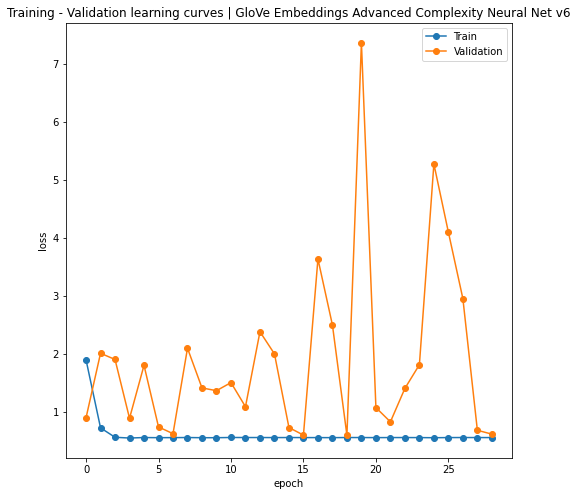

[I 2022-12-29 17:25:54,968] Trial 12 finished with value: 0.5981518338466513 and parameters: {'activation': 'ReLU', 'input_hidden_units': 136, 'dropout_rate': 0.5012532410501322, 'n_layers': 1, 'n_units_hidden_layer_0': 127, 'optimizer': 'RMSprop', 'lr': 0.003233328686429762, 'wd': 0.021951229504713655}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=152, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6922078368054874, inplace=False)
  (output_layer): Linear(in_features=294, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=456, out_features=294, bias=True)
  (fully_connected_layer_1

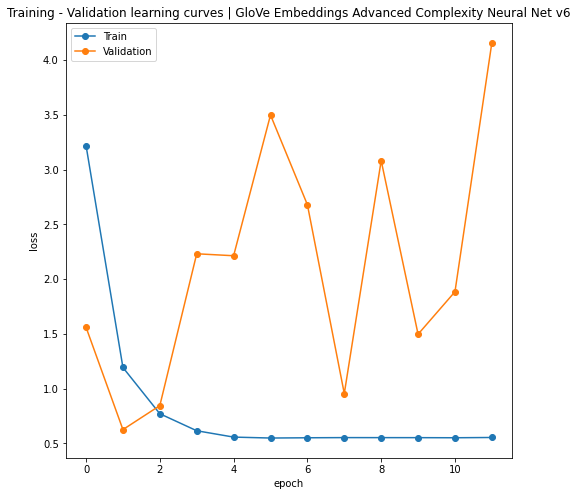

[I 2022-12-29 17:27:51,110] Trial 13 finished with value: 0.6260923928227918 and parameters: {'activation': 'ReLU', 'input_hidden_units': 152, 'dropout_rate': 0.6922078368054874, 'n_layers': 1, 'n_units_hidden_layer_0': 98, 'optimizer': 'RMSprop', 'lr': 0.0022147793313487237, 'wd': 0.014914999937850865}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=190, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(570, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4971838727915455, inplace=False)
  (output_layer): Linear(in_features=24, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=570, out_features=306, bias=True)
  (fully_connected_layer_1)

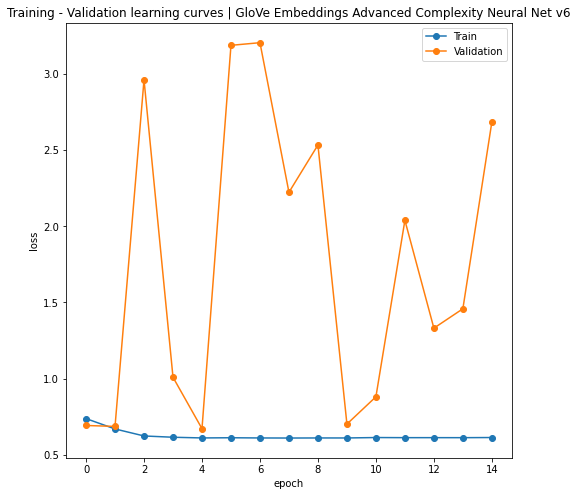

[I 2022-12-29 17:33:29,476] Trial 14 finished with value: 0.6710019522699816 and parameters: {'activation': 'ReLU', 'input_hidden_units': 190, 'dropout_rate': 0.4971838727915455, 'n_layers': 2, 'n_units_hidden_layer_0': 102, 'n_units_hidden_layer_1': 8, 'optimizer': 'RMSprop', 'lr': 0.004501988535501581, 'wd': 0.038572631808835044}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=255, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(765, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6699790176582768, inplace=False)
  (output_layer): Linear(in_features=222, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=765, out_features=222, bias=Tru

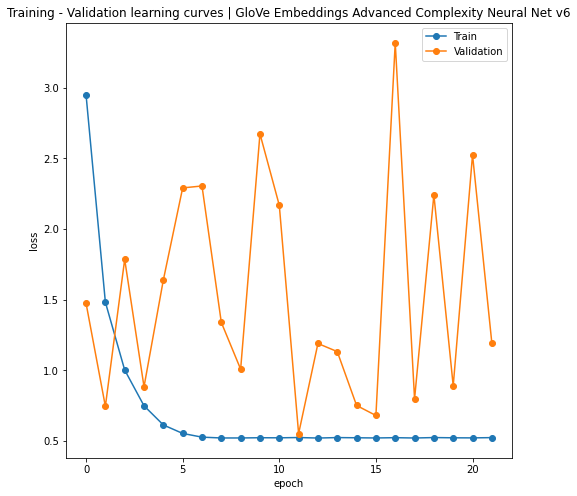

[I 2022-12-29 17:41:45,404] Trial 15 finished with value: 0.5515603926675073 and parameters: {'activation': 'ReLU', 'input_hidden_units': 255, 'dropout_rate': 0.6699790176582768, 'n_layers': 1, 'n_units_hidden_layer_0': 74, 'optimizer': 'RMSprop', 'lr': 0.0015964911380772426, 'wd': 0.009854579082578998}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=159, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(477, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.519998365628351, inplace=False)
  (output_layer): Linear(in_features=57, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=477, out_features=336, bias=True)
  (fully_connected_layer_1):

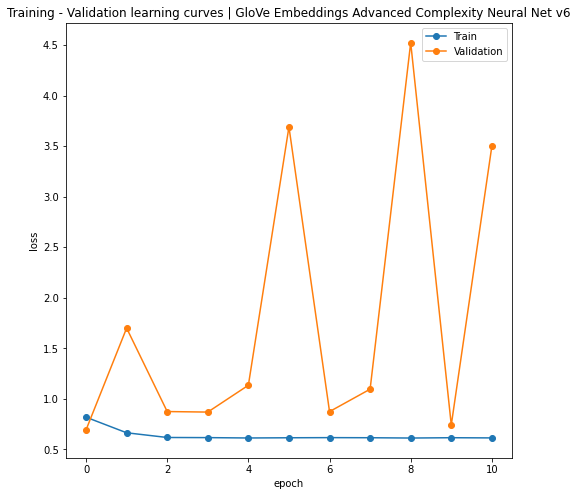

[I 2022-12-29 17:44:59,596] Trial 16 finished with value: 0.6921040559637135 and parameters: {'activation': 'ReLU', 'input_hidden_units': 159, 'dropout_rate': 0.519998365628351, 'n_layers': 2, 'n_units_hidden_layer_0': 112, 'n_units_hidden_layer_1': 19, 'optimizer': 'RMSprop', 'lr': 0.0041796132559620055, 'wd': 0.04256443821597212}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=193, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(579, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6651730841804022, inplace=False)
  (output_layer): Linear(in_features=255, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=579, out_features=255, bias=Tru

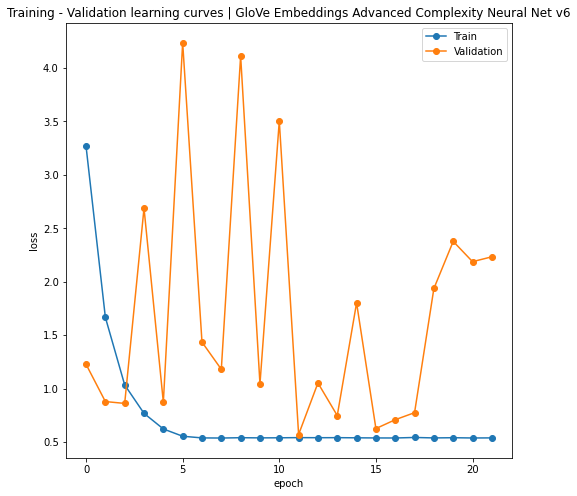

[I 2022-12-29 17:52:10,944] Trial 17 finished with value: 0.571269605694146 and parameters: {'activation': 'ReLU', 'input_hidden_units': 193, 'dropout_rate': 0.6651730841804022, 'n_layers': 1, 'n_units_hidden_layer_0': 85, 'optimizer': 'RMSprop', 'lr': 0.0016118552587834779, 'wd': 0.01533726303840776}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=144, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(432, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.2530793537228683, inplace=False)
  (output_layer): Linear(in_features=378, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=432, out_features=153, bias=True)
  (fully_connected_layer_1):

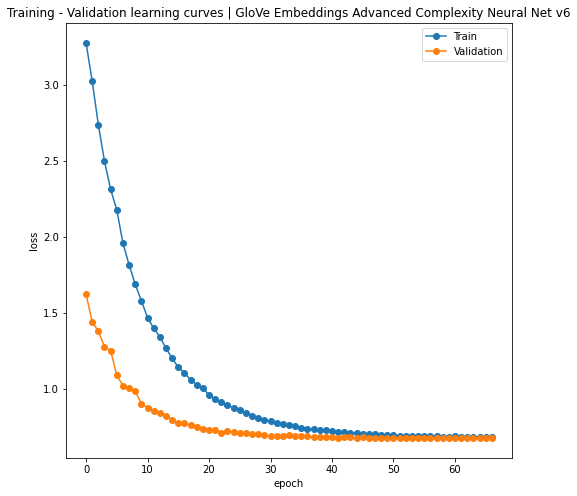

[I 2022-12-29 17:59:05,645] Trial 18 finished with value: 0.6751400766701534 and parameters: {'activation': 'ReLU', 'input_hidden_units': 144, 'dropout_rate': 0.2530793537228683, 'n_layers': 2, 'n_units_hidden_layer_0': 51, 'n_units_hidden_layer_1': 126, 'optimizer': 'SGD', 'lr': 0.004188601590197613, 'wd': 0.03719001975842817}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=173, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(519, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5426368992458839, inplace=False)
  (output_layer): Linear(in_features=333, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=519, out_features=333, bias=True)
 

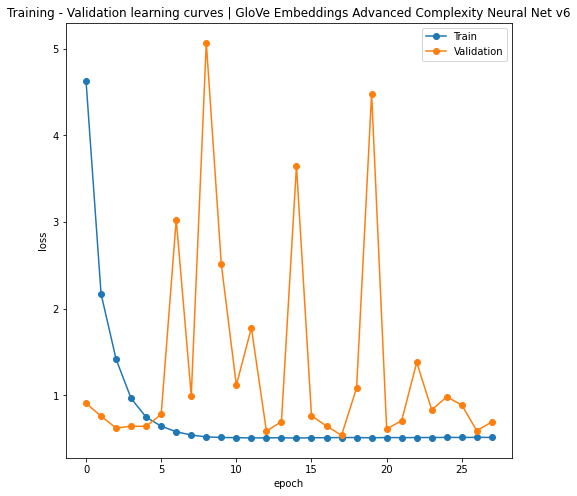

[I 2022-12-29 18:02:23,075] Trial 19 finished with value: 0.5399512422495875 and parameters: {'activation': 'ReLU', 'input_hidden_units': 173, 'dropout_rate': 0.5426368992458839, 'n_layers': 1, 'n_units_hidden_layer_0': 111, 'optimizer': 'Adam', 'lr': 0.0019799959669653416, 'wd': 0.0074376805356137195}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=196, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(588, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4107773728113359, inplace=False)
  (output_layer): Linear(in_features=144, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=588, out_features=270, bias=True)
  (fully_connected_layer_1)

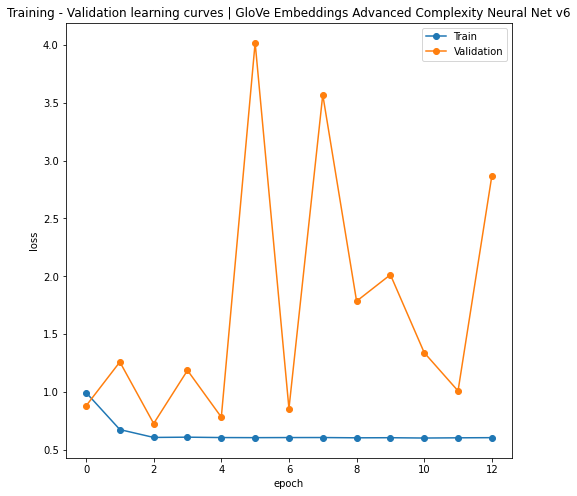

[I 2022-12-29 18:06:40,830] Trial 20 finished with value: 0.726974592126649 and parameters: {'activation': 'ReLU', 'input_hidden_units': 196, 'dropout_rate': 0.4107773728113359, 'n_layers': 2, 'n_units_hidden_layer_0': 90, 'n_units_hidden_layer_1': 48, 'optimizer': 'RMSprop', 'lr': 0.003363072762321109, 'wd': 0.049777724171447706}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=177, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(531, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5206588718403304, inplace=False)
  (output_layer): Linear(in_features=336, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=531, out_features=336, bias=True

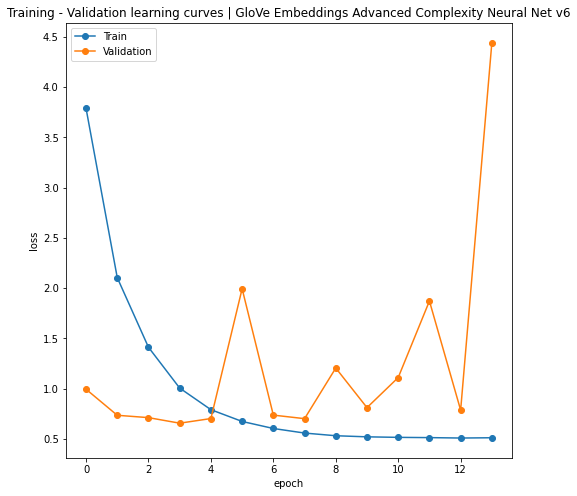

[I 2022-12-29 18:08:35,315] Trial 21 finished with value: 0.6552050637787786 and parameters: {'activation': 'ReLU', 'input_hidden_units': 177, 'dropout_rate': 0.5206588718403304, 'n_layers': 1, 'n_units_hidden_layer_0': 112, 'optimizer': 'Adam', 'lr': 0.0016031072074800124, 'wd': 0.009297576986386065}. Best is trial 10 with value: 0.5212261759001633.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=166, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(498, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5487255587590847, inplace=False)
  (output_layer): Linear(in_features=342, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=498, out_features=342, bias=True)
  (fully_connected_layer_1):

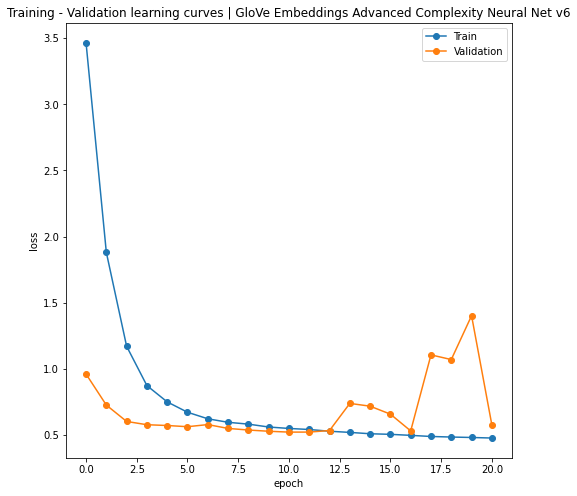

[I 2022-12-29 18:10:59,497] Trial 22 finished with value: 0.5206999100487808 and parameters: {'activation': 'ReLU', 'input_hidden_units': 166, 'dropout_rate': 0.5487255587590847, 'n_layers': 1, 'n_units_hidden_layer_0': 114, 'optimizer': 'Adam', 'lr': 0.0026746691846020916, 'wd': 0.00029401485646869696}. Best is trial 22 with value: 0.5206999100487808.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=146, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(438, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.44702604202640095, inplace=False)
  (output_layer): Linear(in_features=381, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=438, out_features=381, bias=True)
  (fully_connected_layer_

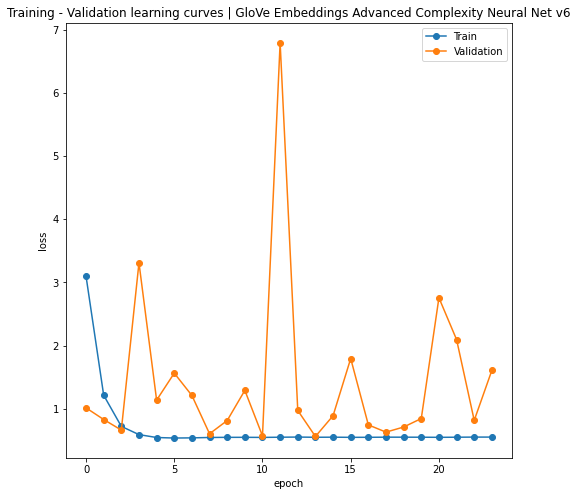

[I 2022-12-29 18:14:33,973] Trial 23 finished with value: 0.562455717859597 and parameters: {'activation': 'ReLU', 'input_hidden_units': 146, 'dropout_rate': 0.44702604202640095, 'n_layers': 1, 'n_units_hidden_layer_0': 127, 'optimizer': 'Adam', 'lr': 0.0028730051450177735, 'wd': 0.02083665273662353}. Best is trial 22 with value: 0.5206999100487808.

 SentimentClassifier_advanced_complexity_optuna_glove_v6(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=163, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(489, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5573515125291593, inplace=False)
  (output_layer): Linear(in_features=489, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 34,231 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | E

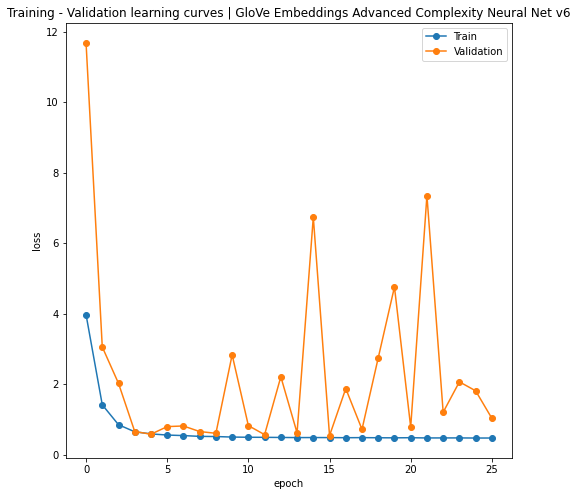

[I 2022-12-29 18:17:04,016] Trial 24 finished with value: 0.5385710833401516 and parameters: {'activation': 'ReLU', 'input_hidden_units': 163, 'dropout_rate': 0.5573515125291593, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.004644951443800557, 'wd': 0.00046562429666011985}. Best is trial 22 with value: 0.5206999100487808.


In [124]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial, glove_vocab_200, glove_vectors_200)
study = optuna.create_study(direction="minimize", study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v6", sampler=optuna.samplers.TPESampler(seed=random_seed), pruner=optuna.pruners.MedianPruner())

study.optimize(trial_validation_loss, n_trials=25, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [125]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v6.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v6.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v6.pt")


Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:    0
  Number of complete trials:  25

Best trial: 

Best model validation loss value: 0.5206999100487808

Best trial number: 22

Best model parameters: 

activation: ReLU

input_hidden_units: 166

dropout_rate: 0.5487255587590847

n_layers: 1

n_units_hidden_layer_0: 114

optimizer: Adam

lr: 0.0026746691846020916

wd: 0.00029401485646869696


Evaluation metrics: GloVe Embeddings Advanced Complexity Neural Net with Optuna v6 
Best parameters: | activation: ReLU | input_hidden_units: 166 | dropout_rate: 0.5487255587590847 | n_layers: 1 | n_units_hidden_layer_0: 114 | optimizer: Adam | lr: 0.0026746691846020916 | wd: 0.00029401485646869696 

precision score: 0.6589 
recall_score: 0.9100 
roc score: 0.7194 
f1_score: 0.7643

model bias: 0.0726
model variance: 0.2137


              precision    recall  f1-score   support

    negative       0.85      0.53      0.65       900
    positive       0.66      0.91      0.76       900

    accuracy                           0.72      1800
   macro avg       0.76      0.72      0.71      1800
weighted avg       0.76      0.72      0.71      1800





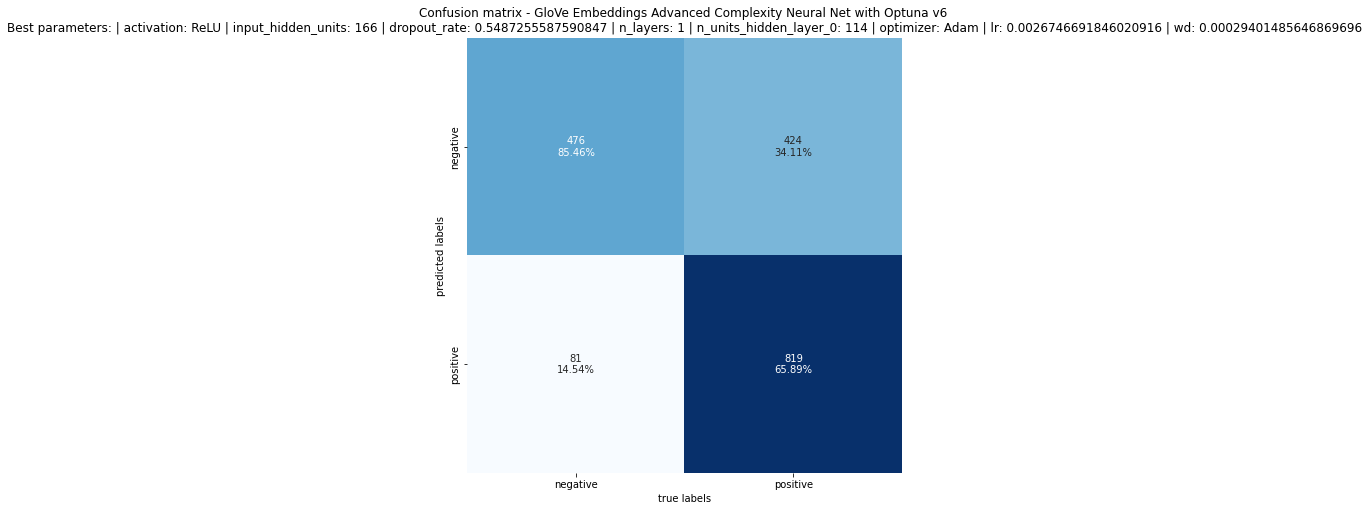

In [126]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna v6 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

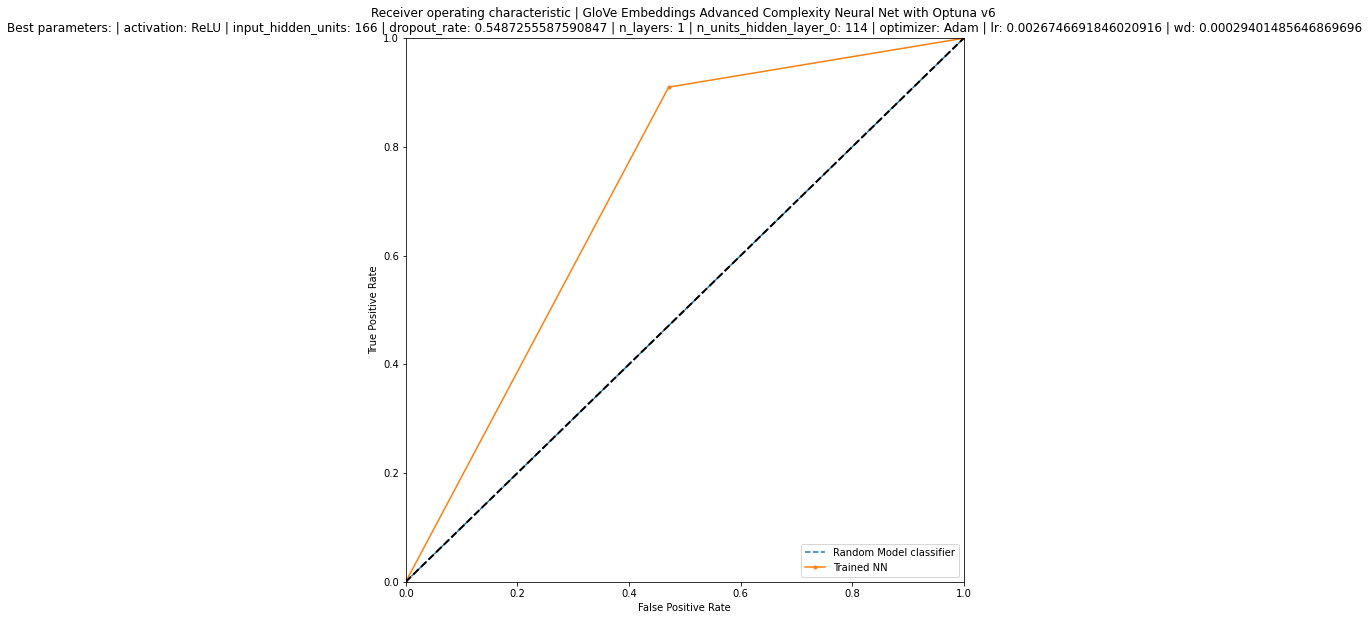

In [127]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

### Advanced Complexity model with GloVe embeddings v7

- GloVe Embeddings with 200 dimension size and pre-trained on 6B words.
- 165 words per sentence (80% of sentences length)
- 256 training batch size
- Added the three mathematical transformations on word embeddings
- 25 trials from 16
- 100 epochs from 50
- Validation size 15% from 5%
- learning rate between [0.00001, 0.0005] from [0.0005, 0.001]
- weight_decay of optimizers [0, 0.0001] from [0, 0.1]

In [29]:
class SentimentClassifier_advanced_complexity_optuna_glove_v7(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v7, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [32]:
random_seed = 1111

def objective(trial, vocab, vectors = None):
  """
  Definition
  ---------
  The objective function used by Optuna framework for every trial of different model hyper-parameters.

  Arguments
  ---------
  trial: The Optuna trial with a different sent of hyper-parameters on each run. A trial has a training progress equal to a number of epochs set by the user.
  vocab: The vocabulary object containing words from the corpus or glove pre-trained words.
  vectors: The vectors matrix. In the case of GloVe embeddings this is the the matrix with the pre-trained weights per word/token.
           In the case of trainable weigths this is None because the matrix is trained and updated after each batch with new weights.

  Output
  ---------
  The validation loss with the lowest value during the epoch training.
  For example, if on epoch 10 we had the lowest validation loss and on epoch 15 the training stopped (from the early stop mechanism),
    due to higher validation losses then the validation loss of epoch 15 is returned.
  """
  torch.manual_seed(random_seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v7(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=vectors.vectors,
    embedding_dimension=vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-5, 5e-4)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 100
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v7_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\t Val. Loss: {valid_loss:.5f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net v7"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2022-12-30 09:19:39,634] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove embeddings v7
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=172, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(516, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.40523847093492205, inplace=False)
  (output_layer): Linear(in_features=516, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 36,121 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 5.24404
	 Val. Loss: 3.03567

Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 5.13586
	 Val. Loss: 3.04793

Epoch: 03 | Epoch Time: 0m 4s
	Train Loss: 5.07098
	 Val. Loss: 3.01899

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 5.16918
	 Val. Loss: 2.96063

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 5.08661
	 Val. Loss: 2.92280


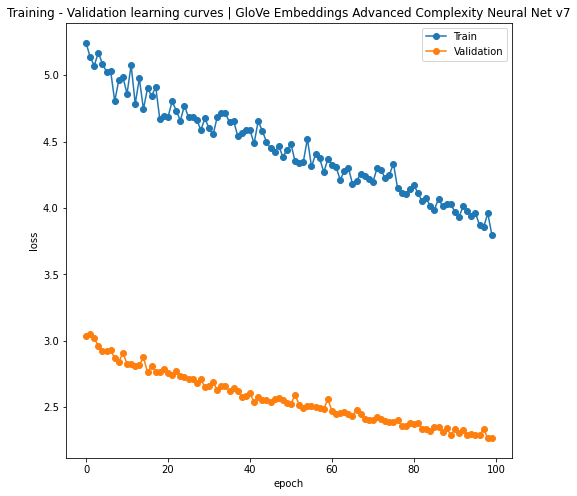

[I 2022-12-30 09:29:03,247] Trial 0 finished with value: 2.2672876757244733 and parameters: {'activation': 'Tanh', 'input_hidden_units': 172, 'dropout_rate': 0.40523847093492205, 'n_layers': 0, 'optimizer': 'SGD', 'lr': 0.0002527793572213625, 'wd': 7.844253488091157e-05}. Best is trial 0 with value: 2.2672876757244733.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=188, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(564, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3685660621956945, inplace=False)
  (output_layer): Linear(in_features=111, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=564, out_features=111, bias=True)
  (fully_connected_layer_1): BatchNorm1d(111, eps=1e-05, mom

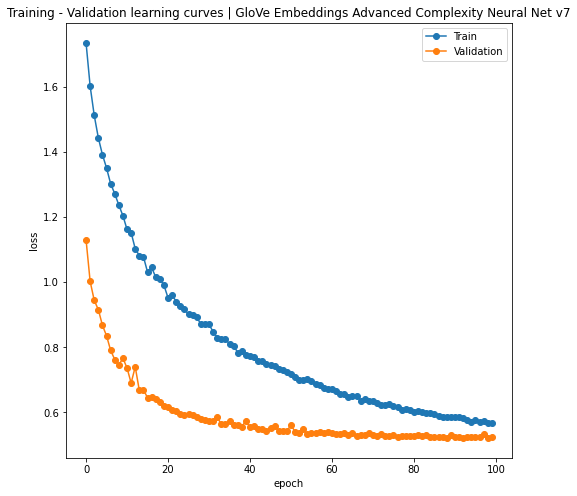

[I 2022-12-30 09:40:35,970] Trial 1 finished with value: 0.5215295151222584 and parameters: {'activation': 'Tanh', 'input_hidden_units': 188, 'dropout_rate': 0.3685660621956945, 'n_layers': 1, 'n_units_hidden_layer_0': 37, 'optimizer': 'RMSprop', 'lr': 8.273886971540655e-05, 'wd': 6.391451658585058e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=247, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(741, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6582499575867301, inplace=False)
  (output_layer): Linear(in_features=282, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=741, out_features=54, bias=True)
  (fully_connected_layer_1):

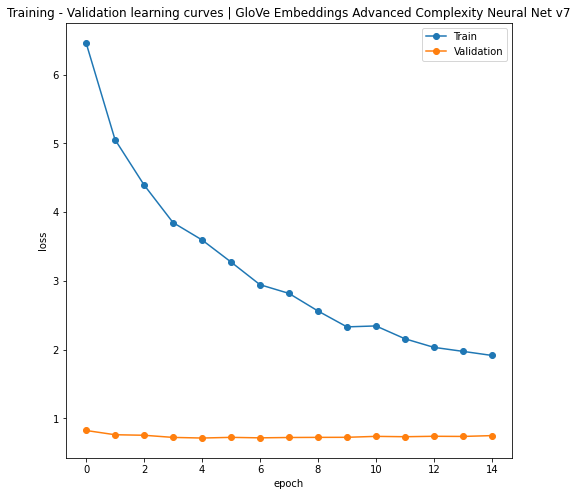

[I 2022-12-30 09:42:36,470] Trial 2 finished with value: 0.7129883100820142 and parameters: {'activation': 'ReLU', 'input_hidden_units': 247, 'dropout_rate': 0.6582499575867301, 'n_layers': 3, 'n_units_hidden_layer_0': 18, 'n_units_hidden_layer_1': 88, 'n_units_hidden_layer_2': 94, 'optimizer': 'Adam', 'lr': 0.0003967596951055383, 'wd': 3.779844120309999e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=230, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(690, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7085904585699433, inplace=False)
  (output_layer): Linear(in_features=300, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=690,

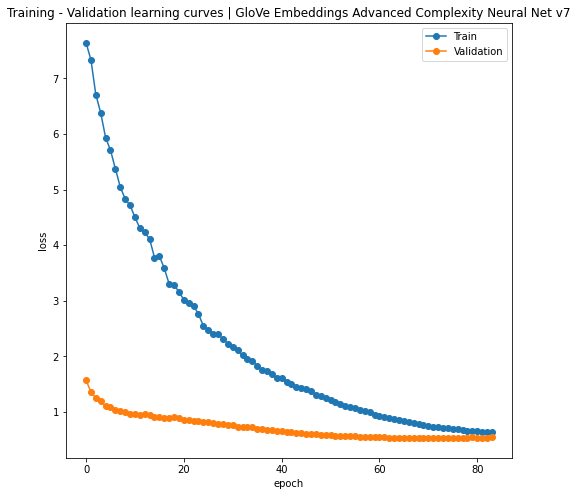

[I 2022-12-30 09:52:33,180] Trial 3 finished with value: 0.5295867912991102 and parameters: {'activation': 'Tanh', 'input_hidden_units': 230, 'dropout_rate': 0.7085904585699433, 'n_layers': 1, 'n_units_hidden_layer_0': 100, 'optimizer': 'Adam', 'lr': 0.00015715520937084962, 'wd': 3.22281521324643e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=195, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(585, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5729246909465279, inplace=False)
  (output_layer): Linear(in_features=150, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=585, out_features=42, bias=True)
  (fully_connected_layer_1): B

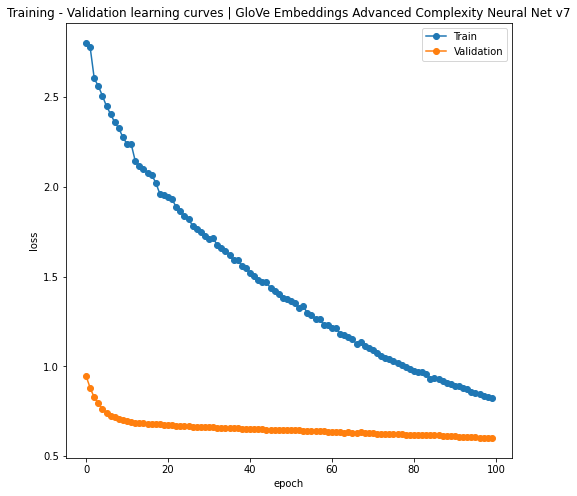

[I 2022-12-30 10:02:51,271] Trial 4 finished with value: 0.6011634191801382 and parameters: {'activation': 'Tanh', 'input_hidden_units': 195, 'dropout_rate': 0.5729246909465279, 'n_layers': 3, 'n_units_hidden_layer_0': 14, 'n_units_hidden_layer_1': 113, 'n_units_hidden_layer_2': 50, 'optimizer': 'Adam', 'lr': 7.239402348503058e-05, 'wd': 4.5520634844692865e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=163, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(489, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3661387719267212, inplace=False)
  (output_layer): Linear(in_features=222, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=48

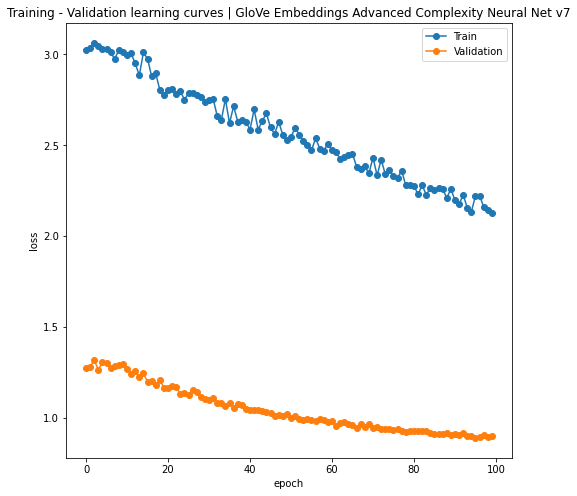

[I 2022-12-30 10:14:15,817] Trial 5 finished with value: 0.888594462427982 and parameters: {'activation': 'ReLU', 'input_hidden_units': 163, 'dropout_rate': 0.3661387719267212, 'n_layers': 3, 'n_units_hidden_layer_0': 119, 'n_units_hidden_layer_1': 128, 'n_units_hidden_layer_2': 74, 'optimizer': 'SGD', 'lr': 0.00045376485247529554, 'wd': 6.16795460792804e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=177, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(531, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.49371196797532707, inplace=False)
  (output_layer): Linear(in_features=531, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 37,171 trainable parameters

Calcu

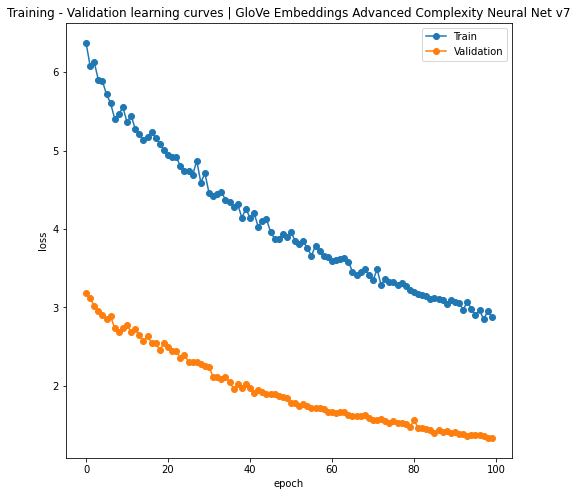

[I 2022-12-30 10:23:15,727] Trial 6 finished with value: 1.336228022741717 and parameters: {'activation': 'Tanh', 'input_hidden_units': 177, 'dropout_rate': 0.49371196797532707, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 1.6367857308869817e-05, 'wd': 4.977387349144036e-06}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=176, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3597413069733385, inplace=False)
  (output_layer): Linear(in_features=81, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=528, out_features=240, bias=True)
  (fully_connected_layer_1): BatchNorm1d(240, eps=1e-05, mom

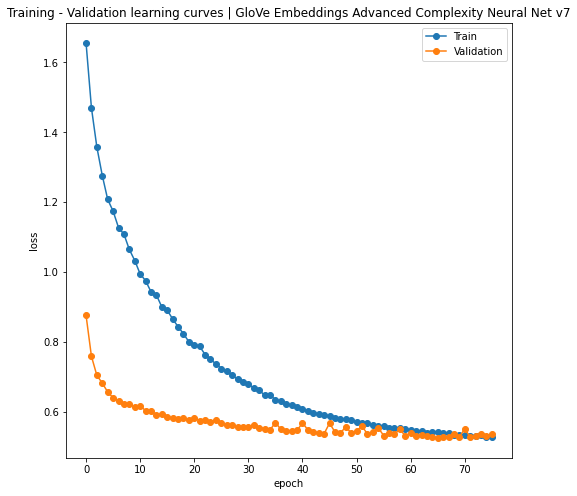

[I 2022-12-30 10:31:59,894] Trial 7 finished with value: 0.5256761347138604 and parameters: {'activation': 'Tanh', 'input_hidden_units': 176, 'dropout_rate': 0.3597413069733385, 'n_layers': 3, 'n_units_hidden_layer_0': 80, 'n_units_hidden_layer_1': 92, 'n_units_hidden_layer_2': 27, 'optimizer': 'Adam', 'lr': 0.0002175354067004886, 'wd': 6.001482130562897e-06}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=152, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.38247766197073174, inplace=False)
  (output_layer): Linear(in_features=27, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=456,

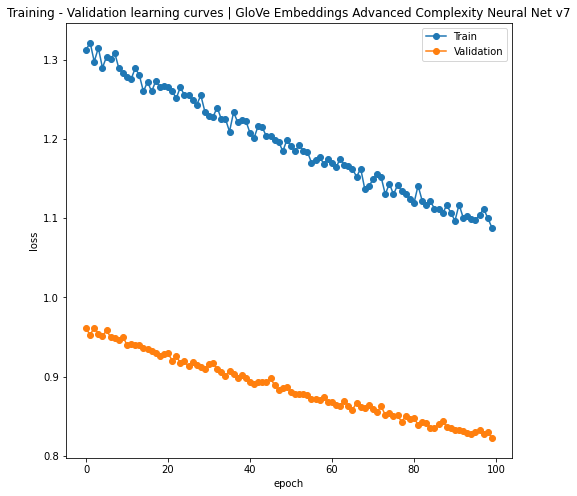

[I 2022-12-30 10:42:14,043] Trial 8 finished with value: 0.8226109895595285 and parameters: {'activation': 'Tanh', 'input_hidden_units': 152, 'dropout_rate': 0.38247766197073174, 'n_layers': 2, 'n_units_hidden_layer_0': 102, 'n_units_hidden_layer_1': 9, 'optimizer': 'SGD', 'lr': 0.00022432078895955813, 'wd': 7.3174125343221e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=178, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(534, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.439674815522812, inplace=False)
  (output_layer): Linear(in_features=324, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=534, out_features=324, bias=True)
  

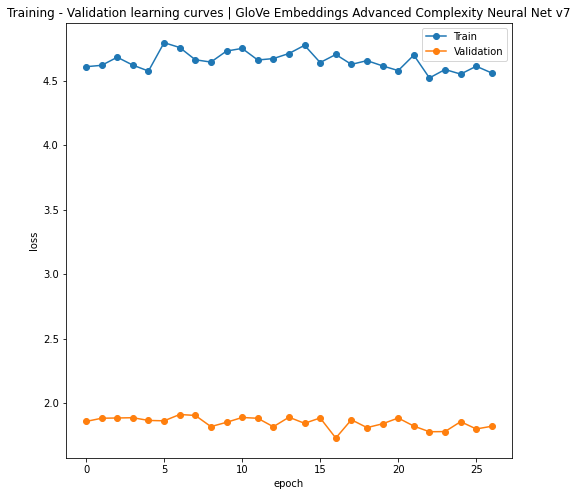

[I 2022-12-30 10:45:11,904] Trial 9 finished with value: 1.7284406257230183 and parameters: {'activation': 'ReLU', 'input_hidden_units': 178, 'dropout_rate': 0.439674815522812, 'n_layers': 1, 'n_units_hidden_layer_0': 108, 'optimizer': 'SGD', 'lr': 0.00014546324824945975, 'wd': 6.318196959958192e-05}. Best is trial 1 with value: 0.5215295151222584.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=129, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(387, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.29597885570061416, inplace=False)
  (output_layer): Linear(in_features=93, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=387, out_features=147, bias=True)
  (fully_connected_layer_1): B

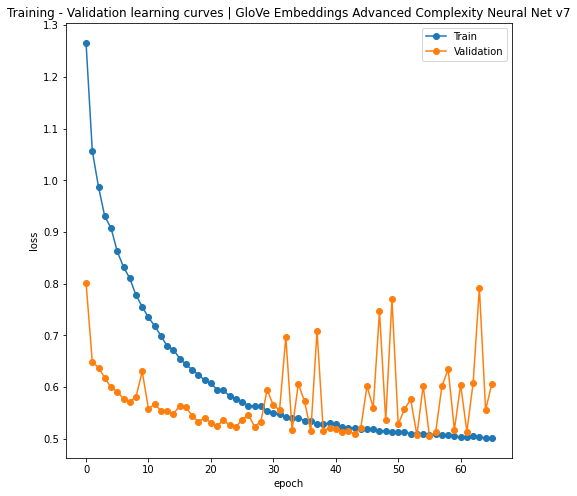

[I 2022-12-30 10:51:37,858] Trial 10 finished with value: 0.5059647608635037 and parameters: {'activation': 'Tanh', 'input_hidden_units': 129, 'dropout_rate': 0.29597885570061416, 'n_layers': 2, 'n_units_hidden_layer_0': 49, 'n_units_hidden_layer_1': 31, 'optimizer': 'RMSprop', 'lr': 0.00032486709553604983, 'wd': 9.957258324536862e-05}. Best is trial 10 with value: 0.5059647608635037.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=132, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.261927637722821, inplace=False)
  (output_layer): Linear(in_features=78, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=396, out_features=132, bias=T

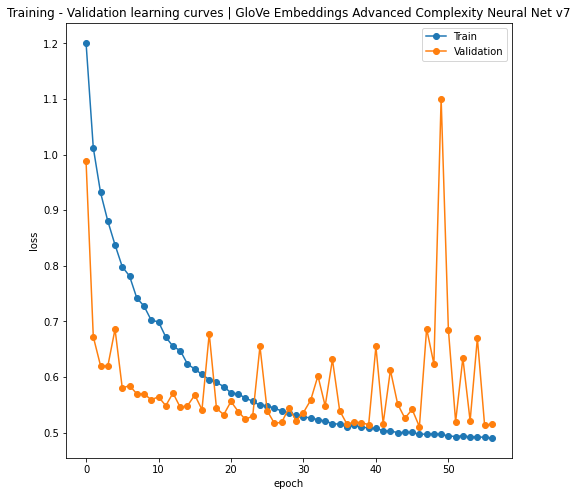

[I 2022-12-30 10:57:14,436] Trial 11 finished with value: 0.5107873782168987 and parameters: {'activation': 'Tanh', 'input_hidden_units': 132, 'dropout_rate': 0.261927637722821, 'n_layers': 2, 'n_units_hidden_layer_0': 44, 'n_units_hidden_layer_1': 26, 'optimizer': 'RMSprop', 'lr': 0.0003468913179430872, 'wd': 9.504281733623103e-05}. Best is trial 10 with value: 0.5059647608635037.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=129, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(387, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.25144197370362165, inplace=False)
  (output_layer): Linear(in_features=87, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=387, out_features=159, bias=Tr

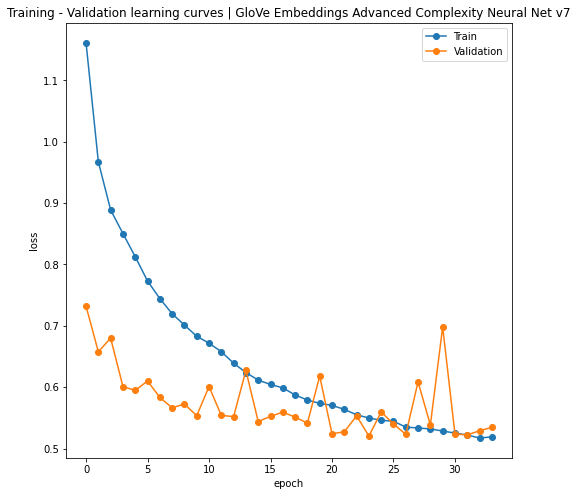

[I 2022-12-30 11:00:32,361] Trial 12 finished with value: 0.5203030047028564 and parameters: {'activation': 'Tanh', 'input_hidden_units': 129, 'dropout_rate': 0.25144197370362165, 'n_layers': 2, 'n_units_hidden_layer_0': 53, 'n_units_hidden_layer_1': 29, 'optimizer': 'RMSprop', 'lr': 0.00034631207999137045, 'wd': 9.786580431599018e-05}. Best is trial 10 with value: 0.5059647608635037.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=128, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.25003804950327463, inplace=False)
  (output_layer): Linear(in_features=120, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=384, out_features=186, bia

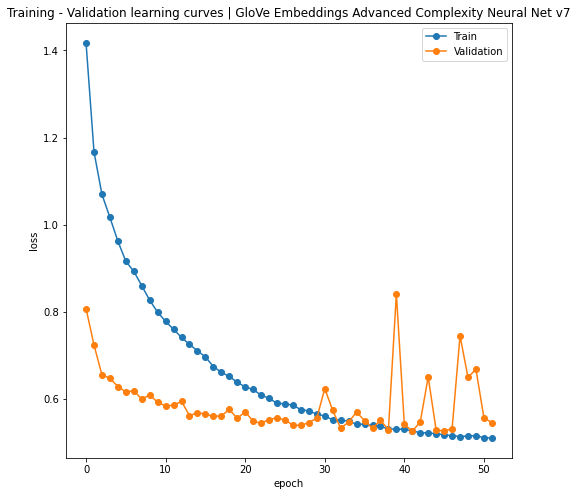

[I 2022-12-30 11:05:48,689] Trial 13 finished with value: 0.5260799686576045 and parameters: {'activation': 'Tanh', 'input_hidden_units': 128, 'dropout_rate': 0.25003804950327463, 'n_layers': 2, 'n_units_hidden_layer_0': 62, 'n_units_hidden_layer_1': 40, 'optimizer': 'RMSprop', 'lr': 0.0003359875368596459, 'wd': 9.918523797038743e-05}. Best is trial 10 with value: 0.5059647608635037.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=145, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(435, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.30081012210512303, inplace=False)
  (output_layer): Linear(in_features=147, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=435, out_features=120, bias

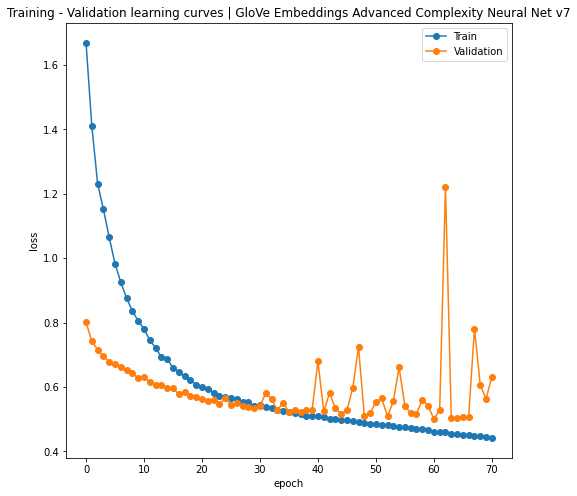

[I 2022-12-30 11:12:44,944] Trial 14 finished with value: 0.49952514227046524 and parameters: {'activation': 'ReLU', 'input_hidden_units': 145, 'dropout_rate': 0.30081012210512303, 'n_layers': 2, 'n_units_hidden_layer_0': 40, 'n_units_hidden_layer_1': 49, 'optimizer': 'RMSprop', 'lr': 0.000496887891246857, 'wd': 8.637456725418751e-05}. Best is trial 14 with value: 0.49952514227046524.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=149, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(447, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.31310007247356075, inplace=False)
  (output_layer): Linear(in_features=165, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=447, out_features=237, bia

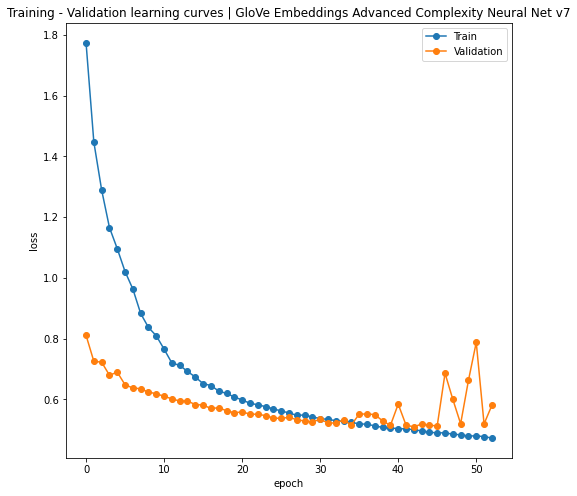

[I 2022-12-30 11:18:23,362] Trial 15 finished with value: 0.5095370661380679 and parameters: {'activation': 'ReLU', 'input_hidden_units': 149, 'dropout_rate': 0.31310007247356075, 'n_layers': 2, 'n_units_hidden_layer_0': 79, 'n_units_hidden_layer_1': 55, 'optimizer': 'RMSprop', 'lr': 0.0004927380982502123, 'wd': 8.333304343370895e-05}. Best is trial 14 with value: 0.49952514227046524.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=205, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(615, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4796013985434369, inplace=False)
  (output_layer): Linear(in_features=90, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=615, out_features=90, bias=T

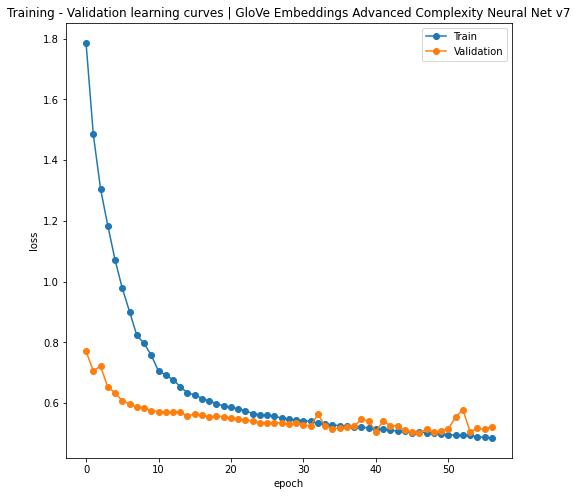

[I 2022-12-30 11:24:04,901] Trial 16 finished with value: 0.5024670071380083 and parameters: {'activation': 'ReLU', 'input_hidden_units': 205, 'dropout_rate': 0.4796013985434369, 'n_layers': 1, 'n_units_hidden_layer_0': 30, 'optimizer': 'RMSprop', 'lr': 0.0004218734386054963, 'wd': 8.608773317324003e-05}. Best is trial 14 with value: 0.49952514227046524.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=214, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(642, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.575992172508855, inplace=False)
  (output_layer): Linear(in_features=84, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=642, out_features=84, bias=True)
  (fully_connected_layer_1)

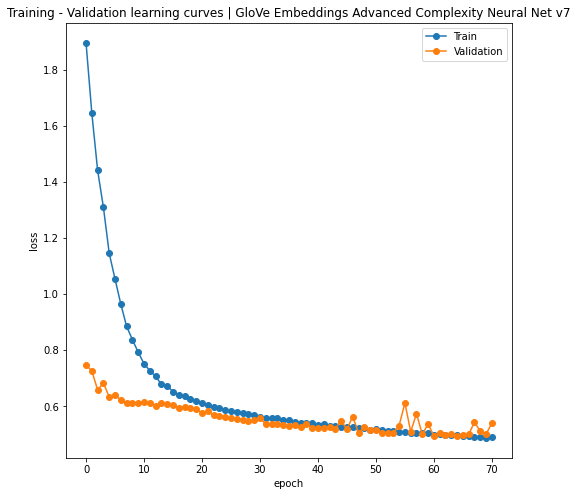

[I 2022-12-30 11:31:18,985] Trial 17 finished with value: 0.49375374095384467 and parameters: {'activation': 'ReLU', 'input_hidden_units': 214, 'dropout_rate': 0.575992172508855, 'n_layers': 1, 'n_units_hidden_layer_0': 28, 'optimizer': 'RMSprop', 'lr': 0.000426681992977496, 'wd': 8.211092080907672e-05}. Best is trial 17 with value: 0.49375374095384467.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=222, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(666, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5503698990651028, inplace=False)
  (output_layer): Linear(in_features=666, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 46,621 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01

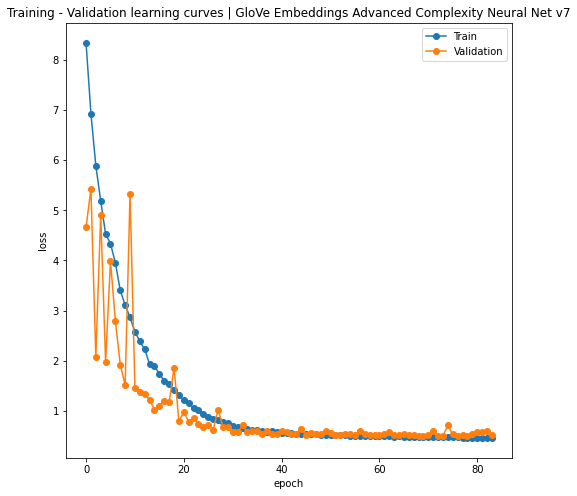

[I 2022-12-30 11:39:31,558] Trial 18 finished with value: 0.5013170491817386 and parameters: {'activation': 'ReLU', 'input_hidden_units': 222, 'dropout_rate': 0.5503698990651028, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.0004884652285744606, 'wd': 2.4797757960511968e-05}. Best is trial 17 with value: 0.49375374095384467.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=214, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(642, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6046823476787088, inplace=False)
  (output_layer): Linear(in_features=78, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=642, out_features=78, bias=True)
  (fully_connected_layer_1): BatchNorm1d(78, eps=1e-05,

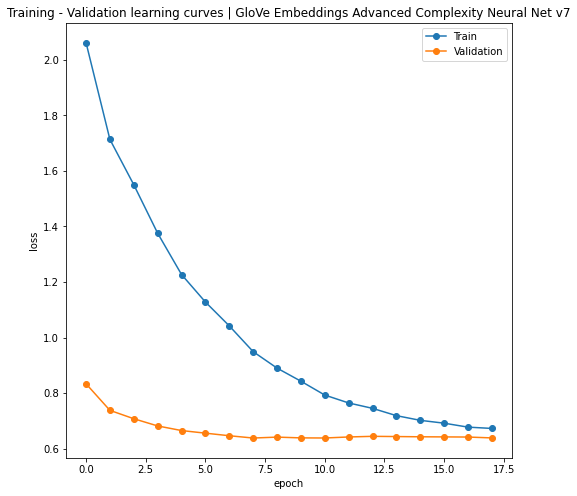

[I 2022-12-30 11:41:24,302] Trial 19 finished with value: 0.638275895007821 and parameters: {'activation': 'ReLU', 'input_hidden_units': 214, 'dropout_rate': 0.6046823476787088, 'n_layers': 1, 'n_units_hidden_layer_0': 26, 'optimizer': 'RMSprop', 'lr': 0.00040448930534314645, 'wd': 5.312832802081046e-05}. Best is trial 17 with value: 0.49375374095384467.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=253, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(759, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6323705331280041, inplace=False)
  (output_layer): Linear(in_features=27, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=759, out_features=27, bias=True)
  (fully_connected_layer_1

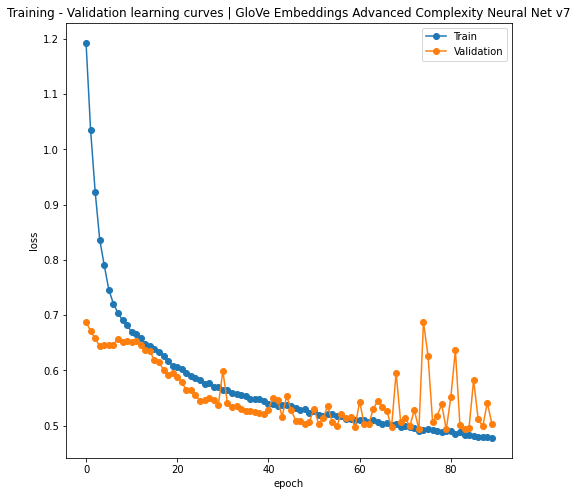

[I 2022-12-30 11:50:20,122] Trial 20 finished with value: 0.49324162962824797 and parameters: {'activation': 'ReLU', 'input_hidden_units': 253, 'dropout_rate': 0.6323705331280041, 'n_layers': 1, 'n_units_hidden_layer_0': 9, 'optimizer': 'RMSprop', 'lr': 0.0004418792060741917, 'wd': 7.360988478633294e-05}. Best is trial 20 with value: 0.49324162962824797.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=256, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6415794695659072, inplace=False)
  (output_layer): Linear(in_features=30, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=768, out_features=30, bias=True)
  (fully_connected_layer_1

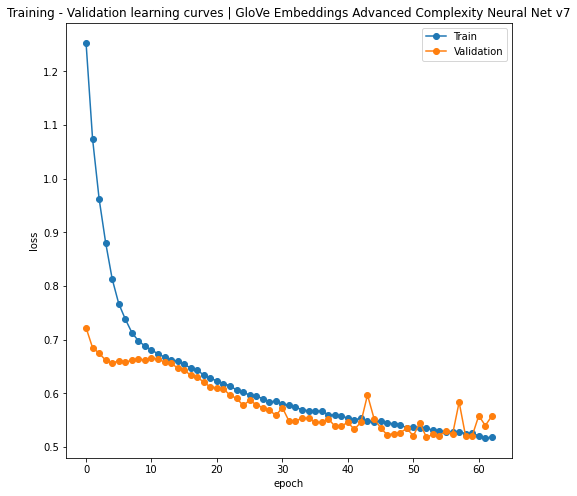

[I 2022-12-30 11:56:49,928] Trial 21 finished with value: 0.5177937350993933 and parameters: {'activation': 'ReLU', 'input_hidden_units': 256, 'dropout_rate': 0.6415794695659072, 'n_layers': 1, 'n_units_hidden_layer_0': 10, 'optimizer': 'RMSprop', 'lr': 0.00045116238604396314, 'wd': 7.148028432087278e-05}. Best is trial 20 with value: 0.49324162962824797.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=237, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(711, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7154402139763469, inplace=False)
  (output_layer): Linear(in_features=72, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=711, out_features=72, bias=True)
  (fully_connected_layer_

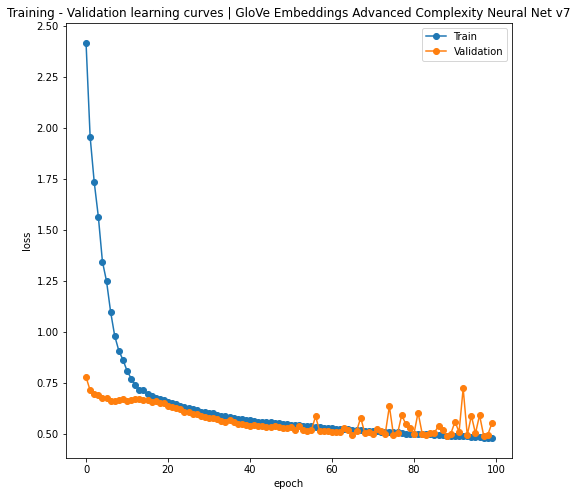

[I 2022-12-30 12:07:01,249] Trial 22 finished with value: 0.4912479325782421 and parameters: {'activation': 'ReLU', 'input_hidden_units': 237, 'dropout_rate': 0.7154402139763469, 'n_layers': 1, 'n_units_hidden_layer_0': 24, 'optimizer': 'RMSprop', 'lr': 0.0004504178055834754, 'wd': 8.686761521578638e-05}. Best is trial 22 with value: 0.4912479325782421.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=237, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(711, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7178713552804071, inplace=False)
  (output_layer): Linear(in_features=711, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 49,771 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01

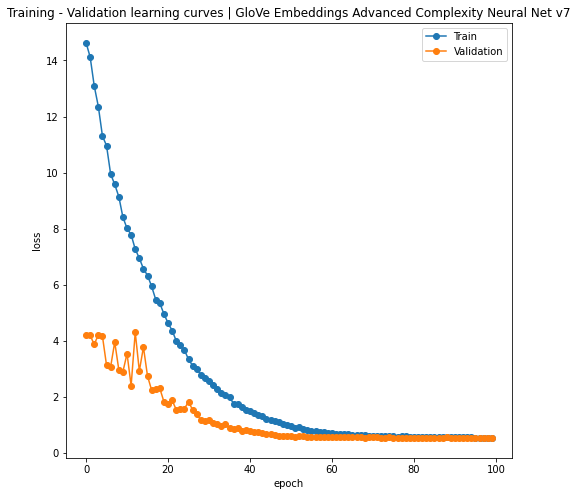

[I 2022-12-30 12:16:46,674] Trial 23 finished with value: 0.5277993096861728 and parameters: {'activation': 'ReLU', 'input_hidden_units': 237, 'dropout_rate': 0.7178713552804071, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.00029647365297631804, 'wd': 7.112458741394537e-05}. Best is trial 22 with value: 0.4912479325782421.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 200, padding_idx=0)
  (input_layer): Linear(in_features=200, out_features=240, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7492389642384849, inplace=False)
  (output_layer): Linear(in_features=27, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=720, out_features=27, bias=True)
  (fully_connected_layer_1): BatchNorm1d(27, eps=1e-05, 

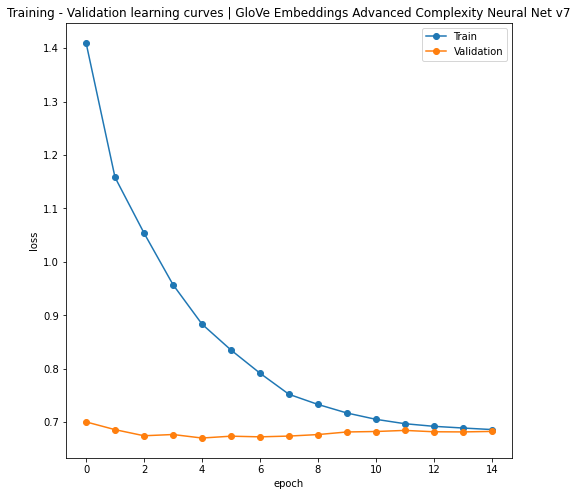

[I 2022-12-30 12:18:18,826] Trial 24 finished with value: 0.6704062639280807 and parameters: {'activation': 'ReLU', 'input_hidden_units': 240, 'dropout_rate': 0.7492389642384849, 'n_layers': 1, 'n_units_hidden_layer_0': 9, 'optimizer': 'RMSprop', 'lr': 0.0003794733912928889, 'wd': 8.984721898653098e-05}. Best is trial 22 with value: 0.4912479325782421.


In [33]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial, glove_vocab_200, glove_vectors_200)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v7",
    sampler=optuna.samplers.TPESampler(seed=random_seed),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(trial_validation_loss, n_trials=25, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [34]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v7.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v7.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v7.pt")


Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:    0
  Number of complete trials:  25

Best trial: 

Best model validation loss value: 0.4912479325782421

Best trial number: 22

Best model parameters: 

activation: ReLU

input_hidden_units: 237

dropout_rate: 0.7154402139763469

n_layers: 1

n_units_hidden_layer_0: 24

optimizer: RMSprop

lr: 0.0004504178055834754

wd: 8.686761521578638e-05


Evaluation metrics: GloVe Embeddings Advanced Complexity Neural Net with Optuna v7 
Best parameters: | activation: ReLU | input_hidden_units: 237 | dropout_rate: 0.7154402139763469 | n_layers: 1 | n_units_hidden_layer_0: 24 | optimizer: RMSprop | lr: 0.0004504178055834754 | wd: 8.686761521578638e-05 

precision score: 0.8330 
recall_score: 0.5819 
roc score: 0.7326 
f1_score: 0.6851

model bias: 0.0454
model variance: 0.2273


              precision    recall  f1-score   support

    negative       0.68      0.88      0.77      2700
    positive       0.83      0.58      0.69      2700

    accuracy                           0.73      5400
   macro avg       0.76      0.73      0.73      5400
weighted avg       0.76      0.73      0.73      5400





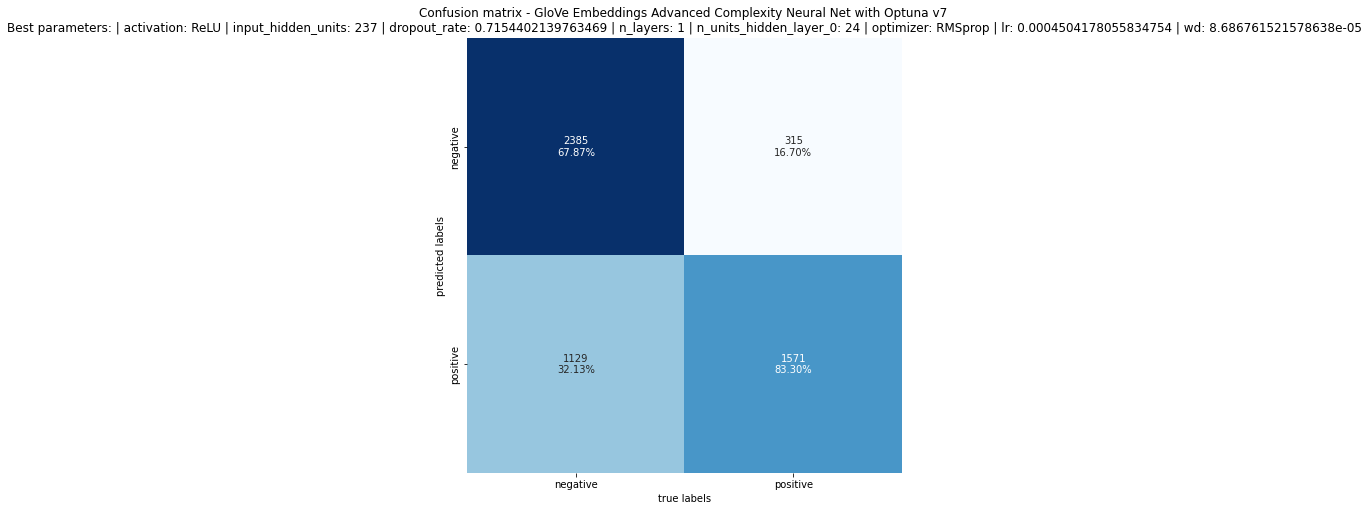

In [35]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna v7 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

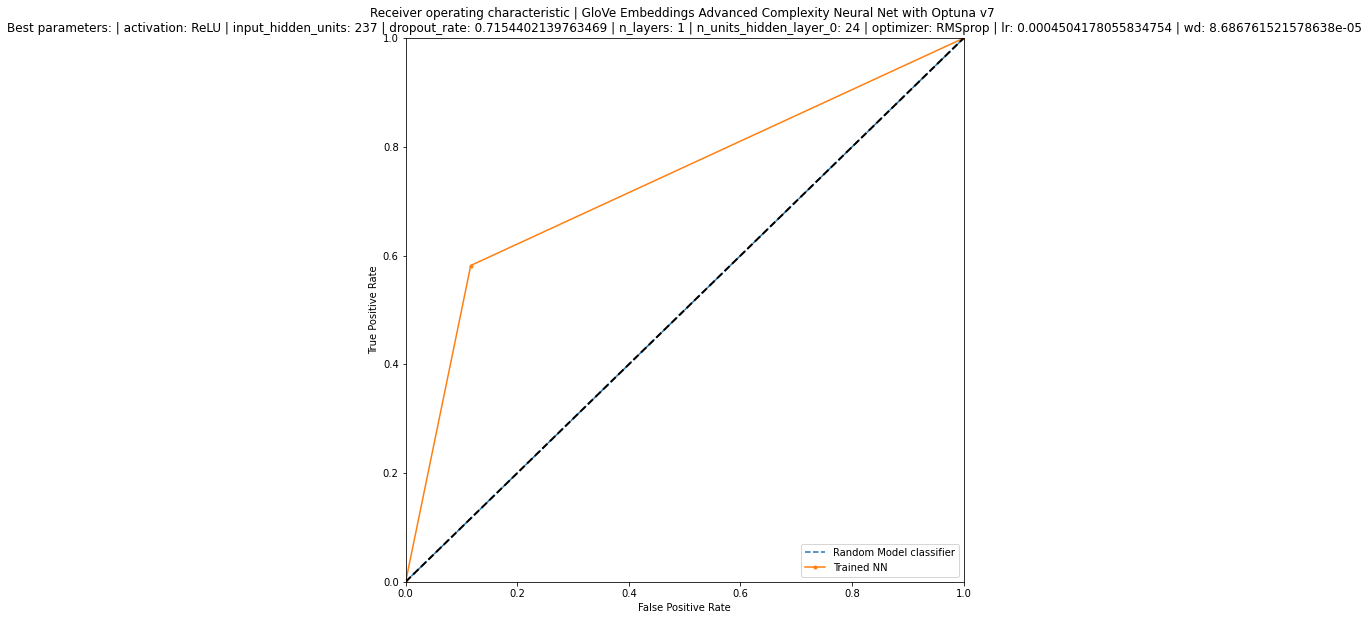

In [36]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

### Advanced Complexity model with GloVe embeddings v8

- GloVe Embeddings with 50 dimension size and pre-trained on 6B words.
- 165 words per sentence (80% of sentences length)
- 256 training batch size
- Added the three mathematical transformations on word embeddings
- 25 trials from 16
- 150 epochs from 50
- Validation size 15% from 5%
- learning rate between [0.00001, 0.0005] from [0.0005, 0.001]
- weight_decay of optimizers [0, 0.0001] from [0, 0.1]

In [53]:
class SentimentClassifier_advanced_complexity_optuna_glove_v8(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v8, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = vocab[unk_token]

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

In [54]:
random_seed = 2222

def objective(trial, vocab, vectors = None):
  """
  Definition
  ---------
  The objective function used by Optuna framework for every trial of different model hyper-parameters.

  Arguments
  ---------
  trial: The Optuna trial with a different sent of hyper-parameters on each run. A trial has a training progress equal to a number of epochs set by the user.
  vocab: The vocabulary object containing words from the corpus or glove pre-trained words.
  vectors: The vectors matrix. In the case of GloVe embeddings this is the the matrix with the pre-trained weights per word/token.
           In the case of trainable weigths this is None because the matrix is trained and updated after each batch with new weights.

  Output
  ---------
  The validation loss with the lowest value during the epoch training.
  For example, if on epoch 10 we had the lowest validation loss and on epoch 15 the training stopped (from the early stop mechanism),
    due to higher validation losses then the validation loss of epoch 15 is returned.
  """
  torch.manual_seed(random_seed)

  # Initialize Feed-Forward Neural Network
  model = SentimentClassifier_advanced_complexity_optuna_glove_v7(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation=trial.suggest_categorical('activation',["ReLU", "Tanh"]),
    use_pretrained_embeddings=True,
    embedding_matrix=vectors.vectors,
    embedding_dimension=vectors.dim
  )

  trial.set_user_attr(key="best_model_classifier", value=model)

  # Calculate total trainable parameter
  print("\n",model)
  print(f'\nThe model has {count_parameters(model):,} trainable parameters')

  # Initialize loss function method
  loss_func = torch.nn.BCELoss()
  print(f"\nCalculating train/validation loss using: {loss_func}")

  optimizer_name = trial.suggest_categorical('optimizer',["Adam", "RMSprop", "SGD"])
  learning_rate = trial.suggest_float('lr', 1e-5, 5e-4)
  weight_decay = trial.suggest_float('wd', 0.0, 1e-4)
  optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), learning_rate, weight_decay=weight_decay)

  # Initialize loss arrays
  train_losses = []
  validation_losses = []
  n_epoch = 150
  early_stopper = EarlyStopper()

  for epoch in range(1, n_epoch + 1):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, loss_func, train_losses)
    valid_loss = evaluate(model, valid_loader, loss_func, validation_losses)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    embeddings_type = "glove"
    complexity_type = "advanced"
    torch.save(model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v8_{trial.number}.pt")

    boolean, best_validation_loss = early_stopper.early_stop(valid_loss)
    if boolean:
      break

    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()

    print(f'\nEpoch: {epoch:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\t Val. Loss: {valid_loss:.5f}')

  # Plot training, validation losses per epoch (learning curves)
  graph_name = "GloVe Embeddings Advanced Complexity Neural Net v8"
  plot_learning_curves(train_losses, validation_losses, graph_name)

  return best_validation_loss

[I 2022-12-30 14:21:12,911] A new study created in memory with name: hyper-parameter tuning of baseline classifier with glove embeddings v8
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]


 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=237, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(711, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6135304036216831, inplace=False)
  (output_layer): Linear(in_features=711, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 14,221 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 10.69520
	 Val. Loss: 3.78354

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 9.07063
	 Val. Loss: 2.97899

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 8.44574
	 Val. Loss: 2.54001

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 7.40169
	 Val. Loss: 3.15443

Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 6.56746
	 Val. Loss: 3.12592

E

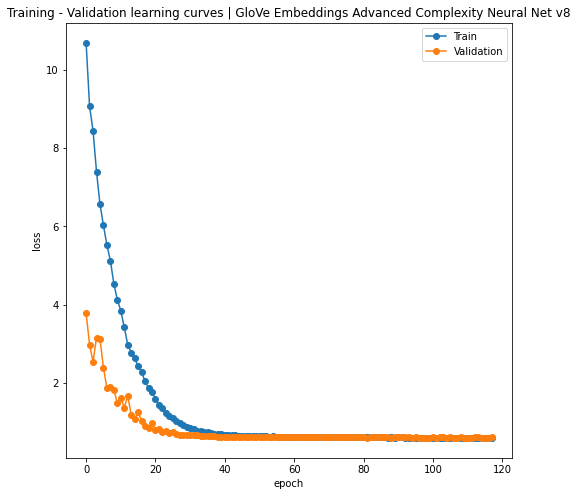

[I 2022-12-30 14:25:13,420] Trial 0 finished with value: 0.6007858542508857 and parameters: {'activation': 'ReLU', 'input_hidden_units': 237, 'dropout_rate': 0.6135304036216831, 'n_layers': 0, 'optimizer': 'RMSprop', 'lr': 0.0004960779439381708, 'wd': 2.5845015139148877e-05}. Best is trial 0 with value: 0.6007858542508857.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=212, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(636, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6452964907253852, inplace=False)
  (output_layer): Linear(in_features=285, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=636, out_features=285, bias=True)
  (fully_connected_layer_1): BatchNorm1d(285, eps=1e-05, m

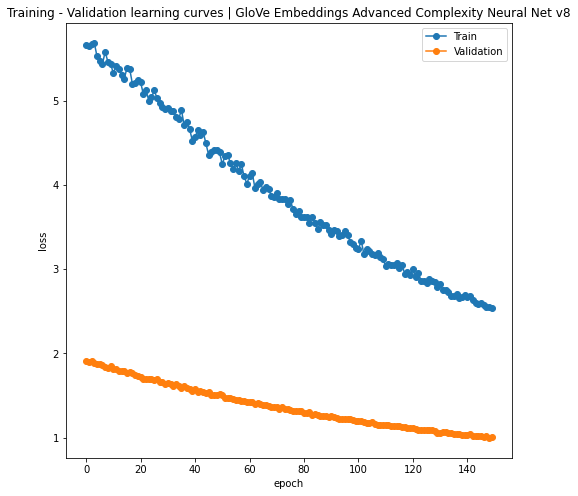

[I 2022-12-30 14:31:38,947] Trial 1 finished with value: 0.9955353501231171 and parameters: {'activation': 'Tanh', 'input_hidden_units': 212, 'dropout_rate': 0.6452964907253852, 'n_layers': 1, 'n_units_hidden_layer_0': 95, 'optimizer': 'SGD', 'lr': 0.0004535700792525671, 'wd': 3.696302016800204e-05}. Best is trial 0 with value: 0.6007858542508857.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=198, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(594, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.552598807843882, inplace=False)
  (output_layer): Linear(in_features=267, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=594, out_features=267, bias=True)
  (fully_connected_layer_1): Batch

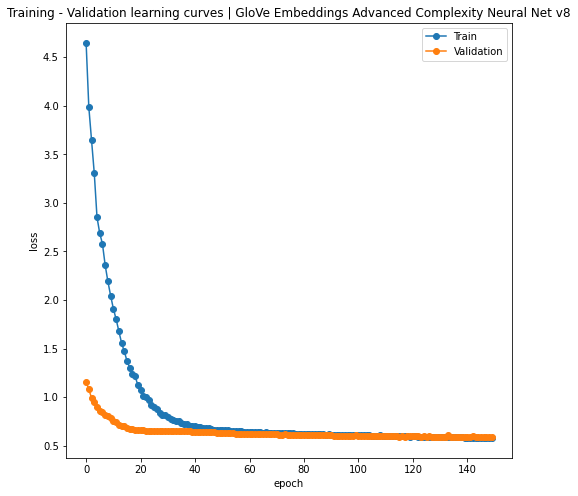

[I 2022-12-30 14:38:07,855] Trial 2 finished with value: 0.5869419013344964 and parameters: {'activation': 'ReLU', 'input_hidden_units': 198, 'dropout_rate': 0.552598807843882, 'n_layers': 1, 'n_units_hidden_layer_0': 89, 'optimizer': 'Adam', 'lr': 0.00035238178971545403, 'wd': 8.458034000965926e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=251, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(753, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.510325985831432, inplace=False)
  (output_layer): Linear(in_features=72, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=753, out_features=285, bias=True)
  (fully_connected_layer_1): Batch

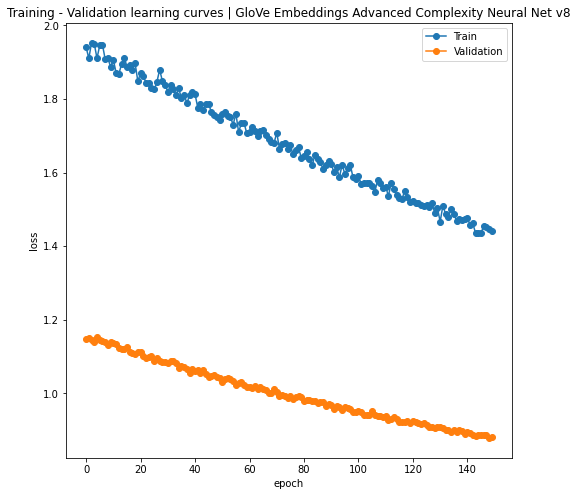

[I 2022-12-30 14:45:21,968] Trial 3 finished with value: 0.8786878239276797 and parameters: {'activation': 'Tanh', 'input_hidden_units': 251, 'dropout_rate': 0.510325985831432, 'n_layers': 2, 'n_units_hidden_layer_0': 95, 'n_units_hidden_layer_1': 24, 'optimizer': 'SGD', 'lr': 0.00021611771693818546, 'wd': 3.307903384352551e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=175, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(525, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3160361621839054, inplace=False)
  (output_layer): Linear(in_features=525, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 10,501 trainable parameters

Calculating train/validation loss using

[I 2022-12-30 14:50:28,314] Trial 4 finished with value: 0.5983497472696526 and parameters: {'activation': 'Tanh', 'input_hidden_units': 175, 'dropout_rate': 0.3160361621839054, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.00013096650207463127, 'wd': 7.826824168570074e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=183, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(549, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5400474258738878, inplace=False)
  (output_layer): Linear(in_features=267, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=549, out_features=267, bias=True)
  (fully_connected_layer_1): BatchNorm1d(267, eps=1e-05, mome

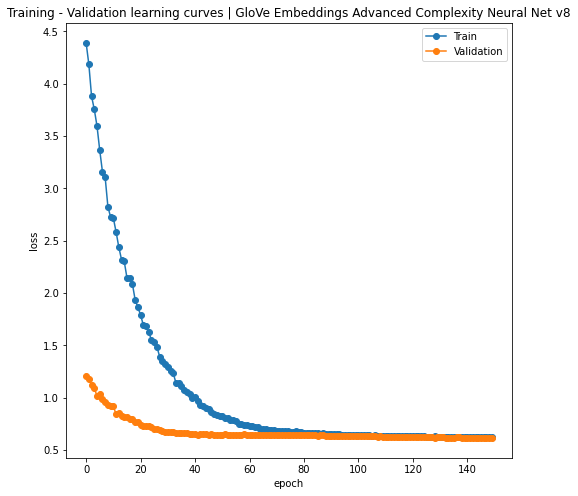

[I 2022-12-30 14:57:00,474] Trial 5 finished with value: 0.6143484794816305 and parameters: {'activation': 'ReLU', 'input_hidden_units': 183, 'dropout_rate': 0.5400474258738878, 'n_layers': 1, 'n_units_hidden_layer_0': 89, 'optimizer': 'RMSprop', 'lr': 0.00016988159830879935, 'wd': 2.264412251285997e-06}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=165, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(495, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.505981429070091, inplace=False)
  (output_layer): Linear(in_features=288, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=495, out_features=288, bias=True)
  (fully_connected_layer_1): 

[I 2022-12-30 15:03:22,901] Trial 6 finished with value: 1.0924953139105509 and parameters: {'activation': 'Tanh', 'input_hidden_units': 165, 'dropout_rate': 0.505981429070091, 'n_layers': 1, 'n_units_hidden_layer_0': 96, 'optimizer': 'SGD', 'lr': 0.0003998318137364676, 'wd': 2.436039994363547e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=193, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(579, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7066054609442596, inplace=False)
  (output_layer): Linear(in_features=57, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=579, out_features=81, bias=True)
  (fully_connected_layer_1): BatchNo

[I 2022-12-30 15:10:24,569] Trial 7 finished with value: 0.6377682699713596 and parameters: {'activation': 'ReLU', 'input_hidden_units': 193, 'dropout_rate': 0.7066054609442596, 'n_layers': 3, 'n_units_hidden_layer_0': 27, 'n_units_hidden_layer_1': 63, 'n_units_hidden_layer_2': 19, 'optimizer': 'RMSprop', 'lr': 0.00039017930908592406, 'wd': 6.194012591553763e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=175, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(525, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.49691397789940245, inplace=False)
  (output_layer): Linear(in_features=525, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 10,501 trainable parameters

Cal

[I 2022-12-30 15:12:06,821] Trial 8 finished with value: 0.5953067880730296 and parameters: {'activation': 'Tanh', 'input_hidden_units': 175, 'dropout_rate': 0.49691397789940245, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0004802960680263697, 'wd': 9.014225817480512e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=232, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(696, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5651414239498191, inplace=False)
  (output_layer): Linear(in_features=306, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=696, out_features=138, bias=True)
  (fully_connected_layer_1): BatchNorm1d(138, eps=1e-05, mome

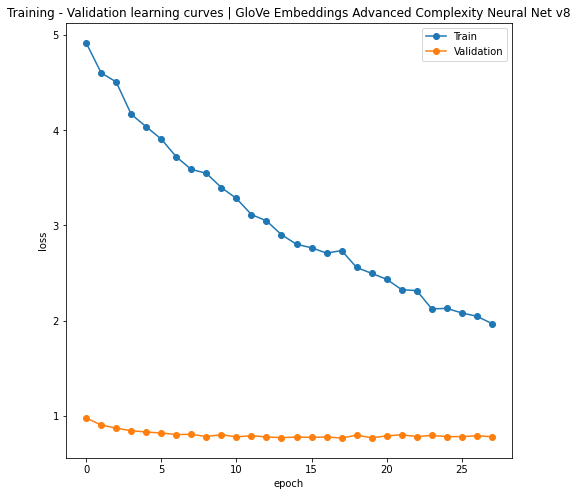

[I 2022-12-30 15:13:23,301] Trial 9 finished with value: 0.7669128137965535 and parameters: {'activation': 'ReLU', 'input_hidden_units': 232, 'dropout_rate': 0.5651414239498191, 'n_layers': 2, 'n_units_hidden_layer_0': 46, 'n_units_hidden_layer_1': 102, 'optimizer': 'RMSprop', 'lr': 0.0001412350617316995, 'wd': 8.977221666954656e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=132, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(396, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.37807789159503663, inplace=False)
  (output_layer): Linear(in_features=363, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=396, out_features=375, bias=Tru

[I 2022-12-30 15:21:56,353] Trial 10 finished with value: 0.8128682416538859 and parameters: {'activation': 'ReLU', 'input_hidden_units': 132, 'dropout_rate': 0.37807789159503663, 'n_layers': 3, 'n_units_hidden_layer_0': 125, 'n_units_hidden_layer_1': 119, 'n_units_hidden_layer_2': 121, 'optimizer': 'Adam', 'lr': 1.0539115524521754e-05, 'wd': 6.482144462150844e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=152, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(456, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.41632886683885423, inplace=False)
  (output_layer): Linear(in_features=456, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 9,121 trainable parameters

Ca

[I 2022-12-30 15:24:12,847] Trial 11 finished with value: 0.5946756192418032 and parameters: {'activation': 'Tanh', 'input_hidden_units': 152, 'dropout_rate': 0.41632886683885423, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0003113638976556442, 'wd': 9.998961067731874e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=141, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(423, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.41582227088654133, inplace=False)
  (output_layer): Linear(in_features=423, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
)

The model has 8,461 trainable parameters

Calculating train/validation loss using: BCELoss()

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 5

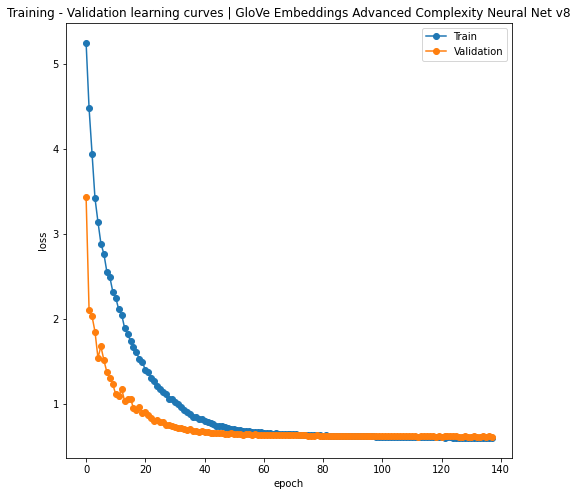

[I 2022-12-30 15:28:35,449] Trial 12 finished with value: 0.611198308162911 and parameters: {'activation': 'ReLU', 'input_hidden_units': 141, 'dropout_rate': 0.41582227088654133, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.00031286446864883354, 'wd': 9.988766209081773e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=155, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(465, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.26305857852667874, inplace=False)
  (output_layer): Linear(in_features=186, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=465, out_features=186, bias=True)
  (fully_connected_layer_1): BatchNorm1d(186, eps=1e-05, mo

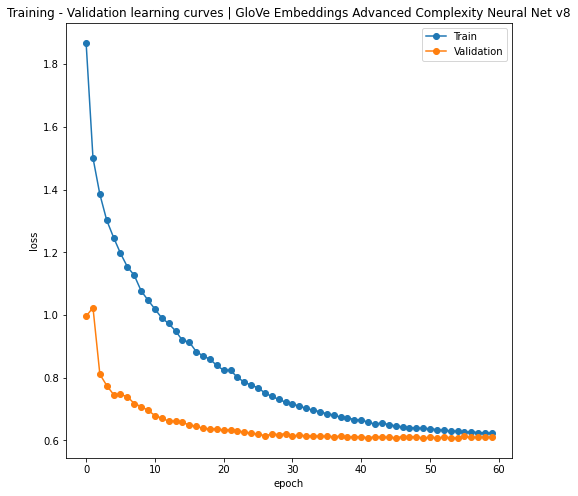

[I 2022-12-30 15:30:59,058] Trial 13 finished with value: 0.6075593607370243 and parameters: {'activation': 'Tanh', 'input_hidden_units': 155, 'dropout_rate': 0.26305857852667874, 'n_layers': 1, 'n_units_hidden_layer_0': 62, 'optimizer': 'Adam', 'lr': 0.0003106540223496152, 'wd': 7.456878563222687e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=203, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(609, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.40527486405666724, inplace=False)
  (output_layer): Linear(in_features=36, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=609, out_features=24, bias=True)
  (fully_connected_layer_1): Ba

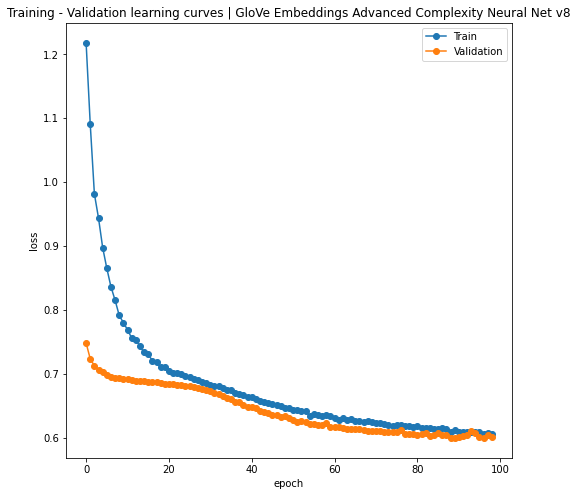

[I 2022-12-30 15:34:58,194] Trial 14 finished with value: 0.5994859199191249 and parameters: {'activation': 'ReLU', 'input_hidden_units': 203, 'dropout_rate': 0.40527486405666724, 'n_layers': 2, 'n_units_hidden_layer_0': 8, 'n_units_hidden_layer_1': 12, 'optimizer': 'Adam', 'lr': 0.00030276750312400417, 'wd': 9.84218079284325e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=212, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(636, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.4491067674554582, inplace=False)
  (output_layer): Linear(in_features=636, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 12,721 trainable parameters

Calculating train/validation loss usi

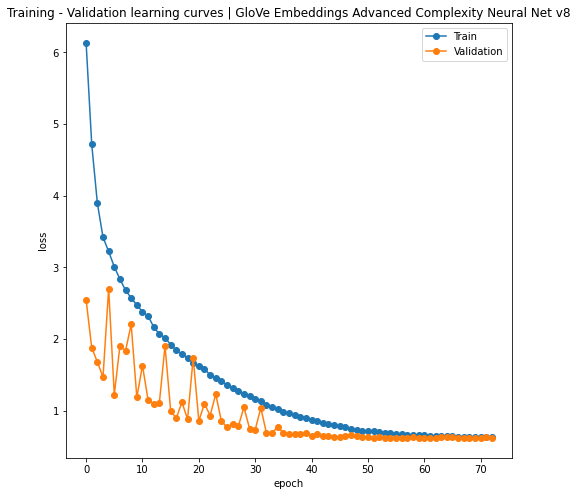

[I 2022-12-30 15:37:30,266] Trial 15 finished with value: 0.6185754606890124 and parameters: {'activation': 'Tanh', 'input_hidden_units': 212, 'dropout_rate': 0.4491067674554582, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0003849440304462822, 'wd': 7.879697606888752e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=155, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(465, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7421332788450441, inplace=False)
  (output_layer): Linear(in_features=378, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=465, out_features=378, bias=True)
  (fully_connected_layer_1): BatchNorm1d(378, eps=1e-05, mome

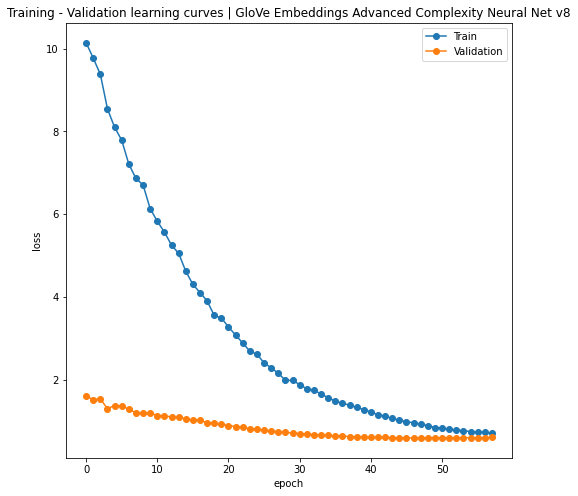

[I 2022-12-30 15:40:11,673] Trial 16 finished with value: 0.5871655566747799 and parameters: {'activation': 'Tanh', 'input_hidden_units': 155, 'dropout_rate': 0.7421332788450441, 'n_layers': 1, 'n_units_hidden_layer_0': 126, 'optimizer': 'Adam', 'lr': 0.00024814714428715064, 'wd': 5.397697605800338e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=189, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(567, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7394158184733801, inplace=False)
  (output_layer): Linear(in_features=384, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=567, out_features=384, bias=True)
  (fully_connected_layer_1): 

[I 2022-12-30 15:47:26,715] Trial 17 finished with value: 0.6158436037773309 and parameters: {'activation': 'ReLU', 'input_hidden_units': 189, 'dropout_rate': 0.7394158184733801, 'n_layers': 1, 'n_units_hidden_layer_0': 128, 'optimizer': 'Adam', 'lr': 0.000243289433223466, 'wd': 5.0890503051174835e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=161, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(483, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6643974704754769, inplace=False)
  (output_layer): Linear(in_features=192, out_features=1, bias=True)
  (activation): ReLU()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=483, out_features=333, bias=True)
  (fully_connected_layer_1): B

[I 2022-12-30 15:49:21,361] Trial 18 finished with value: 0.6884880772856778 and parameters: {'activation': 'ReLU', 'input_hidden_units': 161, 'dropout_rate': 0.6643974704754769, 'n_layers': 2, 'n_units_hidden_layer_0': 111, 'n_units_hidden_layer_1': 64, 'optimizer': 'Adam', 'lr': 0.0001994974611137268, 'wd': 4.94472519642698e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=141, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(423, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.5867371270474236, inplace=False)
  (output_layer): Linear(in_features=222, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=423, out_features=222, bias=True)
 

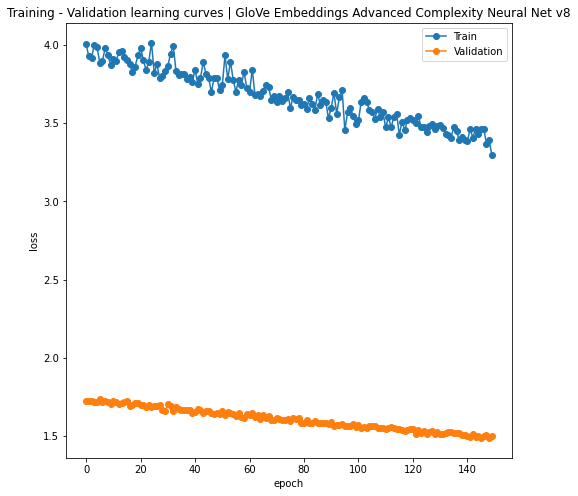

[I 2022-12-30 15:55:00,862] Trial 19 finished with value: 1.487746029399162 and parameters: {'activation': 'Tanh', 'input_hidden_units': 141, 'dropout_rate': 0.5867371270474236, 'n_layers': 1, 'n_units_hidden_layer_0': 74, 'optimizer': 'SGD', 'lr': 8.137619054101653e-05, 'wd': 2.2534589174275785e-06}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=223, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(669, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.7467183822242026, inplace=False)
  (output_layer): Linear(in_features=279, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=669, out_features=336, bias=True)
  (fully_connected_layer_1): Bat

[I 2022-12-30 15:57:23,750] Trial 20 finished with value: 0.629536226738331 and parameters: {'activation': 'Tanh', 'input_hidden_units': 223, 'dropout_rate': 0.7467183822242026, 'n_layers': 2, 'n_units_hidden_layer_0': 112, 'n_units_hidden_layer_1': 93, 'optimizer': 'Adam', 'lr': 0.000263387944135391, 'wd': 5.319128494876736e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=145, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(435, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.3446655054000391, inplace=False)
  (output_layer): Linear(in_features=435, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
)

The model has 8,701 trainable parameters

Calculating train/validation loss using

[I 2022-12-30 15:59:56,769] Trial 21 finished with value: 0.6025178862172503 and parameters: {'activation': 'Tanh', 'input_hidden_units': 145, 'dropout_rate': 0.3446655054000391, 'n_layers': 0, 'optimizer': 'Adam', 'lr': 0.0003572877617648009, 'wd': 8.455918154245718e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=156, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(468, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.45509866263088355, inplace=False)
  (output_layer): Linear(in_features=213, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=468, out_features=213, bias=True)
  (fully_connected_layer_1): BatchNorm1d(213, eps=1e-05, mom

[I 2022-12-30 16:02:11,134] Trial 22 finished with value: 0.6090652755526609 and parameters: {'activation': 'Tanh', 'input_hidden_units': 156, 'dropout_rate': 0.45509866263088355, 'n_layers': 1, 'n_units_hidden_layer_0': 71, 'optimizer': 'Adam', 'lr': 0.0002660330265741851, 'wd': 9.179031236290018e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=174, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(522, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6764837538786803, inplace=False)
  (output_layer): Linear(in_features=333, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=522, out_features=333, bias=True)
  (fully_connected_layer_1): B

[I 2022-12-30 16:04:19,042] Trial 23 finished with value: 0.5926014836444411 and parameters: {'activation': 'Tanh', 'input_hidden_units': 174, 'dropout_rate': 0.6764837538786803, 'n_layers': 1, 'n_units_hidden_layer_0': 111, 'optimizer': 'Adam', 'lr': 0.0003404616556367547, 'wd': 6.840844511107994e-05}. Best is trial 2 with value: 0.5869419013344964.

 SentimentClassifier_advanced_complexity_optuna_glove_v7(
  (embedding): Embedding(400000, 50, padding_idx=0)
  (input_layer): Linear(in_features=50, out_features=172, bias=True)
  (flatten_layer): Flatten(start_dim=1, end_dim=-1)
  (normalize_input_layer): BatchNorm1d(516, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_input_layer): Dropout(p=0.6852493702048258, inplace=False)
  (output_layer): Linear(in_features=336, out_features=1, bias=True)
  (activation): Tanh()
  (activation_output): Sigmoid()
  (fully_connected_layer_0): Linear(in_features=516, out_features=336, bias=True)
  (fully_connected_layer_1): B

[I 2022-12-30 16:06:00,820] Trial 24 finished with value: 0.6028429969798687 and parameters: {'activation': 'Tanh', 'input_hidden_units': 172, 'dropout_rate': 0.6852493702048258, 'n_layers': 1, 'n_units_hidden_layer_0': 112, 'optimizer': 'Adam', 'lr': 0.00043398575648765064, 'wd': 6.749673994907588e-05}. Best is trial 2 with value: 0.5869419013344964.


In [55]:
def callback(study, trial):
  if study.best_trial.number == trial.number:
    study.set_user_attr(key="best_model_classifier", value=trial.user_attrs["best_model_classifier"])

embeddings_type = "glove"
complexity_type = "advanced"

trial_validation_loss = lambda trial: objective(trial, glove_vocab, glove_vectors)
study = optuna.create_study(
    direction="minimize",
    study_name=f"hyper-parameter tuning of baseline classifier with {embeddings_type} embeddings v8",
    sampler=optuna.samplers.TPESampler(seed=random_seed),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(trial_validation_loss, n_trials=25, callbacks=[callback], show_progress_bar=True)
best_model = study.user_attrs["best_model_classifier"]

In [56]:
pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("\n===============================\nStudy statistics: \n===============================")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials:   ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("\n===============================\nBest trial: \n===============================")
trial=study.best_trial
print("\nBest model validation loss value: {}\n\nBest trial number: {}".format(trial.value, trial.number))
print("\n===============================\nBest model parameters: \n===============================")

f = open(f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v8.txt", "w") 
f.write("\n===============================\nBest model parameters: \n===============================")
for key, value in trial.params.items():
    print("\n{}: {}".format(key, value))
    f.write("\n{}: {}".format(key, value))
f.write("\n\nBest model validation loss value: {}".format(trial.value))
f.close()

#Save study optuna object
joblib.dump(study, f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_study_optuna_v8.pkl")

#Save best classifier
torch.save(best_model.state_dict(), f"drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/{embeddings_type}_embeddings_{complexity_type}_complexity_nn_optuna_v8.pt")


Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:    0
  Number of complete trials:  25

Best trial: 

Best model validation loss value: 0.5869419013344964

Best trial number: 2

Best model parameters: 

activation: ReLU

input_hidden_units: 198

dropout_rate: 0.552598807843882

n_layers: 1

n_units_hidden_layer_0: 89

optimizer: Adam

lr: 0.00035238178971545403

wd: 8.458034000965926e-05


Evaluation metrics: GloVe Embeddings Advanced Complexity Neural Net with Optuna v8 
Best parameters: | activation: ReLU | input_hidden_units: 198 | dropout_rate: 0.552598807843882 | n_layers: 1 | n_units_hidden_layer_0: 89 | optimizer: Adam | lr: 0.00035238178971545403 | wd: 8.458034000965926e-05 

precision score: 0.6738 
recall_score: 0.7237 
roc score: 0.6867 
f1_score: 0.6979

model bias: 0.0028
model variance: 0.2486


              precision    recall  f1-score   support

    negative       0.70      0.65      0.67      2700
    positive       0.67      0.72      0.70      2700

    accuracy                           0.69      5400
   macro avg       0.69      0.69      0.69      5400
weighted avg       0.69      0.69      0.69      5400





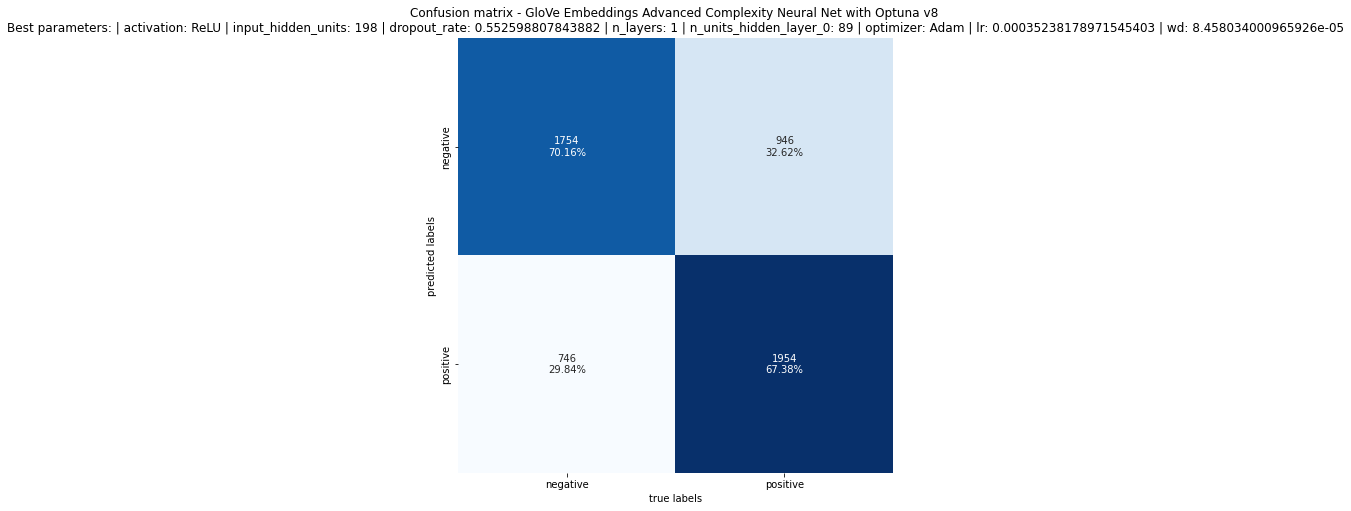

In [57]:
label_names = ["negative", "positive"]

trial_best_params=[]
for key, value in trial.params.items():
  trial_best_params.append("| {}: {}".format(key,value))
  best_model_params=" ".join(trial_best_params)

graph_name = "GloVe Embeddings Advanced Complexity Neural Net with Optuna v8 \nBest parameters: " + best_model_params
y_true, y_pred, y_pred_probabilities = nn_evaluation(
  best_model,
  valid_loader,
  label_names,
  np.unique(valid_y),
  graph_name
)

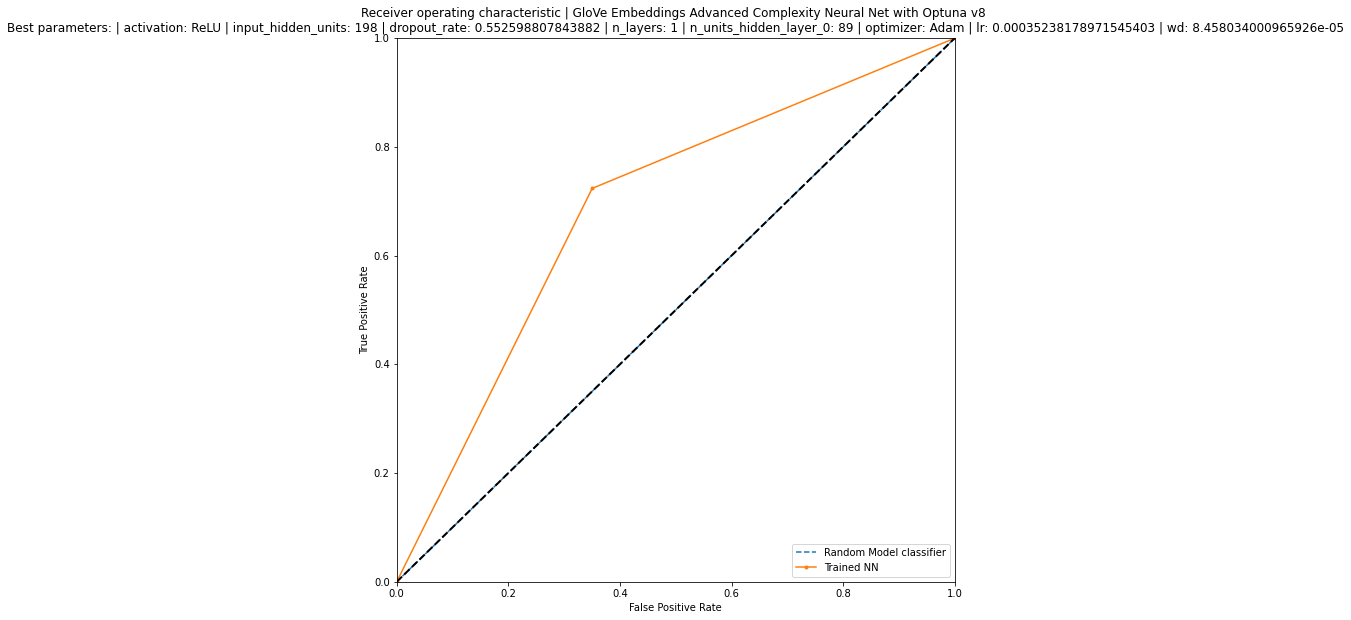

In [58]:
roc_curve_plot(
  y_true,
  y_pred,
  graph_name
)

### Evaluate model on grader's data

Before starting:
- Import the libraries (on top of the notebook).
- Execute the code cell with title: *Import & Initialize all the functions used in the experiments* (on top of the notebook).

In [4]:
!pip install --quiet emoji

from tqdm.notebook import tqdm
tqdm.pandas()
import re
import string
import emoji
import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

def text_preprocessing(table: pd.DataFrame) -> pd.DataFrame:
  """
  Definition
  ---------
  Apply the text processing methods to clean, normalize text and make it ready for machine learning models.
  The functions applied are: 
    * remove_emoji_characters()
    * transform_abbreviations()
    * remove_stop_words()
    * text_lemmatization()

  Aguments
  ---------
  table: The pandas dataframe to apply the functions.

  Return
  --------
  table: The pandas dataframe with a new column that will be cleaned and normalized. In the code, the new column has the name 'normalized_review'.
         The returned pandas dataframe will have three new columns: processed_review, removed_stopwords_review, normalized_review.
  """

  def remove_emoji_characters(phrase:str) -> str:
    """
    Source
    ---------
    https://stackoverflow.com/a/50602709/10623444

    Definition
    ---------
    Remove emoji characters from the textual content of the dataset. 
    Emoji's cannot be interpreted to a numerical features, plus they don't add any meanigful essence to the text whatsoever. 
    Emoji is an unnecessary form of informantion.

    Aguments
    ---------
    phrase: The string sentence value to remove emojis from it.

    Return
    --------
    Sentence without emojis.
    """
    return emoji.replace_emoji(phrase, replace="")

  def transform_abbreviations(phrase:str) -> str:
    """
    Source
    ---------
    My thesis: https://github.com/NikosSpanos/NLP_Applications/blob/main/multi-label-text-classification-on-movies/Part%203.1%20-%20Data%20Tokenization%20%26%20Sequence%20padding.ipynb

    Definition
    ---------
    Transform abbreviations is a function that will take common english abbreviations likes won't and transform them to their full context such as will not. 
    It would be easier to better clean reviews from common words and punctuations. The function also removes numerical text.

    Aguments
    ---------
    phrase: The string sentence to replace abbreviations from.

    Return
    --------
    Sentence without abbrevaitions.
    """
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"-", " ", phrase) #split words connected with a dash '-'. For example, action-paced => action paced
    phrase = re.sub(r"<br />", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br>", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br >", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"<br/>", " ", phrase) #remove specific new line HTML tag
    phrase = re.sub(r"http\S+", "", phrase, flags=re.MULTILINE) # remove http(s) hyperlink tags
    phrase = re.sub(r"@\w+", "", phrase, flags=re.MULTILINE) # remove tagged tweeter users (@...)
    phrase = re.sub(r"\d+", "", phrase) # remove digit/numerical characters
    return phrase

  def remove_stop_words(phrase:str) -> str:
    """
    Definition
    ---------
    Remove commonly used words such as articles from the text.
    Stop wodrd occur frequently and don’t contribute much to the overall meaning of the sentence.
    
    Aguments
    ---------
    phrase : A sentence of type string.
    
    Return
    ---------
    phrase: Returns the sentence without the stop_words.
    """
    stop_words = set(stopwords.words('english')) # retrive the list of nltk stop_words
    cleaned_text = [word for word in word_tokenize(phrase.lower()) if word.lower() not in stop_words]

    return " ".join(cleaned_text) # we need to join the sentence because word_tokenize() splits the phrase to single tokens/words

  def text_lemmatization(phrase:str) -> str:
    """
    Definition
    ---------
    Apply lemmatization to the single tokens of a text. Lemmatization will identify the part-of-speech of a word and will replace it with its lemma.
    
    Aguments
    ---------
    phrase : A sentence of type string.
    
    Return
    ---------
    lemmas of phrase: Returns the sentence with lemmatized tokens/words.
    """
    lemmatizer      = WordNetLemmatizer() # initialize nltk lemmatizer method
    lemmatized_text = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in pos_tag(word_tokenize(phrase.lower()))]

    return " ".join(lemmatized_text) # we need to join the sentence because word_tokenize() splits the phrase to single tokens/words

  encoding = 'utf-8'
  
  # Apply functions remove_emoji_characters(), transform_abbreviations()
  table["processed_review"] = table["review"].progress_apply(lambda review: \
                                                              re.sub(" +", " ", \
                                                                  remove_emoji_characters( \
                                                                    transform_abbreviations( \
                                                                      str(review.encode("ascii", "ignore"), encoding) \
                                                                    ) \
                                                                  ).\
                                                                  translate(str.maketrans('', '', string.punctuation)).strip()
                                                                )
                                                              )
  print("\nReviews | After cleaning")
  print(table["processed_review"].iloc[0:3])
  print("\nReviews | Before cleaning")
  print(table["review"].iloc[0:3])

  # Apply function remove_stop_words()
  table["removed_stopwords_review"] = table["processed_review"].progress_apply(lambda review: remove_stop_words(review.lower()))
  
  print("\nReviews | After removing stop words")
  print(table["removed_stopwords_review"].iloc[0:3])
  print("\nReviews | Before removing stop words")
  print(table["processed_review"].iloc[0:3])

  # Apply function text_lemmatization()
  table["normalized_review"] = table["removed_stopwords_review"].progress_apply(lambda review: text_lemmatization(review.lower()))
  
  print("\nReviews | After text normalization-lemmatization")
  print(table["normalized_review"].iloc[0:3])
  print("\nReviews | Before text normalization-lemmatization")
  print(table["removed_stopwords_review"].iloc[0:3])

  return table

# Trainable embeddings best model
class SentimentClassifier_advanced_complexity_optuna_v2(nn.Module):
  
  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):
  
    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_v2, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = non_contributive_token

    linear_hidden_units = trial.suggest_int("input_hidden_units", 64, 128)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    else:
      embedding_dimension = trial.suggest_int("embedding_dimension", 10, 100)
      self.embedding = nn.Embedding(vocab_size, embedding_dimension, padding_idx=padding_idx)
      self.embedding.weight.requires_grad = True
      
      #input layer
      self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 64)
          self.layers.append(nn.Linear(linear_hidden_units, out_features))
          self.layers.append(nn.BatchNorm1d(out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    self.activation_embeddings = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)
    embedded = torch.mean(embedded, dim=1)
    embedded = self.activation_embeddings(embedded)
    # embedded = self.flatten_layer(embedded)

    input_layer = self.input_layer(embedded)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

# GloVe embeddings best model
class SentimentClassifier_advanced_complexity_optuna_glove_v6(nn.Module):

  def __init__(self, trial, non_contributive_token, vocab_size, vector_length, output_dim, activation, use_pretrained_embeddings, embedding_matrix=None, embedding_dimension=None):

    #Constructor
    super(SentimentClassifier_advanced_complexity_optuna_glove_v6, self).__init__()

    self.layers = []
    self.use_pretrained_embeddings = use_pretrained_embeddings
    padding_idx = non_contributive_token

    linear_hidden_units = trial.suggest_int("input_hidden_units", 128, 256)

    #embedding layer
    if self.use_pretrained_embeddings:
      self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True, padding_idx=padding_idx)
      #self.embedding.weight.data.copy_(embedding_matrix)
      #self.embedding.weight.requires_grad = False #freeze training of the pre-trained embeddings
      
    #input layer
    self.input_layer = nn.Linear(embedding_dimension, linear_hidden_units)

    #flatten layer
    self.flatten_layer = nn.Flatten()

    self.normalize_input_layer = nn.BatchNorm1d(3*linear_hidden_units)
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.75)
    self.dropout_input_layer = nn.Dropout(dropout_rate)

    self.n_layers = trial.suggest_int("n_layers", 0, 3)

    if self.n_layers != 0:
        for i in range(self.n_layers):
          out_features = trial.suggest_int("n_units_hidden_layer_{}".format(i), 8, 128)
          self.layers.append(nn.Linear(3*linear_hidden_units, 3*out_features))
          self.layers.append(nn.BatchNorm1d(3*out_features))
          if activation.lower() == "relu":
              self.layers.append(nn.ReLU())
          else:
              self.layers.append(nn.Tanh())
          self.layers.append(nn.Dropout(dropout_rate))
          linear_hidden_units = out_features

    #output layer
    self.output_layer = nn.Linear(3*linear_hidden_units, output_dim)

    #activation function
    if activation.lower() == "relu":
        self.activation = nn.ReLU()
    else:
        self.activation = nn.Tanh()

    #activation of outout layer
    self.activation_output = nn.Sigmoid()

    for idx, layer in enumerate(self.layers):
        setattr(self, f"fully_connected_layer_{idx}", layer)
    
    #initialize weights of embedding layer
    self.apply(self._init_weights)

  # def init_weights(self):

  #   initrange = 1.0
    
  #   self.embedding.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.weight.data.uniform_(-initrange, initrange)
  #   self.input_layer.bias.data.zero_()
  
  def _init_weights(self, module):

    initrange = 1.0

    if isinstance(module, nn.Linear):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.bias is not None:
        module.bias.data.zero_()

    elif isinstance(module, nn.Embedding):
      #module.weight.data.normal_(mean=0.0, std=1.0)
      module.weight.data.uniform_(-initrange, initrange)

      if module.padding_idx is not None:
        module.weight.data[module.padding_idx].zero_()
  
  def forward(self, text):

    embedded = self.embedding(text)

    if self.use_pretrained_embeddings:
      embedded_average = torch.mean(embedded, dim=1)
      embedded_max = torch.max(embedded, dim=1)[0]
      embedded_min = torch.min(embedded, dim=1)[0]

      #use of average embeddings transformation
      input_layer_average = self.input_layer(embedded_average)
      
      #use of max embeddings transformation
      input_layer_max = self.input_layer(embedded_max)

      #use of min embeddings transformation
      input_layer_min = self.input_layer(embedded_min)
    
    input_layer = torch.concat([input_layer_average, input_layer_max, input_layer_min], dim=1)
    input_layer = self.normalize_input_layer(input_layer)
    input_layer = self.activation(input_layer)
    input_layer = self.dropout_input_layer(input_layer)

    if self.n_layers !=0:
      for layer in self.layers:
          input_layer = layer(input_layer)

    output_layer = self.output_layer(input_layer)
    output_layer = self.activation_output(output_layer)
    
    return output_layer

     |████████████████████████████████| 240 kB 16.5 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
label_names = ["negative", "positive"]

def grader_scoring(
    data_filepath:str,
    optuna_trial_path:str,
    model_state:str,
    label_names,
    graph_name:str,
    model_type:str,
    batch_size:int,
    vocabulary_path:str = None,
    glove_vectors_object:str = None
  ):
  """
  Definition
  ---------
  A method to help the grader score a never-seen-before dataset of movie reviews.

  Aguments
  ---------
  data_filepath : The path were the file with reviews exist. An assumption made is the existense of a column named "review" in the argument passed.
  optuna_trial_path : The path with the study of optuna trials for the selected experiment. Each experiment has a saved study object with 16 to 25 trials. Each trial is a differnt set of hyper-parameters.
  model_state : The path with the saved model state of the best model estimator.
  label_names : The label names of the target sentiment values. Any custom names given by the user.
  graph_name : Name the evaluation report generated.
  model_type : Evaluate the never-seen-before dataset with custom-trainable embeddings or with GloVe pre-trained embeddings.
  batch_size : The batch-size (sentences per batch). Used to create the DataLoader() object.
  vocabulary_path: The path of the custom vocabulay path. Used only if the trainable embeddings model is imported.
  glove_vectors_object: The path with the saved glove vectors.

  Output
  ---------
  Evaluation report of the scored samples.
  """ 
  # 1. Import sample
  test_sample = pd.read_csv(os.path.join(os.getcwd(), data_filepath), sep="\t", header=0)

  # 2. Transform target column to binary
  target_column = 'rating'
  conditions = [ (test_sample[target_column] >= 0.0) & (test_sample[target_column] <= 4.0)
                ,(test_sample[target_column] >= 7.0) & (test_sample[target_column] <= 10.0) 
                ]
  choices = [ 0, 1 ]

  test_sample['target'] = np.select(conditions, choices)

  # 3. Text preprocessing
  cleaned_test_sample = text_preprocessing(test_sample)

  # 4. Create iterator sample
  iterator_sample = list(zip(cleaned_test_sample['target'],cleaned_test_sample['normalized_review']))
  target_sentiment = cleaned_test_sample[["target"]].values

  # 5. Load vocabulary
  unk_token = '<unk>' #change that if needed. Keep a note on READme file
  unk_index = 0 #change that if needed

  if model_type == "custom":
    vocab = load(vocabulary_path)
  else:
    glove_vectors = load(glove_vectors_object)
    vocab = torchtext.vocab.vocab(glove_vectors.stoi)
    vocab.insert_token(unk_token,unk_index)
    vocab.set_default_index(unk_index)

  # 6. Vectorize data from the vocabulary
  vectors_array = []

  for sentiment, review in tqdm(iterator_sample):
    vector_review_array = []
    for word in review.split(' '):
      if word in vocab:
        vector_review_array.append(vocab[word])
      else:
        vector_review_array.append(vocab[unk_token])
    vectors_array.append(vector_review_array)
  
  # 7. Pad vectors
  padding_value = 165 #(80% of total sentence lengths)
  padded_vectors = padded_sequences(vectors_array, padding_value)

  # 8. Create TensorData object
  test_data = torch.utils.data.TensorDataset(torch.LongTensor(padded_vectors), torch.LongTensor(target_sentiment))

  # 9. Create DataLoader object
  test_loader=torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
  
  # 10. Load best Optuna trial
  best_model_study=joblib.load(optuna_trial_path)
  trial=best_model_study.best_trial

  if model_type == "custom":
    model = SentimentClassifier_advanced_complexity_optuna_v2(
      trial,
      non_contributive_token=vocab[unk_token],
      vocab_size=len(vocab),
      vector_length=padding_value,
      output_dim=1,
      activation="ReLU",
      use_pretrained_embeddings=False
    )
  else:
    model = SentimentClassifier_advanced_complexity_optuna_glove_v6(
    trial,
    non_contributive_token=vocab[unk_token],
    vocab_size=len(vocab),
    vector_length=padding_value,
    output_dim=1,
    activation="ReLU",
    use_pretrained_embeddings=True,
    embedding_matrix=glove_vectors.vectors,
    embedding_dimension=glove_vectors.dim
  )
    
  # 11. Load best model state
  model.load_state_dict(torch.load(model_state))

  y_true, y_pred, y_pred_probabilities = nn_evaluation(
    model,
    test_loader,
    label_names,
    np.unique(target_sentiment),
    graph_name
  )

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After cleaning
0                I really have problems rating this movie It is directed brilliantly there is obviously a lot of money in it Gere and Danes are intense although her screen personality could use a bit more defining and spicing up editing and cinematography are excellent On the other hand it is one of those really really sick movies where one cannot help but wonder whether the director himself likes to stage specific scenes and yes one cannot help but wonder how many copycats will such a movie inspire In purely artistic terms it is a but I really have to ask myself who these people are giving their money to produce such a movie
1                                                                                                                                                                                                                                                                                                                                                   

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After removing stop words
0                         really problems rating movie directed brilliantly obviously lot money gere danes intense although screen personality could use bit defining spicing editing cinematography excellent hand one really really sick movies one help wonder whether director likes stage specific scenes yes one help wonder many copycats movie inspire purely artistic terms really ask people giving money produce movie
1                                                                                                                                                                                                                                                                                       never seen terrible performances life everyone entire film absolute rubbish one decent actoractress whole film joke reminded drama school
2    movies like originals album oriented rock stations music used like repetitive boring drained original energy committee cor

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After text normalization-lemmatization
0                          really problem rating movie direct brilliantly obviously lot money gere dane intense although screen personality could use bit define spice edit cinematography excellent hand one really really sick movie one help wonder whether director like stage specific scene yes one help wonder many copycat movie inspire purely artistic term really ask people give money produce movie
1                                                                                                                                                                                                                                                                          never see terrible performance life everyone entire film absolute rubbish one decent actoractress whole film joke remind drama school
2    movie like original album orient rock station music use like repetitive boring drain original energy committee corporate drone glad aragorn typ

  0%|          | 0/2000 [00:00<?, ?it/s]

Evaluation metrics: Trainable word embeddings 

precision score: 0.7652 
recall_score: 0.9339 
roc score: 0.8242 
f1_score: 0.8412

model bias: 0.024
model variance: 0.2381


              precision    recall  f1-score   support

    negative       0.92      0.71      0.80      1002
    positive       0.77      0.93      0.84       998

    accuracy                           0.82      2000
   macro avg       0.84      0.82      0.82      2000
weighted avg       0.84      0.82      0.82      2000





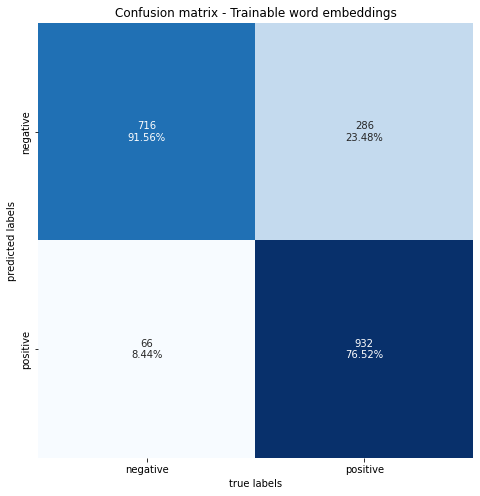

In [6]:
label_names = ["negative", "positive"]
grader_scoring(
    data_filepath = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/test_sample.csv", #(provided by grader)
    optuna_trial_path = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/trainable_embeddings_advanced_complexity_v2/trainable_embeddings_best_advanced_complexity_study_optuna_v2.pkl",
    model_state = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/trainable_embeddings_advanced_complexity_v2/trainable_embeddings_best_advanced_complexity_nn_optuna_v2.pt",
    label_names = label_names,
    graph_name = "Trainable word embeddings",
    model_type = "custom",
    batch_size = 64,
    vocabulary_path = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/custom_vocabulary_v2.joblib",
)

Find the model's state and Optuna best trial in the following shared folder: https://drive.google.com/drive/folders/1JcG8CdNhXr6YoJNQOFJO3zVScjnNYxu9?usp=sharing

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After cleaning
0                I really have problems rating this movie It is directed brilliantly there is obviously a lot of money in it Gere and Danes are intense although her screen personality could use a bit more defining and spicing up editing and cinematography are excellent On the other hand it is one of those really really sick movies where one cannot help but wonder whether the director himself likes to stage specific scenes and yes one cannot help but wonder how many copycats will such a movie inspire In purely artistic terms it is a but I really have to ask myself who these people are giving their money to produce such a movie
1                                                                                                                                                                                                                                                                                                                                                   

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After removing stop words
0                         really problems rating movie directed brilliantly obviously lot money gere danes intense although screen personality could use bit defining spicing editing cinematography excellent hand one really really sick movies one help wonder whether director likes stage specific scenes yes one help wonder many copycats movie inspire purely artistic terms really ask people giving money produce movie
1                                                                                                                                                                                                                                                                                       never seen terrible performances life everyone entire film absolute rubbish one decent actoractress whole film joke reminded drama school
2    movies like originals album oriented rock stations music used like repetitive boring drained original energy committee cor

  0%|          | 0/2000 [00:00<?, ?it/s]


Reviews | After text normalization-lemmatization
0                          really problem rating movie direct brilliantly obviously lot money gere dane intense although screen personality could use bit define spice edit cinematography excellent hand one really really sick movie one help wonder whether director like stage specific scene yes one help wonder many copycat movie inspire purely artistic term really ask people give money produce movie
1                                                                                                                                                                                                                                                                          never see terrible performance life everyone entire film absolute rubbish one decent actoractress whole film joke remind drama school
2    movie like original album orient rock station music use like repetitive boring drain original energy committee corporate drone glad aragorn typ

  0%|          | 0/2000 [00:00<?, ?it/s]

Evaluation metrics: GloVe pre-trained embeddings 

precision score: 0.7388 
recall_score: 0.7966 
roc score: 0.7581 
f1_score: 0.7666

model bias: 0.0029
model variance: 0.2486


              precision    recall  f1-score   support

    negative       0.78      0.72      0.75      1002
    positive       0.74      0.80      0.77       998

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000





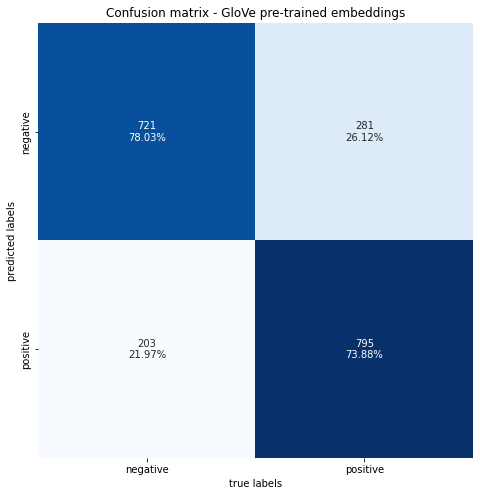

In [7]:
label_names = ["negative", "positive"]
grader_scoring(
    data_filepath = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project I/test_sample.csv", #(provided by grader)
    optuna_trial_path = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_embeddings_advanced_complexity_v6/glove_embeddings_advanced_complexity_study_optuna_v6.pkl",
    model_state = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_embeddings_advanced_complexity_v6/glove_embeddings_advanced_complexity_nn_optuna_v6.pt",
    label_names = label_names,
    graph_name = "GloVe pre-trained embeddings",
    model_type = "glove",
    batch_size = 256,
    glove_vectors_object = "drive/MyDrive/ComputerScience/Artificial Intelligence II - Fall 2022/Project II/glove_vectors_200_6B.joblib",
)